In [1]:
import numpy as np
from PIL import Image
import os
import string
import csv
import re
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress

2024-05-02 18:46:13.675627: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 18:46:13.705530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 18:46:13.705560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 18:46:13.706599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 18:46:13.712238: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


dataset_text = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Flickr8k_text"
dataset_images = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Flickr8k_Dataset"
filename = dataset_text + "/" + "Flickr8k.token.txt"

descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [3]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from keras.applications import Xception
import tensorflow as tf
from pickle import dump

def extract_features(directory):
    # Set TensorFlow to use GPU if available
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify which GPU to use, if you have multiple GPUs
    
    # Configure TensorFlow to use GPU memory dynamically
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU is available and will be used for computations.")
        except RuntimeError as e:
            print(e)
            print("GPU will not be used. Switching to CPU.")
    else:
        print("GPU is not available. Switching to CPU.")
    
    # Load the Xception model without the top layer
    model = Xception(include_top=False, pooling='avg')
    
    # Get the list of images in the directory
    image_files = os.listdir(directory)
    
    # Initialize tqdm to display the main progress bar
    progress_bar = tqdm(total=len(image_files), desc="Extracting features", unit="images", position=0, dynamic_ncols=True)
    
    # Dictionary to store extracted features
    features = {}
    
    # Batch size for updating progress bar
    batch_size = 10
    
    # Counter to track progress
    progress_counter = 0
    
    # Iterate over each image in the directory
    for img in image_files:
        # Load and preprocess the image
        filename = os.path.join(directory, img)
        image = Image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        image = image / 127.5
        image = image - 1.0
        
        # Extract features using the Xception model
        feature = model.predict(image)
        
        # Store the extracted feature in the dictionary
        features[img] = feature
        
        # Update the main progress bar for each image processed
        progress_counter += 1
        progress_bar.update(1)
        
    # Close the main progress bar
    progress_bar.close()
    
    return features


In [4]:
#8091 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

2024-05-02 18:46:15.942795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.093794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.093840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


GPU is available and will be used for computations.


2024-05-02 18:46:16.109379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.109466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.109486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.308150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 18:46:16.308215: I external/local_xla/xla/stream_executor

1/1 [==============================] - 3s 3s/step


Extracting features:   0%|                                                       | 1/8091 [00:02<6:08:27,  2.73s/images]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|                                                       | 3/8091 [00:02<1:44:17,  1.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|                                                       | 4/8091 [00:03<1:12:55,  1.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|                                                         | 6/8091 [00:03<41:56,  3.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|                                                         | 8/8091 [00:03<28:44,  4.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   0%|                                                        | 10/8091 [00:03<22:30,  5.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   0%|                                                        | 12/8091 [00:03<18:11,  7.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|                                                        | 14/8091 [00:03<15:21,  8.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|                                                        | 16/8091 [00:03<13:46,  9.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|                                                        | 18/8091 [00:04<12:39, 10.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                       | 20/8091 [00:04<11:47, 11.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                       | 22/8091 [00:04<11:07, 12.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   0%|▏                                                       | 24/8091 [00:04<10:50, 12.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                       | 26/8091 [00:04<10:34, 12.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   0%|▏                                                       | 28/8091 [00:04<10:20, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                       | 30/8091 [00:04<10:18, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                       | 32/8091 [00:05<10:15, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                       | 34/8091 [00:05<10:12, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                       | 36/8091 [00:05<10:14, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|▎                                                       | 38/8091 [00:05<10:11, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▎                                                       | 40/8091 [00:05<10:12, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▎                                                       | 42/8091 [00:05<10:14, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▎                                                       | 44/8091 [00:06<10:18, 13.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   1%|▎                                                       | 46/8091 [00:06<10:12, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                       | 48/8091 [00:06<10:06, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▎                                                       | 50/8091 [00:06<10:11, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▎                                                       | 52/8091 [00:06<10:15, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                       | 54/8091 [00:06<10:10, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▍                                                       | 56/8091 [00:06<10:20, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▍                                                       | 58/8091 [00:07<10:23, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▍                                                       | 60/8091 [00:07<10:23, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▍                                                       | 62/8091 [00:07<10:14, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▍                                                       | 64/8091 [00:07<10:19, 12.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   1%|▍                                                       | 66/8091 [00:07<10:09, 13.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▍                                                       | 68/8091 [00:07<10:11, 13.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   1%|▍                                                       | 70/8091 [00:08<10:50, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▍                                                       | 72/8091 [00:08<11:48, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   1%|▌                                                       | 74/8091 [00:08<11:21, 11.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                       | 76/8091 [00:08<11:42, 11.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   1%|▌                                                       | 78/8091 [00:08<11:48, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▌                                                       | 80/8091 [00:08<11:49, 11.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                       | 82/8091 [00:09<12:00, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▌                                                       | 84/8091 [00:09<12:11, 10.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   1%|▌                                                       | 86/8091 [00:09<12:12, 10.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   1%|▌                                                       | 88/8091 [00:09<12:02, 11.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                       | 90/8091 [00:09<11:34, 11.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▋                                                       | 92/8091 [00:10<11:27, 11.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                       | 94/8091 [00:10<11:32, 11.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▋                                                       | 96/8091 [00:10<11:28, 11.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                       | 98/8091 [00:10<11:11, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   1%|▋                                                      | 100/8091 [00:10<11:21, 11.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                      | 102/8091 [00:10<11:09, 11.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▋                                                      | 104/8091 [00:11<11:19, 11.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▋                                                      | 106/8091 [00:11<11:19, 11.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                      | 108/8091 [00:11<10:48, 12.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▋                                                      | 110/8091 [00:11<10:40, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▊                                                      | 112/8091 [00:11<10:57, 12.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▊                                                      | 114/8091 [00:11<11:06, 11.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▊                                                      | 116/8091 [00:12<11:03, 12.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▊                                                      | 118/8091 [00:12<11:16, 11.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                      | 120/8091 [00:12<11:21, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   2%|▊                                                      | 122/8091 [00:12<11:14, 11.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▊                                                      | 124/8091 [00:12<11:12, 11.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▊                                                      | 126/8091 [00:12<11:02, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▊                                                      | 128/8091 [00:13<11:01, 12.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                      | 130/8091 [00:13<10:56, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|▉                                                      | 132/8091 [00:13<10:57, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▉                                                      | 134/8091 [00:13<10:51, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   2%|▉                                                      | 136/8091 [00:13<10:53, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▉                                                      | 138/8091 [00:13<11:04, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▉                                                      | 140/8091 [00:14<11:18, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▉                                                      | 142/8091 [00:14<12:12, 10.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▉                                                      | 144/8091 [00:14<12:12, 10.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▉                                                      | 146/8091 [00:14<11:58, 11.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█                                                      | 148/8091 [00:14<11:24, 11.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█                                                      | 150/8091 [00:14<11:25, 11.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                      | 152/8091 [00:15<10:59, 12.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█                                                      | 154/8091 [00:15<10:41, 12.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                      | 156/8091 [00:15<11:05, 11.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█                                                      | 158/8091 [00:15<11:29, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█                                                      | 160/8091 [00:15<12:22, 10.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                      | 162/8091 [00:16<11:41, 11.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                      | 164/8091 [00:16<11:02, 11.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                     | 166/8091 [00:16<11:01, 11.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                     | 168/8091 [00:16<10:28, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█▏                                                     | 170/8091 [00:16<10:06, 13.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|█▏                                                     | 172/8091 [00:16<09:59, 13.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   2%|█▏                                                     | 174/8091 [00:16<10:24, 12.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   2%|█▏                                                     | 176/8091 [00:17<11:13, 11.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                     | 178/8091 [00:17<10:54, 12.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   2%|█▏                                                     | 180/8091 [00:17<11:10, 11.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▏                                                     | 182/8091 [00:17<10:43, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█▎                                                     | 184/8091 [00:17<10:28, 12.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   2%|█▎                                                     | 186/8091 [00:17<10:12, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                     | 188/8091 [00:18<10:01, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                     | 190/8091 [00:18<10:20, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   2%|█▎                                                     | 192/8091 [00:18<10:20, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█▎                                                     | 194/8091 [00:18<10:15, 12.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▎                                                     | 196/8091 [00:18<10:25, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                     | 198/8091 [00:18<10:29, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                     | 200/8091 [00:18<10:02, 13.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   2%|█▎                                                     | 202/8091 [00:19<09:44, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   3%|█▍                                                     | 204/8091 [00:19<10:28, 12.56images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:   3%|█▍                                                     | 206/8091 [00:19<10:51, 12.11images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:   3%|█▍                                                     | 208/8091 [00:19<11:10, 11.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▍                                                     | 210/8091 [00:19<12:25, 10.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   3%|█▍                                                     | 212/8091 [00:20<12:07, 10.84images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:   3%|█▍                                                     | 214/8091 [00:20<11:51, 11.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▍                                                     | 216/8091 [00:20<11:12, 11.71images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   3%|█▍                                                     | 218/8091 [00:20<10:51, 12.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▍                                                     | 220/8091 [00:20<10:40, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                     | 222/8091 [00:20<10:13, 12.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:   3%|█▌                                                     | 224/8091 [00:21<10:35, 12.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▌                                                     | 226/8091 [00:21<11:22, 11.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▌                                                     | 228/8091 [00:21<12:18, 10.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▌                                                     | 230/8091 [00:21<11:41, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▌                                                     | 232/8091 [00:21<11:16, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▌                                                     | 234/8091 [00:21<11:29, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   3%|█▌                                                     | 236/8091 [00:22<11:11, 11.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                     | 238/8091 [00:22<11:13, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   3%|█▋                                                     | 240/8091 [00:22<11:37, 11.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 242/8091 [00:22<11:10, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▋                                                     | 244/8091 [00:23<24:21,  5.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 245/8091 [00:23<23:04,  5.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 247/8091 [00:23<18:41,  6.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 249/8091 [00:23<16:08,  8.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 251/8091 [00:24<14:19,  9.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▋                                                     | 253/8091 [00:24<13:20,  9.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▋                                                     | 255/8091 [00:24<12:20, 10.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                     | 257/8091 [00:24<11:37, 11.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▊                                                     | 259/8091 [00:24<11:16, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▊                                                     | 261/8091 [00:24<11:55, 10.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   3%|█▊                                                     | 263/8091 [00:25<12:13, 10.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▊                                                     | 265/8091 [00:25<12:33, 10.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                     | 267/8091 [00:25<12:52, 10.13images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   3%|█▊                                                     | 269/8091 [00:25<12:49, 10.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   3%|█▊                                                     | 271/8091 [00:25<13:06,  9.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▊                                                     | 273/8091 [00:26<12:55, 10.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                     | 275/8091 [00:26<12:46, 10.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▉                                                     | 277/8091 [00:26<13:03,  9.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▉                                                     | 279/8091 [00:26<12:40, 10.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▉                                                     | 281/8091 [00:26<12:35, 10.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   3%|█▉                                                     | 283/8091 [00:27<12:38, 10.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|█▉                                                     | 285/8091 [00:27<12:58, 10.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|█▉                                                     | 287/8091 [00:27<13:07,  9.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   4%|█▉                                                     | 288/8091 [00:27<13:20,  9.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                     | 289/8091 [00:27<13:27,  9.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                     | 290/8091 [00:27<13:23,  9.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   4%|█▉                                                     | 292/8091 [00:28<13:43,  9.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                     | 293/8091 [00:28<13:36,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   4%|█▉                                                     | 294/8091 [00:28<13:34,  9.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██                                                     | 296/8091 [00:28<12:54, 10.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██                                                     | 297/8091 [00:28<13:06,  9.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                     | 299/8091 [00:28<12:46, 10.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██                                                     | 301/8091 [00:28<12:41, 10.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                     | 303/8091 [00:29<12:29, 10.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                     | 305/8091 [00:29<11:58, 10.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██                                                     | 307/8091 [00:29<12:31, 10.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   4%|██                                                     | 309/8091 [00:29<12:31, 10.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   4%|██                                                     | 311/8091 [00:29<12:28, 10.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                    | 313/8091 [00:30<11:59, 10.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                    | 315/8091 [00:30<11:08, 11.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                    | 317/8091 [00:30<11:02, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▏                                                    | 319/8091 [00:30<10:47, 12.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                    | 321/8091 [00:30<10:31, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                    | 323/8091 [00:30<10:14, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                    | 325/8091 [00:30<10:15, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                    | 327/8091 [00:31<10:08, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                    | 329/8091 [00:31<10:10, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 331/8091 [00:31<10:07, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 333/8091 [00:31<10:02, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▎                                                    | 335/8091 [00:31<10:08, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 337/8091 [00:31<10:19, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 339/8091 [00:32<10:09, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▎                                                    | 341/8091 [00:32<10:05, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 343/8091 [00:32<10:22, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▎                                                    | 345/8091 [00:32<10:13, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                    | 347/8091 [00:32<10:01, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                    | 349/8091 [00:32<10:39, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   4%|██▍                                                    | 351/8091 [00:33<10:25, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▍                                                    | 353/8091 [00:33<10:29, 12.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▍                                                    | 355/8091 [00:33<10:50, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   4%|██▍                                                    | 357/8091 [00:33<10:30, 12.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   4%|██▍                                                    | 359/8091 [00:33<10:21, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▍                                                    | 361/8091 [00:33<10:35, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▍                                                    | 363/8091 [00:34<11:21, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▍                                                    | 365/8091 [00:34<10:58, 11.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                    | 367/8091 [00:34<10:40, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▌                                                    | 369/8091 [00:34<10:17, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▌                                                    | 371/8091 [00:34<10:04, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▌                                                    | 373/8091 [00:34<10:20, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▌                                                    | 375/8091 [00:35<10:52, 11.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   5%|██▌                                                    | 377/8091 [00:35<12:25, 10.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   5%|██▌                                                    | 379/8091 [00:35<12:27, 10.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   5%|██▌                                                    | 381/8091 [00:35<13:04,  9.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▌                                                    | 383/8091 [00:35<12:42, 10.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▌                                                    | 385/8091 [00:36<12:50, 10.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   5%|██▋                                                    | 387/8091 [00:36<12:46, 10.06images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:   5%|██▋                                                    | 389/8091 [00:36<13:04,  9.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▋                                                    | 390/8091 [00:36<13:01,  9.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▋                                                    | 392/8091 [00:36<12:41, 10.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▋                                                    | 394/8091 [00:36<12:42, 10.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   5%|██▋                                                    | 396/8091 [00:37<12:14, 10.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:   5%|██▋                                                    | 398/8091 [00:37<13:38,  9.40images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   5%|██▋                                                    | 399/8091 [00:37<13:40,  9.38images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:   5%|██▋                                                    | 400/8091 [00:37<13:33,  9.45images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   5%|██▋                                                    | 402/8091 [00:37<12:52,  9.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▋                                                    | 404/8091 [00:38<13:11,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▊                                                    | 405/8091 [00:38<13:20,  9.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▊                                                    | 407/8091 [00:38<12:51,  9.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   5%|██▊                                                    | 409/8091 [00:38<12:36, 10.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   5%|██▊                                                    | 411/8091 [00:38<11:43, 10.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   5%|██▊                                                    | 413/8091 [00:38<11:24, 11.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   5%|██▊                                                    | 415/8091 [00:39<11:19, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▊                                                    | 417/8091 [00:39<11:18, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▊                                                    | 419/8091 [00:39<11:05, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   5%|██▊                                                    | 421/8091 [00:39<11:28, 11.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   5%|██▉                                                    | 423/8091 [00:39<11:05, 11.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                    | 425/8091 [00:39<11:02, 11.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▉                                                    | 427/8091 [00:40<11:14, 11.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                    | 429/8091 [00:40<11:43, 10.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   5%|██▉                                                    | 431/8091 [00:40<11:38, 10.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                    | 433/8091 [00:40<11:04, 11.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                    | 435/8091 [00:40<10:43, 11.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▉                                                    | 437/8091 [00:40<10:33, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                    | 439/8091 [00:41<10:15, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                    | 441/8091 [00:41<09:54, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|███                                                    | 443/8091 [00:41<09:54, 12.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   5%|███                                                    | 445/8091 [00:41<10:40, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   6%|███                                                    | 447/8091 [00:41<11:08, 11.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███                                                    | 449/8091 [00:41<11:24, 11.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                    | 451/8091 [00:42<11:15, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███                                                    | 453/8091 [00:42<10:50, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███                                                    | 455/8091 [00:42<11:03, 11.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                    | 457/8091 [00:42<10:43, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                    | 459/8091 [00:42<10:19, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                   | 461/8091 [00:42<10:28, 12.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   6%|███▏                                                   | 463/8091 [00:43<11:09, 11.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                   | 465/8091 [00:43<11:38, 10.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                   | 467/8091 [00:43<12:19, 10.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▏                                                   | 469/8091 [00:43<11:29, 11.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                   | 471/8091 [00:43<11:26, 11.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                   | 473/8091 [00:44<11:32, 11.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   6%|███▏                                                   | 475/8091 [00:44<11:37, 10.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   6%|███▏                                                   | 477/8091 [00:44<11:57, 10.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                   | 479/8091 [00:44<11:35, 10.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                   | 481/8091 [00:44<11:20, 11.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                   | 483/8091 [00:44<10:58, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   6%|███▎                                                   | 485/8091 [00:45<10:31, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   6%|███▎                                                   | 487/8091 [00:45<10:36, 11.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▎                                                   | 489/8091 [00:45<10:23, 12.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                   | 491/8091 [00:45<10:23, 12.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   6%|███▎                                                   | 493/8091 [00:45<10:22, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                   | 495/8091 [00:45<10:16, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                   | 497/8091 [00:46<09:58, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                   | 499/8091 [00:46<09:48, 12.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   6%|███▍                                                   | 501/8091 [00:46<09:48, 12.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▍                                                   | 503/8091 [00:46<09:45, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                   | 505/8091 [00:46<09:43, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                   | 507/8091 [00:46<09:42, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▍                                                   | 509/8091 [00:46<09:39, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                   | 511/8091 [00:47<09:34, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                   | 513/8091 [00:47<09:32, 13.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███▌                                                   | 515/8091 [00:47<09:47, 12.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▌                                                   | 517/8091 [00:47<10:03, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▌                                                   | 519/8091 [00:47<10:10, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▌                                                   | 521/8091 [00:47<10:29, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▌                                                   | 523/8091 [00:48<11:15, 11.21images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:   6%|███▌                                                   | 525/8091 [00:48<12:27, 10.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▌                                                   | 527/8091 [00:48<13:43,  9.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   7%|███▌                                                   | 528/8091 [00:48<13:56,  9.04images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:   7%|███▌                                                   | 529/8091 [00:48<14:46,  8.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   7%|███▌                                                   | 530/8091 [00:49<14:30,  8.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                   | 532/8091 [00:49<13:07,  9.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                   | 534/8091 [00:49<12:27, 10.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▋                                                   | 536/8091 [00:49<12:13, 10.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:   7%|███▋                                                   | 538/8091 [00:49<12:56,  9.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▋                                                   | 539/8091 [00:49<13:34,  9.27images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:   7%|███▋                                                   | 540/8091 [00:50<14:37,  8.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|███▋                                                   | 541/8091 [00:50<14:42,  8.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▋                                                   | 542/8091 [00:50<14:13,  8.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   7%|███▋                                                   | 544/8091 [00:50<13:17,  9.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   7%|███▋                                                   | 546/8091 [00:50<12:39,  9.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▋                                                   | 548/8091 [00:50<12:04, 10.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                   | 550/8091 [00:51<12:33, 10.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                   | 551/8091 [00:51<12:47,  9.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   7%|███▊                                                   | 552/8091 [00:51<13:18,  9.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                   | 553/8091 [00:51<13:26,  9.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▊                                                   | 555/8091 [00:51<13:14,  9.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▊                                                   | 556/8091 [00:51<13:23,  9.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▊                                                   | 557/8091 [00:51<13:26,  9.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                   | 558/8091 [00:51<13:16,  9.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                   | 560/8091 [00:52<12:47,  9.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   7%|███▊                                                   | 562/8091 [00:52<12:26, 10.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                   | 564/8091 [00:52<11:53, 10.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|███▊                                                   | 566/8091 [00:52<11:37, 10.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▊                                                   | 568/8091 [00:52<11:34, 10.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                   | 570/8091 [00:53<11:29, 10.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▉                                                   | 572/8091 [00:53<11:22, 11.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                   | 574/8091 [00:53<11:55, 10.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▉                                                   | 576/8091 [00:53<11:59, 10.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▉                                                   | 578/8091 [00:53<11:17, 11.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                   | 580/8091 [00:53<11:09, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                   | 582/8091 [00:54<11:11, 11.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                   | 584/8091 [00:54<11:44, 10.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▉                                                   | 586/8091 [00:54<11:32, 10.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                   | 588/8091 [00:54<11:40, 10.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|████                                                   | 590/8091 [00:54<11:26, 10.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|████                                                   | 592/8091 [00:55<11:26, 10.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   7%|████                                                   | 594/8091 [00:55<11:25, 10.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   7%|████                                                   | 596/8091 [00:55<11:13, 11.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|████                                                   | 598/8091 [00:55<11:02, 11.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|████                                                   | 600/8091 [00:55<11:13, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|████                                                   | 602/8091 [00:55<11:01, 11.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:   7%|████                                                   | 604/8091 [00:56<11:10, 11.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   7%|████                                                   | 606/8091 [00:56<11:21, 10.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 608/8091 [00:56<11:56, 10.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 610/8091 [00:56<12:34,  9.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▏                                                  | 612/8091 [00:56<12:30,  9.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▏                                                  | 614/8091 [00:57<12:06, 10.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 616/8091 [00:57<11:43, 10.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 618/8091 [00:57<11:22, 10.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 620/8091 [00:57<11:24, 10.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▏                                                  | 622/8091 [00:57<11:16, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▏                                                  | 624/8091 [00:58<11:22, 10.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                  | 626/8091 [00:58<11:11, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▎                                                  | 628/8091 [00:58<12:07, 10.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|████▎                                                  | 630/8091 [00:58<12:03, 10.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▎                                                  | 632/8091 [00:58<12:18, 10.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                  | 634/8091 [00:59<12:13, 10.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▎                                                  | 636/8091 [00:59<12:31,  9.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▎                                                  | 637/8091 [00:59<12:34,  9.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▎                                                  | 638/8091 [00:59<12:38,  9.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   8%|████▎                                                  | 639/8091 [00:59<12:46,  9.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▎                                                  | 640/8091 [00:59<13:06,  9.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▎                                                  | 641/8091 [00:59<13:20,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▎                                                  | 642/8091 [00:59<13:32,  9.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                  | 643/8091 [00:59<13:27,  9.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                  | 645/8091 [01:00<13:11,  9.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▍                                                  | 646/8091 [01:00<13:42,  9.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                  | 648/8091 [01:00<12:19, 10.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                  | 650/8091 [01:00<11:42, 10.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▍                                                  | 652/8091 [01:00<11:34, 10.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                  | 654/8091 [01:01<11:27, 10.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                  | 656/8091 [01:01<11:07, 11.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▍                                                  | 658/8091 [01:01<11:09, 11.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▍                                                  | 660/8091 [01:01<11:07, 11.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▌                                                  | 662/8091 [01:01<11:24, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▌                                                  | 664/8091 [01:01<11:49, 10.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▌                                                  | 666/8091 [01:02<11:48, 10.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▌                                                  | 668/8091 [01:02<11:49, 10.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▌                                                  | 670/8091 [01:02<11:51, 10.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▌                                                  | 672/8091 [01:02<12:08, 10.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   8%|████▌                                                  | 674/8091 [01:02<12:12, 10.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   8%|████▌                                                  | 676/8091 [01:03<12:16, 10.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▌                                                  | 678/8091 [01:03<12:20, 10.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   8%|████▌                                                  | 680/8091 [01:03<12:16, 10.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▋                                                  | 682/8091 [01:03<12:37,  9.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▋                                                  | 684/8091 [01:03<12:18, 10.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▋                                                  | 686/8091 [01:04<12:09, 10.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   9%|████▋                                                  | 688/8091 [01:04<12:33,  9.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▋                                                  | 689/8091 [01:04<12:31,  9.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   9%|████▋                                                  | 690/8091 [01:04<12:45,  9.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                  | 691/8091 [01:04<12:51,  9.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▋                                                  | 693/8091 [01:04<12:39,  9.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   9%|████▋                                                  | 694/8091 [01:04<12:57,  9.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▋                                                  | 695/8091 [01:05<13:07,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▋                                                  | 697/8091 [01:05<12:15, 10.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▊                                                  | 699/8091 [01:05<12:11, 10.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                  | 700/8091 [01:05<12:14, 10.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                  | 702/8091 [01:05<11:11, 11.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                  | 704/8091 [01:05<11:17, 10.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|████▊                                                  | 706/8091 [01:06<11:12, 10.98images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:   9%|████▊                                                  | 708/8091 [01:06<11:45, 10.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   9%|████▊                                                  | 710/8091 [01:06<11:59, 10.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▊                                                  | 712/8091 [01:06<11:33, 10.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                  | 714/8091 [01:06<11:24, 10.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                  | 716/8091 [01:07<11:33, 10.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                  | 718/8091 [01:07<11:58, 10.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                  | 720/8091 [01:07<11:56, 10.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                  | 722/8091 [01:07<11:36, 10.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                  | 724/8091 [01:07<11:31, 10.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                  | 726/8091 [01:08<11:41, 10.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                  | 728/8091 [01:08<11:31, 10.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                  | 730/8091 [01:08<11:31, 10.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                  | 732/8091 [01:08<11:34, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|████▉                                                  | 734/8091 [01:08<11:47, 10.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|█████                                                  | 736/8091 [01:08<11:28, 10.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 738/8091 [01:09<11:19, 10.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                  | 740/8091 [01:09<11:08, 10.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 742/8091 [01:09<11:16, 10.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 744/8091 [01:09<11:20, 10.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 746/8091 [01:09<11:23, 10.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                  | 748/8091 [01:10<11:13, 10.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 750/8091 [01:10<11:28, 10.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                  | 752/8091 [01:10<11:38, 10.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████▏                                                 | 754/8091 [01:10<11:40, 10.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████▏                                                 | 756/8091 [01:10<11:45, 10.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|█████▏                                                 | 758/8091 [01:11<11:55, 10.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████▏                                                 | 760/8091 [01:11<11:56, 10.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████▏                                                 | 762/8091 [01:11<11:50, 10.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████▏                                                 | 764/8091 [01:11<11:43, 10.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████▏                                                 | 766/8091 [01:11<11:39, 10.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|█████▏                                                 | 768/8091 [01:11<11:14, 10.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                                 | 770/8091 [01:12<10:58, 11.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                                 | 772/8091 [01:12<10:51, 11.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                                 | 774/8091 [01:12<10:42, 11.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                                 | 776/8091 [01:12<10:52, 11.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                                 | 778/8091 [01:12<11:04, 11.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████▎                                                 | 780/8091 [01:13<11:09, 10.92images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  10%|█████▎                                                 | 782/8091 [01:13<11:20, 10.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                                 | 784/8091 [01:13<11:28, 10.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████▎                                                 | 786/8091 [01:13<11:42, 10.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████▎                                                 | 788/8091 [01:13<11:36, 10.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▎                                                 | 790/8091 [01:13<11:41, 10.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                                 | 792/8091 [01:14<11:44, 10.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                                 | 794/8091 [01:14<11:53, 10.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                                 | 796/8091 [01:14<11:54, 10.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▍                                                 | 798/8091 [01:14<11:55, 10.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▍                                                 | 800/8091 [01:14<11:43, 10.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████▍                                                 | 802/8091 [01:15<11:40, 10.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                                 | 804/8091 [01:15<11:32, 10.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▍                                                 | 806/8091 [01:15<11:45, 10.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████▍                                                 | 808/8091 [01:15<12:01, 10.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                                 | 810/8091 [01:15<11:20, 10.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                                 | 812/8091 [01:16<10:55, 11.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                                 | 814/8091 [01:16<10:41, 11.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                                 | 816/8091 [01:16<10:23, 11.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                                 | 818/8091 [01:16<10:22, 11.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▌                                                 | 820/8091 [01:16<10:25, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  10%|█████▌                                                 | 822/8091 [01:16<10:30, 11.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                                 | 824/8091 [01:17<10:24, 11.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▌                                                 | 826/8091 [01:17<10:45, 11.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▋                                                 | 828/8091 [01:17<10:44, 11.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▋                                                 | 830/8091 [01:17<11:03, 10.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████▋                                                 | 832/8091 [01:17<11:25, 10.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▋                                                 | 834/8091 [01:18<11:25, 10.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▋                                                 | 836/8091 [01:18<11:30, 10.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▋                                                 | 838/8091 [01:18<10:56, 11.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████▋                                                 | 840/8091 [01:18<10:28, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████▋                                                 | 842/8091 [01:18<10:13, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▋                                                 | 844/8091 [01:18<09:55, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▊                                                 | 846/8091 [01:19<10:12, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▊                                                 | 848/8091 [01:19<10:29, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|█████▊                                                 | 850/8091 [01:19<10:30, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  11%|█████▊                                                 | 852/8091 [01:19<10:33, 11.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▊                                                 | 854/8091 [01:19<11:12, 10.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▊                                                 | 856/8091 [01:19<10:52, 11.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▊                                                 | 858/8091 [01:20<10:34, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  11%|█████▊                                                 | 860/8091 [01:20<11:01, 10.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  11%|█████▊                                                 | 862/8091 [01:20<11:02, 10.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▊                                                 | 864/8091 [01:20<11:52, 10.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▉                                                 | 866/8091 [01:20<11:33, 10.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                                 | 868/8091 [01:21<11:36, 10.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  11%|█████▉                                                 | 870/8091 [01:21<11:39, 10.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  11%|█████▉                                                 | 872/8091 [01:21<11:41, 10.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▉                                                 | 874/8091 [01:21<11:32, 10.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                                 | 876/8091 [01:21<11:16, 10.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                                 | 878/8091 [01:22<11:01, 10.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▉                                                 | 880/8091 [01:22<11:13, 10.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                                 | 882/8091 [01:22<11:10, 10.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 884/8091 [01:22<11:21, 10.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 886/8091 [01:22<11:21, 10.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 888/8091 [01:23<11:21, 10.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  11%|██████                                                 | 890/8091 [01:23<11:22, 10.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 892/8091 [01:23<11:04, 10.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 894/8091 [01:23<10:49, 11.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 896/8091 [01:23<10:27, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  11%|██████                                                 | 898/8091 [01:23<10:10, 11.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                                 | 900/8091 [01:24<10:20, 11.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 902/8091 [01:24<10:15, 11.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|██████▏                                                | 904/8091 [01:24<10:43, 11.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 906/8091 [01:24<10:49, 11.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 908/8091 [01:24<10:55, 10.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 910/8091 [01:24<10:41, 11.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████▏                                                | 912/8091 [01:25<10:25, 11.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  11%|██████▏                                                | 914/8091 [01:25<10:50, 11.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 916/8091 [01:25<10:44, 11.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▏                                                | 918/8091 [01:25<10:58, 10.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▎                                                | 920/8091 [01:25<10:32, 11.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|██████▎                                                | 922/8091 [01:26<11:06, 10.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▎                                                | 924/8091 [01:26<10:33, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  11%|██████▎                                                | 926/8091 [01:26<10:47, 11.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|██████▎                                                | 928/8091 [01:26<10:47, 11.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████▎                                                | 930/8091 [01:26<10:45, 11.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▎                                                | 932/8091 [01:26<10:41, 11.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▎                                                | 934/8091 [01:27<11:03, 10.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▎                                                | 936/8091 [01:27<11:07, 10.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 938/8091 [01:27<11:00, 10.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 940/8091 [01:27<11:06, 10.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▍                                                | 942/8091 [01:27<10:44, 11.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 944/8091 [01:28<10:26, 11.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                                | 946/8091 [01:28<10:24, 11.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                                | 948/8091 [01:28<10:05, 11.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 950/8091 [01:28<10:03, 11.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 952/8091 [01:28<10:32, 11.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                                | 954/8091 [01:28<10:54, 10.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                                | 956/8091 [01:29<11:01, 10.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                                | 958/8091 [01:29<11:04, 10.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▌                                                | 960/8091 [01:29<11:10, 10.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                                | 962/8091 [01:29<11:01, 10.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                                | 964/8091 [01:29<11:05, 10.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▌                                                | 966/8091 [01:30<10:56, 10.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▌                                                | 968/8091 [01:30<10:42, 11.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                                | 970/8091 [01:30<10:29, 11.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  12%|██████▌                                                | 972/8091 [01:30<10:45, 11.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                                | 974/8091 [01:30<10:30, 11.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 976/8091 [01:30<10:08, 11.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▋                                                | 978/8091 [01:31<09:55, 11.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▋                                                | 980/8091 [01:31<09:44, 12.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 982/8091 [01:31<09:45, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 984/8091 [01:31<09:40, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▋                                                | 986/8091 [01:31<10:04, 11.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 988/8091 [01:31<09:58, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 990/8091 [01:32<09:49, 12.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                                | 992/8091 [01:32<10:13, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▊                                                | 994/8091 [01:32<10:31, 11.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▊                                                | 996/8091 [01:32<10:57, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▊                                                | 998/8091 [01:32<11:14, 10.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▋                                               | 1000/8091 [01:33<11:22, 10.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                               | 1002/8091 [01:33<11:15, 10.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▋                                               | 1004/8091 [01:33<11:01, 10.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                               | 1006/8091 [01:33<11:08, 10.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▋                                               | 1008/8091 [01:33<11:30, 10.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▋                                               | 1010/8091 [01:34<14:42,  8.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                               | 1012/8091 [01:34<13:27,  8.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                               | 1014/8091 [01:34<12:18,  9.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                               | 1016/8091 [01:34<11:31, 10.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  13%|██████▊                                               | 1018/8091 [01:34<11:05, 10.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  13%|██████▊                                               | 1020/8091 [01:35<11:12, 10.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                               | 1022/8091 [01:35<11:03, 10.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|██████▊                                               | 1024/8091 [01:35<11:21, 10.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  13%|██████▊                                               | 1026/8091 [01:35<11:38, 10.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                               | 1028/8091 [01:35<11:15, 10.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|██████▊                                               | 1030/8091 [01:35<10:35, 11.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|██████▉                                               | 1032/8091 [01:36<10:06, 11.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                               | 1034/8091 [01:36<10:18, 11.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                               | 1036/8091 [01:36<10:42, 10.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▉                                               | 1038/8091 [01:36<10:45, 10.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                               | 1040/8091 [01:36<11:06, 10.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                               | 1042/8091 [01:37<11:13, 10.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                               | 1044/8091 [01:37<11:11, 10.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                               | 1046/8091 [01:37<11:29, 10.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                               | 1048/8091 [01:37<11:33, 10.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                               | 1050/8091 [01:37<11:31, 10.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                               | 1052/8091 [01:38<11:30, 10.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████                                               | 1054/8091 [01:38<10:38, 11.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████                                               | 1056/8091 [01:38<10:17, 11.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|███████                                               | 1058/8091 [01:38<10:05, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  13%|███████                                               | 1060/8091 [01:38<10:51, 10.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|███████                                               | 1062/8091 [01:38<11:27, 10.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|███████                                               | 1064/8091 [01:39<11:05, 10.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████                                               | 1066/8091 [01:39<10:43, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|███████▏                                              | 1068/8091 [01:39<11:16, 10.38images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  13%|███████▏                                              | 1070/8091 [01:39<11:15, 10.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████▏                                              | 1072/8091 [01:39<11:45,  9.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|███████▏                                              | 1074/8091 [01:40<11:25, 10.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                              | 1076/8091 [01:40<11:18, 10.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████▏                                              | 1078/8091 [01:40<11:41, 10.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                              | 1080/8091 [01:40<11:31, 10.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|███████▏                                              | 1082/8091 [01:40<11:20, 10.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|███████▏                                              | 1084/8091 [01:41<11:13, 10.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                              | 1086/8091 [01:41<11:10, 10.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|███████▎                                              | 1088/8091 [01:41<11:14, 10.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████▎                                              | 1090/8091 [01:41<10:59, 10.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▎                                              | 1092/8091 [01:41<11:02, 10.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▎                                              | 1094/8091 [01:42<10:59, 10.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▎                                              | 1096/8091 [01:42<10:59, 10.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▎                                              | 1098/8091 [01:42<11:03, 10.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▎                                              | 1100/8091 [01:42<10:59, 10.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  14%|███████▎                                              | 1102/8091 [01:42<11:09, 10.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▎                                              | 1104/8091 [01:42<10:49, 10.75images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  14%|███████▍                                              | 1106/8091 [01:43<10:18, 11.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                              | 1108/8091 [01:43<09:47, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▍                                              | 1110/8091 [01:43<09:37, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  14%|███████▍                                              | 1112/8091 [01:43<09:28, 12.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                              | 1114/8091 [01:43<10:03, 11.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                              | 1116/8091 [01:43<10:20, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▍                                              | 1118/8091 [01:44<10:32, 11.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▍                                              | 1120/8091 [01:44<10:37, 10.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                              | 1122/8091 [01:44<10:03, 11.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▌                                              | 1124/8091 [01:44<10:15, 11.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▌                                              | 1126/8091 [01:44<10:38, 10.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▌                                              | 1128/8091 [01:45<10:56, 10.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▌                                              | 1130/8091 [01:45<11:17, 10.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▌                                              | 1132/8091 [01:45<11:14, 10.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▌                                              | 1134/8091 [01:45<11:42,  9.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▌                                              | 1136/8091 [01:45<11:23, 10.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▌                                              | 1138/8091 [01:46<11:39,  9.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▌                                              | 1140/8091 [01:46<11:25, 10.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                              | 1142/8091 [01:46<11:04, 10.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                              | 1144/8091 [01:46<10:50, 10.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                              | 1146/8091 [01:46<11:07, 10.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▋                                              | 1148/8091 [01:47<11:08, 10.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                              | 1150/8091 [01:47<11:08, 10.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                              | 1152/8091 [01:47<10:44, 10.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                              | 1154/8091 [01:47<10:12, 11.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                              | 1156/8091 [01:47<09:47, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▋                                              | 1158/8091 [01:47<09:29, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                              | 1160/8091 [01:48<09:10, 12.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  14%|███████▊                                              | 1162/8091 [01:48<09:06, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▊                                              | 1164/8091 [01:48<09:12, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▊                                              | 1166/8091 [01:48<09:02, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▊                                              | 1168/8091 [01:48<08:48, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▊                                              | 1170/8091 [01:48<08:49, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▊                                              | 1172/8091 [01:48<09:23, 12.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                              | 1174/8091 [01:49<09:42, 11.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                              | 1176/8091 [01:49<09:53, 11.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                              | 1178/8091 [01:49<10:13, 11.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▉                                              | 1180/8091 [01:49<10:22, 11.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▉                                              | 1182/8091 [01:49<10:21, 11.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▉                                              | 1184/8091 [01:50<10:13, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                              | 1186/8091 [01:50<10:13, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|███████▉                                              | 1188/8091 [01:50<10:19, 11.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▉                                              | 1190/8091 [01:50<10:16, 11.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▉                                              | 1192/8091 [01:50<10:05, 11.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                              | 1194/8091 [01:50<09:57, 11.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▉                                              | 1196/8091 [01:51<09:54, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|███████▉                                              | 1198/8091 [01:51<10:04, 11.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████                                              | 1200/8091 [01:51<10:11, 11.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                              | 1202/8091 [01:51<10:06, 11.35images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  15%|████████                                              | 1204/8091 [01:51<10:27, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                              | 1206/8091 [01:52<10:50, 10.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                              | 1208/8091 [01:52<10:50, 10.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                              | 1210/8091 [01:52<10:45, 10.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                              | 1212/8091 [01:52<10:33, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                              | 1214/8091 [01:52<10:51, 10.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                              | 1216/8091 [01:52<10:43, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|████████▏                                             | 1218/8091 [01:53<10:49, 10.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                             | 1220/8091 [01:53<10:50, 10.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▏                                             | 1222/8091 [01:53<11:03, 10.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                             | 1224/8091 [01:53<10:32, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▏                                             | 1226/8091 [01:53<10:09, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▏                                             | 1228/8091 [01:54<10:11, 11.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  15%|████████▏                                             | 1230/8091 [01:54<10:14, 11.16images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  15%|████████▏                                             | 1232/8091 [01:54<14:17,  8.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|████████▏                                             | 1233/8091 [01:54<13:50,  8.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▏                                             | 1235/8091 [01:54<12:30,  9.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|████████▎                                             | 1237/8091 [01:55<12:19,  9.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▎                                             | 1239/8091 [01:55<11:36,  9.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|████████▎                                             | 1241/8091 [01:55<11:04, 10.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▎                                             | 1243/8091 [01:55<10:38, 10.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▎                                             | 1245/8091 [01:55<10:21, 11.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▎                                             | 1247/8091 [01:56<10:17, 11.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▎                                             | 1249/8091 [01:56<10:12, 11.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▎                                             | 1251/8091 [01:56<10:02, 11.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████▎                                             | 1253/8091 [01:56<10:28, 10.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  16%|████████▍                                             | 1255/8091 [01:56<10:35, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▍                                             | 1257/8091 [01:56<10:25, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▍                                             | 1259/8091 [01:57<10:18, 11.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                             | 1261/8091 [01:57<10:05, 11.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  16%|████████▍                                             | 1263/8091 [01:57<10:15, 11.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▍                                             | 1265/8091 [01:57<10:27, 10.88images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  16%|████████▍                                             | 1267/8091 [01:57<11:41,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  16%|████████▍                                             | 1268/8091 [01:58<12:13,  9.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▍                                             | 1269/8091 [01:58<12:19,  9.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▍                                             | 1270/8091 [01:58<12:19,  9.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                             | 1271/8091 [01:58<12:18,  9.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▍                                             | 1272/8091 [01:58<12:17,  9.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  16%|████████▍                                             | 1273/8091 [01:58<12:04,  9.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                             | 1274/8091 [01:58<11:56,  9.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                             | 1276/8091 [01:58<11:30,  9.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                             | 1277/8091 [01:58<11:33,  9.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                             | 1278/8091 [01:59<11:36,  9.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                             | 1280/8091 [01:59<11:06, 10.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                             | 1282/8091 [01:59<11:19, 10.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                             | 1284/8091 [01:59<11:32,  9.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                             | 1285/8091 [01:59<11:38,  9.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                             | 1286/8091 [01:59<11:45,  9.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                             | 1287/8091 [02:00<11:45,  9.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                             | 1288/8091 [02:00<11:50,  9.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  16%|████████▌                                             | 1290/8091 [02:00<11:29,  9.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                             | 1291/8091 [02:00<11:30,  9.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                             | 1292/8091 [02:00<11:38,  9.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▋                                             | 1294/8091 [02:00<11:41,  9.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                             | 1295/8091 [02:00<11:50,  9.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▋                                             | 1296/8091 [02:00<11:56,  9.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▋                                             | 1297/8091 [02:01<11:50,  9.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                             | 1298/8091 [02:01<11:47,  9.60images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  16%|████████▋                                             | 1299/8091 [02:01<12:19,  9.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                             | 1300/8091 [02:01<12:28,  9.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                             | 1301/8091 [02:01<12:15,  9.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                             | 1303/8091 [02:01<11:28,  9.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▋                                             | 1305/8091 [02:01<11:32,  9.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▋                                             | 1306/8091 [02:01<11:40,  9.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▋                                             | 1307/8091 [02:02<11:45,  9.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  16%|████████▋                                             | 1309/8091 [02:02<11:30,  9.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▋                                             | 1310/8091 [02:02<11:28,  9.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▊                                             | 1312/8091 [02:02<11:08, 10.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▊                                             | 1314/8091 [02:02<11:13, 10.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▊                                             | 1316/8091 [02:02<10:39, 10.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▊                                             | 1318/8091 [02:03<10:52, 10.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▊                                             | 1320/8091 [02:03<10:39, 10.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▊                                             | 1322/8091 [02:03<10:19, 10.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▊                                             | 1324/8091 [02:03<10:05, 11.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▊                                             | 1326/8091 [02:03<09:49, 11.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▊                                             | 1328/8091 [02:04<09:47, 11.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▉                                             | 1330/8091 [02:04<09:42, 11.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▉                                             | 1332/8091 [02:04<09:35, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▉                                             | 1334/8091 [02:04<09:28, 11.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|████████▉                                             | 1336/8091 [02:04<09:30, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|████████▉                                             | 1338/8091 [02:04<09:35, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▉                                             | 1340/8091 [02:05<10:18, 10.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                             | 1342/8091 [02:05<10:43, 10.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▉                                             | 1344/8091 [02:05<10:53, 10.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|████████▉                                             | 1346/8091 [02:05<11:06, 10.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|████████▉                                             | 1348/8091 [02:05<11:07, 10.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                             | 1350/8091 [02:06<10:27, 10.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████                                             | 1352/8091 [02:06<10:02, 11.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████                                             | 1354/8091 [02:06<10:02, 11.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                             | 1356/8091 [02:06<10:10, 11.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████                                             | 1358/8091 [02:06<10:00, 11.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████                                             | 1360/8091 [02:06<09:41, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████                                             | 1362/8091 [02:07<09:33, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                             | 1364/8091 [02:07<09:59, 11.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                             | 1366/8091 [02:07<10:28, 10.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                            | 1368/8091 [02:07<10:14, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                            | 1370/8091 [02:07<09:56, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                            | 1372/8091 [02:07<09:40, 11.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                            | 1374/8091 [02:08<09:51, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                            | 1376/8091 [02:08<10:06, 11.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                            | 1378/8091 [02:08<09:47, 11.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                            | 1380/8091 [02:08<09:48, 11.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                            | 1382/8091 [02:08<09:57, 11.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                            | 1384/8091 [02:09<10:04, 11.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████▎                                            | 1386/8091 [02:09<09:48, 11.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▎                                            | 1388/8091 [02:09<09:50, 11.35images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  17%|█████████▎                                            | 1390/8091 [02:09<09:53, 11.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  17%|█████████▎                                            | 1392/8091 [02:09<10:02, 11.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|█████████▎                                            | 1394/8091 [02:09<10:38, 10.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  17%|█████████▎                                            | 1396/8091 [02:10<10:16, 10.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▎                                            | 1398/8091 [02:10<10:06, 11.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  17%|█████████▎                                            | 1400/8091 [02:10<10:21, 10.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  17%|█████████▎                                            | 1402/8091 [02:10<10:20, 10.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  17%|█████████▎                                            | 1404/8091 [02:10<10:30, 10.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▍                                            | 1406/8091 [02:11<10:06, 11.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▍                                            | 1408/8091 [02:11<09:50, 11.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▍                                            | 1410/8091 [02:11<09:45, 11.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████▍                                            | 1412/8091 [02:11<10:03, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████▍                                            | 1414/8091 [02:11<10:09, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                            | 1416/8091 [02:11<09:55, 11.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                            | 1418/8091 [02:12<09:56, 11.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▍                                            | 1420/8091 [02:12<09:40, 11.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                            | 1422/8091 [02:12<09:51, 11.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                            | 1424/8091 [02:12<09:44, 11.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                            | 1426/8091 [02:12<09:35, 11.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                            | 1428/8091 [02:12<09:29, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                            | 1430/8091 [02:13<09:28, 11.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                            | 1432/8091 [02:13<09:21, 11.86images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  18%|█████████▌                                            | 1434/8091 [02:13<09:28, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                            | 1436/8091 [02:13<10:05, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                            | 1438/8091 [02:13<10:31, 10.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                            | 1440/8091 [02:14<10:46, 10.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                            | 1442/8091 [02:14<10:14, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                            | 1444/8091 [02:14<09:59, 11.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▋                                            | 1446/8091 [02:14<09:50, 11.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                            | 1448/8091 [02:14<09:57, 11.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                            | 1450/8091 [02:14<09:43, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▋                                            | 1452/8091 [02:15<09:57, 11.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▋                                            | 1454/8091 [02:15<09:37, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                            | 1456/8091 [02:15<10:04, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                            | 1458/8091 [02:15<10:03, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                            | 1460/8091 [02:15<09:49, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▊                                            | 1462/8091 [02:16<09:35, 11.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                            | 1464/8091 [02:16<09:24, 11.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▊                                            | 1466/8091 [02:16<09:30, 11.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▊                                            | 1468/8091 [02:16<10:07, 10.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▊                                            | 1470/8091 [02:16<10:18, 10.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                            | 1472/8091 [02:16<10:52, 10.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▊                                            | 1474/8091 [02:17<11:15,  9.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                            | 1476/8091 [02:17<10:44, 10.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▊                                            | 1478/8091 [02:17<10:28, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▉                                            | 1480/8091 [02:17<10:24, 10.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▉                                            | 1482/8091 [02:17<10:08, 10.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▉                                            | 1484/8091 [02:18<10:35, 10.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  18%|█████████▉                                            | 1486/8091 [02:18<11:01,  9.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▉                                            | 1488/8091 [02:18<11:10,  9.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▉                                            | 1489/8091 [02:18<11:15,  9.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▉                                            | 1491/8091 [02:18<10:52, 10.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▉                                            | 1493/8091 [02:19<10:24, 10.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▉                                            | 1495/8091 [02:19<10:11, 10.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|█████████▉                                            | 1497/8091 [02:19<10:02, 10.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                            | 1499/8091 [02:19<09:51, 11.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                            | 1501/8091 [02:19<09:54, 11.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████                                            | 1503/8091 [02:19<09:42, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                            | 1505/8091 [02:20<09:32, 11.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████                                            | 1507/8091 [02:20<09:55, 11.05images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|██████████                                            | 1509/8091 [02:20<10:37, 10.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████                                            | 1511/8091 [02:20<10:11, 10.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████                                            | 1513/8091 [02:20<10:05, 10.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████                                            | 1515/8091 [02:21<10:08, 10.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████                                            | 1517/8091 [02:21<10:15, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|██████████▏                                           | 1519/8091 [02:21<10:53, 10.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████▏                                           | 1521/8091 [02:21<11:01,  9.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▏                                           | 1523/8091 [02:21<11:25,  9.57images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  19%|██████████▏                                           | 1524/8091 [02:21<11:24,  9.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████▏                                           | 1525/8091 [02:22<11:31,  9.49images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  19%|██████████▏                                           | 1526/8091 [02:22<12:14,  8.93images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  19%|██████████▏                                           | 1527/8091 [02:22<13:28,  8.12images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  19%|██████████▏                                           | 1528/8091 [02:22<13:30,  8.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  19%|██████████▏                                           | 1529/8091 [02:22<13:17,  8.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  19%|██████████▏                                           | 1530/8091 [02:22<13:36,  8.03images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  19%|██████████▏                                           | 1531/8091 [02:22<13:15,  8.25images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  19%|██████████▏                                           | 1532/8091 [02:22<12:44,  8.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████▏                                           | 1533/8091 [02:23<12:26,  8.79images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  19%|██████████▏                                           | 1534/8091 [02:23<12:26,  8.78images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  19%|██████████▏                                           | 1535/8091 [02:23<12:54,  8.47images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  19%|██████████▎                                           | 1536/8091 [02:23<13:34,  8.05images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  19%|██████████▎                                           | 1537/8091 [02:23<14:38,  7.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  19%|██████████▎                                           | 1538/8091 [02:23<14:11,  7.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  19%|██████████▎                                           | 1539/8091 [02:23<13:21,  8.18images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  19%|██████████▎                                           | 1540/8091 [02:23<13:39,  8.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████▎                                           | 1541/8091 [02:24<13:07,  8.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████▎                                           | 1543/8091 [02:24<11:41,  9.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████▎                                           | 1545/8091 [02:24<11:02,  9.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  19%|██████████▎                                           | 1546/8091 [02:24<11:42,  9.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  19%|██████████▎                                           | 1547/8091 [02:24<12:30,  8.72images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  19%|██████████▎                                           | 1548/8091 [02:24<13:38,  7.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▎                                           | 1549/8091 [02:25<13:51,  7.87images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  19%|██████████▎                                           | 1550/8091 [02:25<13:47,  7.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████▎                                           | 1551/8091 [02:25<13:04,  8.34images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  19%|██████████▎                                           | 1552/8091 [02:25<13:01,  8.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  19%|██████████▎                                           | 1553/8091 [02:25<12:47,  8.52images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  19%|██████████▍                                           | 1555/8091 [02:25<11:44,  9.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  19%|██████████▍                                           | 1556/8091 [02:25<11:54,  9.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████▍                                           | 1557/8091 [02:25<11:43,  9.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  19%|██████████▍                                           | 1558/8091 [02:25<11:45,  9.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  19%|██████████▍                                           | 1559/8091 [02:26<11:33,  9.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|██████████▍                                           | 1560/8091 [02:26<11:33,  9.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▍                                           | 1562/8091 [02:26<11:16,  9.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▍                                           | 1563/8091 [02:26<11:14,  9.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|██████████▍                                           | 1564/8091 [02:26<11:43,  9.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▍                                           | 1565/8091 [02:26<11:46,  9.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▍                                           | 1566/8091 [02:26<11:37,  9.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▍                                           | 1568/8091 [02:26<10:25, 10.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████▍                                           | 1570/8091 [02:27<10:11, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|██████████▍                                           | 1572/8091 [02:27<10:26, 10.41images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  19%|██████████▌                                           | 1574/8091 [02:27<10:45, 10.10images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  19%|██████████▌                                           | 1576/8091 [02:27<10:12, 10.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                           | 1578/8091 [02:27<10:22, 10.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                           | 1580/8091 [02:28<09:59, 10.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  20%|██████████▌                                           | 1582/8091 [02:28<10:02, 10.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  20%|██████████▌                                           | 1584/8091 [02:28<09:52, 10.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▌                                           | 1586/8091 [02:28<09:51, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                           | 1588/8091 [02:28<09:48, 11.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▌                                           | 1590/8091 [02:29<10:09, 10.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▋                                           | 1592/8091 [02:29<10:03, 10.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▋                                           | 1594/8091 [02:29<09:52, 10.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▋                                           | 1596/8091 [02:29<09:47, 11.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▋                                           | 1598/8091 [02:29<09:48, 11.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▋                                           | 1600/8091 [02:29<10:40, 10.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▋                                           | 1602/8091 [02:30<10:28, 10.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▋                                           | 1604/8091 [02:30<10:29, 10.31images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  20%|██████████▋                                           | 1606/8091 [02:30<10:56,  9.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▋                                           | 1608/8091 [02:30<10:38, 10.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▋                                           | 1610/8091 [02:30<10:21, 10.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                           | 1612/8091 [02:31<09:49, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▊                                           | 1614/8091 [02:31<10:00, 10.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                           | 1616/8091 [02:31<09:49, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                           | 1618/8091 [02:31<09:46, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                           | 1620/8091 [02:31<09:42, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                           | 1622/8091 [02:32<10:13, 10.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  20%|██████████▊                                           | 1624/8091 [02:32<10:08, 10.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                           | 1626/8091 [02:32<10:02, 10.73images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  20%|██████████▊                                           | 1628/8091 [02:32<10:19, 10.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▉                                           | 1630/8091 [02:32<11:04,  9.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  20%|██████████▉                                           | 1632/8091 [02:33<10:42, 10.06images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  20%|██████████▉                                           | 1634/8091 [02:33<10:18, 10.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▉                                           | 1636/8091 [02:33<10:04, 10.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▉                                           | 1638/8091 [02:33<10:36, 10.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▉                                           | 1640/8091 [02:33<10:45,  9.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▉                                           | 1642/8091 [02:33<10:14, 10.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▉                                           | 1644/8091 [02:34<09:39, 11.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▉                                           | 1646/8091 [02:34<09:22, 11.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▉                                           | 1648/8091 [02:34<08:55, 12.04images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  20%|███████████                                           | 1650/8091 [02:34<09:36, 11.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|███████████                                           | 1652/8091 [02:34<09:43, 11.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|███████████                                           | 1654/8091 [02:35<09:42, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|███████████                                           | 1656/8091 [02:35<09:16, 11.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|███████████                                           | 1658/8091 [02:35<09:01, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████                                           | 1660/8091 [02:35<09:20, 11.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████                                           | 1662/8091 [02:35<09:29, 11.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████                                           | 1664/8091 [02:35<09:25, 11.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████                                           | 1666/8091 [02:36<09:04, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                          | 1668/8091 [02:36<08:41, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▏                                          | 1670/8091 [02:36<08:48, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▏                                          | 1672/8091 [02:36<09:16, 11.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                          | 1674/8091 [02:36<09:21, 11.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                          | 1676/8091 [02:36<09:08, 11.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▏                                          | 1678/8091 [02:37<08:57, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                          | 1680/8091 [02:37<08:48, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                          | 1682/8091 [02:37<08:42, 12.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                          | 1684/8091 [02:37<08:40, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1686/8091 [02:37<09:00, 11.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1688/8091 [02:37<09:17, 11.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  21%|███████████▎                                          | 1690/8091 [02:38<09:11, 11.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1692/8091 [02:38<08:53, 12.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▎                                          | 1694/8091 [02:38<08:37, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▎                                          | 1696/8091 [02:38<08:25, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▎                                          | 1698/8091 [02:38<08:20, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1700/8091 [02:38<08:10, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1702/8091 [02:38<08:28, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                          | 1704/8091 [02:39<08:21, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                          | 1706/8091 [02:39<08:14, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▍                                          | 1708/8091 [02:39<08:09, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▍                                          | 1710/8091 [02:39<08:09, 13.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▍                                          | 1712/8091 [02:39<08:03, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                          | 1714/8091 [02:39<08:23, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                          | 1716/8091 [02:40<08:26, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                          | 1718/8091 [02:40<08:15, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                          | 1720/8091 [02:40<08:09, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▍                                          | 1722/8091 [02:40<08:01, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▌                                          | 1724/8091 [02:40<08:12, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▌                                          | 1726/8091 [02:40<08:20, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▌                                          | 1728/8091 [02:40<08:06, 13.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▌                                          | 1730/8091 [02:41<08:28, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▌                                          | 1732/8091 [02:41<08:20, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▌                                          | 1734/8091 [02:41<08:13, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▌                                          | 1736/8091 [02:41<08:00, 13.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▌                                          | 1738/8091 [02:41<08:02, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▌                                          | 1740/8091 [02:41<08:05, 13.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                          | 1742/8091 [02:42<08:17, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▋                                          | 1744/8091 [02:42<08:10, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▋                                          | 1746/8091 [02:42<08:54, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                          | 1748/8091 [02:42<09:26, 11.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                          | 1750/8091 [02:42<09:46, 10.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                          | 1752/8091 [02:43<09:38, 10.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|███████████▋                                          | 1754/8091 [02:43<09:14, 11.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▋                                          | 1756/8091 [02:43<08:53, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                          | 1758/8091 [02:43<08:46, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                          | 1760/8091 [02:43<08:40, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                          | 1762/8091 [02:43<08:47, 11.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▊                                          | 1764/8091 [02:43<08:33, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                          | 1766/8091 [02:44<08:30, 12.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▊                                          | 1768/8091 [02:44<08:36, 12.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▊                                          | 1770/8091 [02:44<08:32, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                          | 1772/8091 [02:44<08:25, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                          | 1774/8091 [02:44<08:55, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                          | 1776/8091 [02:45<09:44, 10.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                          | 1778/8091 [02:45<10:02, 10.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|███████████▉                                          | 1780/8091 [02:45<09:47, 10.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                          | 1782/8091 [02:45<09:16, 11.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                          | 1784/8091 [02:45<08:47, 11.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                          | 1786/8091 [02:45<08:31, 12.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|███████████▉                                          | 1788/8091 [02:45<08:10, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|███████████▉                                          | 1790/8091 [02:46<08:15, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                          | 1792/8091 [02:46<08:06, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▉                                          | 1794/8091 [02:46<08:03, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▉                                          | 1796/8091 [02:46<07:56, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|████████████                                          | 1798/8091 [02:46<07:49, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|████████████                                          | 1800/8091 [02:46<07:52, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|████████████                                          | 1802/8091 [02:47<08:08, 12.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|████████████                                          | 1804/8091 [02:47<11:46,  8.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|████████████                                          | 1806/8091 [02:47<11:24,  9.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  22%|████████████                                          | 1808/8091 [02:47<10:56,  9.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|████████████                                          | 1810/8091 [02:48<10:46,  9.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|████████████                                          | 1812/8091 [02:48<10:35,  9.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|████████████                                          | 1814/8091 [02:48<10:06, 10.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|████████████                                          | 1816/8091 [02:48<09:30, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|████████████▏                                         | 1818/8091 [02:48<09:12, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|████████████▏                                         | 1820/8091 [02:48<09:08, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                         | 1822/8091 [02:49<09:20, 11.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▏                                         | 1824/8091 [02:49<09:04, 11.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▏                                         | 1826/8091 [02:49<08:45, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                         | 1828/8091 [02:49<09:11, 11.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                         | 1830/8091 [02:49<09:32, 10.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                         | 1832/8091 [02:49<09:16, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▏                                         | 1834/8091 [02:50<08:58, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▎                                         | 1836/8091 [02:50<08:49, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▎                                         | 1838/8091 [02:50<08:44, 11.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                         | 1840/8091 [02:50<08:54, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                         | 1842/8091 [02:50<08:52, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▎                                         | 1844/8091 [02:50<08:52, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▎                                         | 1846/8091 [02:51<08:44, 11.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▎                                         | 1848/8091 [02:51<08:45, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▎                                         | 1850/8091 [02:51<08:43, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▎                                         | 1852/8091 [02:51<08:42, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▎                                         | 1854/8091 [02:51<08:53, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▍                                         | 1856/8091 [02:51<08:47, 11.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▍                                         | 1858/8091 [02:52<08:52, 11.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▍                                         | 1860/8091 [02:52<08:48, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                         | 1862/8091 [02:52<08:50, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▍                                         | 1864/8091 [02:52<09:06, 11.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▍                                         | 1866/8091 [02:52<09:21, 11.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▍                                         | 1868/8091 [02:53<09:00, 11.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▍                                         | 1870/8091 [02:53<08:48, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▍                                         | 1872/8091 [02:53<09:08, 11.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▌                                         | 1874/8091 [02:53<09:19, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▌                                         | 1876/8091 [02:53<09:27, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▌                                         | 1878/8091 [02:53<09:35, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▌                                         | 1880/8091 [02:54<09:35, 10.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▌                                         | 1882/8091 [02:54<09:14, 11.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▌                                         | 1884/8091 [02:54<08:51, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▌                                         | 1886/8091 [02:54<09:28, 10.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▌                                         | 1888/8091 [02:54<09:39, 10.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▌                                         | 1890/8091 [02:55<09:23, 11.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▋                                         | 1892/8091 [02:55<08:48, 11.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▋                                         | 1894/8091 [02:55<08:40, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▋                                         | 1896/8091 [02:55<08:56, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▋                                         | 1898/8091 [02:55<09:20, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▋                                         | 1900/8091 [02:55<09:25, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▋                                         | 1902/8091 [02:56<09:34, 10.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▋                                         | 1904/8091 [02:56<09:38, 10.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                         | 1906/8091 [02:56<09:44, 10.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▋                                         | 1908/8091 [02:56<09:28, 10.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▋                                         | 1910/8091 [02:56<08:49, 11.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                         | 1912/8091 [02:56<08:36, 11.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                         | 1914/8091 [02:57<08:26, 12.20images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▊                                         | 1916/8091 [02:57<08:18, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                         | 1918/8091 [02:57<08:06, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▊                                         | 1920/8091 [02:57<08:27, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▊                                         | 1922/8091 [02:57<08:54, 11.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▊                                         | 1924/8091 [02:57<09:09, 11.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                         | 1926/8091 [02:58<09:20, 11.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▊                                         | 1928/8091 [02:58<09:01, 11.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                         | 1930/8091 [02:58<08:37, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                         | 1932/8091 [02:58<08:30, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                         | 1934/8091 [02:58<08:16, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                         | 1936/8091 [02:58<08:10, 12.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▉                                         | 1938/8091 [02:59<08:03, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                         | 1940/8091 [02:59<08:19, 12.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                         | 1942/8091 [02:59<08:46, 11.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▉                                         | 1944/8091 [02:59<09:04, 11.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▉                                         | 1946/8091 [02:59<09:11, 11.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|█████████████                                         | 1948/8091 [03:00<09:05, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|█████████████                                         | 1950/8091 [03:00<09:17, 11.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|█████████████                                         | 1952/8091 [03:00<09:04, 11.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|█████████████                                         | 1954/8091 [03:00<08:49, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|█████████████                                         | 1956/8091 [03:00<08:48, 11.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|█████████████                                         | 1958/8091 [03:00<08:31, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|█████████████                                         | 1960/8091 [03:01<08:25, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|█████████████                                         | 1962/8091 [03:01<08:13, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|█████████████                                         | 1964/8091 [03:01<08:05, 12.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|█████████████                                         | 1966/8091 [03:01<08:03, 12.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|█████████████▏                                        | 1968/8091 [03:01<08:04, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|█████████████▏                                        | 1970/8091 [03:01<08:00, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|█████████████▏                                        | 1972/8091 [03:01<07:52, 12.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|█████████████▏                                        | 1974/8091 [03:02<07:46, 13.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|█████████████▏                                        | 1976/8091 [03:02<08:10, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|█████████████▏                                        | 1978/8091 [03:02<08:50, 11.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|█████████████▏                                        | 1980/8091 [03:02<09:14, 11.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|█████████████▏                                        | 1982/8091 [03:02<09:26, 10.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▏                                        | 1984/8091 [03:03<09:28, 10.74images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  25%|█████████████▎                                        | 1986/8091 [03:03<10:11,  9.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                        | 1988/8091 [03:03<10:51,  9.37images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  25%|█████████████▎                                        | 1989/8091 [03:03<10:49,  9.40images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  25%|█████████████▎                                        | 1990/8091 [03:03<11:20,  8.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                        | 1991/8091 [03:03<11:32,  8.81images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  25%|█████████████▎                                        | 1992/8091 [03:04<12:01,  8.45images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████▎                                        | 1993/8091 [03:04<11:41,  8.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▎                                        | 1994/8091 [03:04<11:32,  8.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|█████████████▎                                        | 1995/8091 [03:04<11:38,  8.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  25%|█████████████▎                                        | 1997/8091 [03:04<10:49,  9.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                        | 1998/8091 [03:04<10:50,  9.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                        | 1999/8091 [03:04<11:15,  9.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▎                                        | 2000/8091 [03:04<11:19,  8.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                        | 2001/8091 [03:04<11:06,  9.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                        | 2003/8091 [03:05<10:52,  9.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▎                                        | 2004/8091 [03:05<11:18,  8.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                        | 2005/8091 [03:05<11:14,  9.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                        | 2006/8091 [03:05<11:05,  9.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                        | 2008/8091 [03:05<09:55, 10.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                        | 2010/8091 [03:05<09:16, 10.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  25%|█████████████▍                                        | 2012/8091 [03:06<08:54, 11.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                        | 2014/8091 [03:06<08:41, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▍                                        | 2016/8091 [03:06<08:36, 11.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                        | 2018/8091 [03:06<08:23, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▍                                        | 2020/8091 [03:06<08:12, 12.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████▍                                        | 2022/8091 [03:06<08:57, 11.28images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  25%|█████████████▌                                        | 2024/8091 [03:07<09:18, 10.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▌                                        | 2026/8091 [03:07<09:59, 10.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▌                                        | 2028/8091 [03:07<10:22,  9.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▌                                        | 2030/8091 [03:07<10:21,  9.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▌                                        | 2031/8091 [03:07<10:35,  9.53images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  25%|█████████████▌                                        | 2032/8091 [03:07<10:51,  9.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▌                                        | 2033/8091 [03:08<10:44,  9.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▌                                        | 2034/8091 [03:08<11:07,  9.08images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  25%|█████████████▌                                        | 2035/8091 [03:08<11:45,  8.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▌                                        | 2036/8091 [03:08<11:28,  8.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▌                                        | 2037/8091 [03:08<11:20,  8.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▌                                        | 2038/8091 [03:08<11:10,  9.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▌                                        | 2039/8091 [03:08<11:02,  9.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▌                                        | 2040/8091 [03:08<10:57,  9.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|█████████████▌                                        | 2041/8091 [03:08<10:45,  9.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▋                                        | 2043/8091 [03:09<10:17,  9.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▋                                        | 2045/8091 [03:09<10:01, 10.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▋                                        | 2047/8091 [03:09<09:38, 10.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▋                                        | 2049/8091 [03:09<09:26, 10.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▋                                        | 2051/8091 [03:09<09:28, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▋                                        | 2053/8091 [03:10<09:16, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  25%|█████████████▋                                        | 2055/8091 [03:10<09:46, 10.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▋                                        | 2057/8091 [03:10<10:05,  9.97images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  25%|█████████████▋                                        | 2059/8091 [03:10<10:09,  9.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▊                                        | 2061/8091 [03:10<10:09,  9.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▊                                        | 2063/8091 [03:11<10:06,  9.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▊                                        | 2065/8091 [03:11<10:08,  9.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                        | 2066/8091 [03:11<10:31,  9.53images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▊                                        | 2067/8091 [03:11<10:59,  9.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  26%|█████████████▊                                        | 2068/8091 [03:11<11:22,  8.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▊                                        | 2069/8091 [03:11<11:27,  8.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  26%|█████████████▊                                        | 2070/8091 [03:11<11:46,  8.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                        | 2071/8091 [03:12<11:41,  8.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                        | 2072/8091 [03:12<11:35,  8.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▊                                        | 2073/8091 [03:12<11:40,  8.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▊                                        | 2074/8091 [03:12<11:42,  8.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                        | 2075/8091 [03:12<11:17,  8.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                        | 2076/8091 [03:12<11:06,  9.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▊                                        | 2077/8091 [03:12<11:18,  8.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                        | 2079/8091 [03:12<10:07,  9.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                        | 2081/8091 [03:13<09:29, 10.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                        | 2083/8091 [03:13<09:20, 10.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▉                                        | 2085/8091 [03:13<09:14, 10.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                        | 2087/8091 [03:13<09:24, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                        | 2089/8091 [03:13<09:22, 10.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                        | 2091/8091 [03:13<09:08, 10.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                        | 2093/8091 [03:14<09:06, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                        | 2095/8091 [03:14<08:58, 11.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                        | 2097/8091 [03:14<08:49, 11.32images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  26%|██████████████                                        | 2099/8091 [03:14<09:11, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████                                        | 2101/8091 [03:14<09:00, 11.08images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  26%|██████████████                                        | 2103/8091 [03:15<08:52, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|██████████████                                        | 2105/8091 [03:15<08:55, 11.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████                                        | 2107/8091 [03:15<08:43, 11.43images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  26%|██████████████                                        | 2109/8091 [03:15<08:59, 11.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████                                        | 2111/8091 [03:15<09:54, 10.06images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  26%|██████████████                                        | 2113/8091 [03:16<10:26,  9.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|██████████████                                        | 2114/8091 [03:16<10:35,  9.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  26%|██████████████                                        | 2115/8091 [03:16<10:50,  9.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|██████████████                                        | 2116/8091 [03:16<10:38,  9.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|██████████████▏                                       | 2118/8091 [03:16<10:10,  9.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████▏                                       | 2119/8091 [03:16<10:07,  9.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|██████████████▏                                       | 2121/8091 [03:16<09:23, 10.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████▏                                       | 2123/8091 [03:17<09:51, 10.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████▏                                       | 2125/8091 [03:17<09:46, 10.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|██████████████▏                                       | 2127/8091 [03:17<09:23, 10.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████▏                                       | 2129/8091 [03:17<09:24, 10.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|██████████████▏                                       | 2131/8091 [03:17<09:46, 10.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|██████████████▏                                       | 2133/8091 [03:18<09:47, 10.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|██████████████▏                                       | 2135/8091 [03:18<09:38, 10.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|██████████████▎                                       | 2137/8091 [03:18<09:48, 10.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████▎                                       | 2139/8091 [03:18<09:55, 10.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████▎                                       | 2141/8091 [03:18<10:02,  9.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|██████████████▎                                       | 2142/8091 [03:18<10:01,  9.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████▎                                       | 2143/8091 [03:19<10:02,  9.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████▎                                       | 2144/8091 [03:19<10:19,  9.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                       | 2145/8091 [03:19<10:28,  9.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                       | 2147/8091 [03:19<10:06,  9.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                       | 2149/8091 [03:19<09:51, 10.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                       | 2150/8091 [03:19<10:10,  9.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████▎                                       | 2151/8091 [03:19<10:19,  9.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                       | 2153/8091 [03:20<09:59,  9.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2154/8091 [03:20<10:01,  9.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                       | 2155/8091 [03:20<09:59,  9.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2157/8091 [03:20<09:56,  9.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  27%|██████████████▍                                       | 2159/8091 [03:20<10:22,  9.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2160/8091 [03:20<10:26,  9.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                       | 2162/8091 [03:21<09:52, 10.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2164/8091 [03:21<09:45, 10.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2166/8091 [03:21<09:51, 10.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                       | 2167/8091 [03:21<10:01,  9.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                       | 2168/8091 [03:21<10:08,  9.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                       | 2169/8091 [03:21<10:28,  9.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                       | 2171/8091 [03:21<09:41, 10.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                       | 2173/8091 [03:22<09:17, 10.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██████████████▌                                       | 2175/8091 [03:22<09:02, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▌                                       | 2177/8091 [03:22<09:21, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▌                                       | 2179/8091 [03:22<09:41, 10.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▌                                       | 2181/8091 [03:22<09:18, 10.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██████████████▌                                       | 2183/8091 [03:23<09:13, 10.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▌                                       | 2185/8091 [03:23<09:32, 10.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▌                                       | 2187/8091 [03:23<09:43, 10.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                       | 2189/8091 [03:23<09:44, 10.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                       | 2191/8091 [03:23<10:00,  9.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▋                                       | 2192/8091 [03:23<10:03,  9.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████▋                                       | 2193/8091 [03:24<10:15,  9.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▋                                       | 2194/8091 [03:24<10:15,  9.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▋                                       | 2195/8091 [03:24<10:13,  9.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████▋                                       | 2197/8091 [03:24<10:01,  9.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▋                                       | 2198/8091 [03:24<10:07,  9.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  27%|██████████████▋                                       | 2199/8091 [03:24<10:15,  9.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▋                                       | 2200/8091 [03:24<10:14,  9.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████▋                                       | 2201/8091 [03:24<10:16,  9.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▋                                       | 2202/8091 [03:25<10:14,  9.58images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  27%|██████████████▋                                       | 2203/8091 [03:25<10:17,  9.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▋                                       | 2205/8091 [03:25<09:52,  9.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▋                                       | 2206/8091 [03:25<10:01,  9.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▋                                       | 2208/8091 [03:25<09:12, 10.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▋                                       | 2210/8091 [03:25<08:29, 11.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▊                                       | 2212/8091 [03:25<08:19, 11.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██████████████▊                                       | 2214/8091 [03:26<08:24, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▊                                       | 2216/8091 [03:26<08:15, 11.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▊                                       | 2218/8091 [03:26<08:45, 11.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▊                                       | 2220/8091 [03:26<08:44, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██████████████▊                                       | 2222/8091 [03:26<08:44, 11.19images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  27%|██████████████▊                                       | 2224/8091 [03:26<09:06, 10.74images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  28%|██████████████▊                                       | 2226/8091 [03:27<09:04, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▊                                       | 2228/8091 [03:27<08:51, 11.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██████████████▉                                       | 2230/8091 [03:27<08:56, 10.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▉                                       | 2232/8091 [03:27<08:53, 10.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▉                                       | 2234/8091 [03:27<08:39, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▉                                       | 2236/8091 [03:28<08:24, 11.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██████████████▉                                       | 2238/8091 [03:28<08:47, 11.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▉                                       | 2240/8091 [03:28<08:44, 11.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▉                                       | 2242/8091 [03:28<08:31, 11.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▉                                       | 2244/8091 [03:28<08:49, 11.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▉                                       | 2246/8091 [03:28<08:31, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                       | 2248/8091 [03:29<08:24, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████                                       | 2250/8091 [03:29<08:34, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████                                       | 2252/8091 [03:29<08:23, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████                                       | 2254/8091 [03:29<08:19, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|███████████████                                       | 2256/8091 [03:29<08:14, 11.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████                                       | 2258/8091 [03:29<08:27, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████                                       | 2260/8091 [03:30<08:51, 10.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  28%|███████████████                                       | 2262/8091 [03:30<08:48, 11.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  28%|███████████████                                       | 2264/8091 [03:30<08:36, 11.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  28%|███████████████                                       | 2266/8091 [03:30<08:24, 11.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▏                                      | 2268/8091 [03:30<08:59, 10.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████▏                                      | 2270/8091 [03:31<08:48, 11.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  28%|███████████████▏                                      | 2272/8091 [03:31<08:45, 11.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████▏                                      | 2274/8091 [03:31<08:31, 11.36images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  28%|███████████████▏                                      | 2276/8091 [03:31<08:20, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▏                                      | 2278/8091 [03:31<08:38, 11.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████▏                                      | 2280/8091 [03:31<08:46, 11.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████▏                                      | 2282/8091 [03:32<08:42, 11.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▏                                      | 2284/8091 [03:32<08:29, 11.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▎                                      | 2286/8091 [03:32<08:21, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████▎                                      | 2288/8091 [03:32<08:21, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████▎                                      | 2290/8091 [03:32<08:12, 11.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  28%|███████████████▎                                      | 2292/8091 [03:32<08:38, 11.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  28%|███████████████▎                                      | 2294/8091 [03:33<08:29, 11.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▎                                      | 2296/8091 [03:33<08:56, 10.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████▎                                      | 2298/8091 [03:33<08:51, 10.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████▎                                      | 2300/8091 [03:33<08:46, 11.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████▎                                      | 2302/8091 [03:33<08:45, 11.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████▍                                      | 2304/8091 [03:34<08:30, 11.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                      | 2306/8091 [03:34<08:21, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                      | 2308/8091 [03:34<08:55, 10.79images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  29%|███████████████▍                                      | 2310/8091 [03:34<09:09, 10.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▍                                      | 2312/8091 [03:34<08:57, 10.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                      | 2314/8091 [03:35<08:53, 10.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▍                                      | 2316/8091 [03:35<08:42, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                      | 2318/8091 [03:35<08:32, 11.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                      | 2320/8091 [03:35<08:20, 11.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                      | 2322/8091 [03:35<08:41, 11.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                      | 2324/8091 [03:35<09:22, 10.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                      | 2326/8091 [03:36<09:06, 10.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                      | 2328/8091 [03:36<08:46, 10.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▌                                      | 2330/8091 [03:36<08:33, 11.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                      | 2332/8091 [03:36<08:44, 10.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                      | 2334/8091 [03:36<08:43, 11.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▌                                      | 2336/8091 [03:37<08:41, 11.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▌                                      | 2338/8091 [03:37<08:29, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▌                                      | 2340/8091 [03:37<08:25, 11.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▋                                      | 2342/8091 [03:37<08:27, 11.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  29%|███████████████▋                                      | 2344/8091 [03:37<09:02, 10.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▋                                      | 2346/8091 [03:37<09:03, 10.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▋                                      | 2348/8091 [03:38<09:00, 10.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▋                                      | 2350/8091 [03:38<08:46, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▋                                      | 2352/8091 [03:38<08:46, 10.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▋                                      | 2354/8091 [03:38<08:38, 11.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▋                                      | 2356/8091 [03:38<08:30, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▋                                      | 2358/8091 [03:38<08:31, 11.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  29%|███████████████▊                                      | 2360/8091 [03:39<08:27, 11.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▊                                      | 2362/8091 [03:39<08:19, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▊                                      | 2364/8091 [03:39<08:58, 10.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▊                                      | 2366/8091 [03:39<09:05, 10.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▊                                      | 2368/8091 [03:39<08:49, 10.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▊                                      | 2370/8091 [03:40<08:40, 10.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▊                                      | 2372/8091 [03:40<08:32, 11.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▊                                      | 2374/8091 [03:40<08:34, 11.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▊                                      | 2376/8091 [03:40<08:28, 11.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▊                                      | 2378/8091 [03:40<08:23, 11.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▉                                      | 2380/8091 [03:40<08:17, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▉                                      | 2382/8091 [03:41<08:13, 11.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▉                                      | 2384/8091 [03:41<08:09, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▉                                      | 2386/8091 [03:41<08:00, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▉                                      | 2388/8091 [03:41<08:23, 11.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                      | 2390/8091 [03:41<08:50, 10.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▉                                      | 2392/8091 [03:42<09:02, 10.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                      | 2394/8091 [03:42<09:09, 10.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                      | 2396/8091 [03:42<08:41, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████                                      | 2398/8091 [03:42<08:33, 11.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                      | 2400/8091 [03:42<08:23, 11.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|████████████████                                      | 2402/8091 [03:42<08:24, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████                                      | 2404/8091 [03:43<08:14, 11.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                      | 2406/8091 [03:43<08:38, 10.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|████████████████                                      | 2408/8091 [03:43<08:44, 10.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████                                      | 2410/8091 [03:43<08:28, 11.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████                                      | 2412/8091 [03:43<08:29, 11.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  30%|████████████████                                      | 2414/8091 [03:44<08:22, 11.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|████████████████                                      | 2416/8091 [03:44<08:39, 10.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  30%|████████████████▏                                     | 2418/8091 [03:44<08:41, 10.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|████████████████▏                                     | 2420/8091 [03:44<08:25, 11.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                     | 2422/8091 [03:44<08:26, 11.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████▏                                     | 2424/8091 [03:44<08:47, 10.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▏                                     | 2426/8091 [03:45<08:51, 10.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|████████████████▏                                     | 2428/8091 [03:45<08:58, 10.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▏                                     | 2430/8091 [03:45<08:53, 10.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████▏                                     | 2432/8091 [03:45<08:47, 10.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▏                                     | 2434/8091 [03:45<08:45, 10.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▎                                     | 2436/8091 [03:46<08:29, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▎                                     | 2438/8091 [03:46<08:34, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▎                                     | 2440/8091 [03:46<08:23, 11.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▎                                     | 2442/8091 [03:46<08:28, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|████████████████▎                                     | 2444/8091 [03:46<08:30, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▎                                     | 2446/8091 [03:46<08:26, 11.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▎                                     | 2448/8091 [03:47<08:23, 11.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████▎                                     | 2450/8091 [03:47<08:16, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|████████████████▎                                     | 2452/8091 [03:47<08:20, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████▍                                     | 2454/8091 [03:47<08:01, 11.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▍                                     | 2456/8091 [03:47<08:23, 11.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▍                                     | 2458/8091 [03:48<08:31, 11.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▍                                     | 2460/8091 [03:48<08:32, 11.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|████████████████▍                                     | 2462/8091 [03:48<08:31, 11.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████▍                                     | 2464/8091 [03:48<08:25, 11.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▍                                     | 2466/8091 [03:48<08:20, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                     | 2468/8091 [03:48<08:13, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▍                                     | 2470/8091 [03:49<11:06,  8.43images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  31%|████████████████▍                                     | 2472/8091 [03:49<10:47,  8.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                     | 2474/8091 [03:49<10:08,  9.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▌                                     | 2476/8091 [03:49<09:56,  9.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▌                                     | 2478/8091 [03:50<09:35,  9.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▌                                     | 2480/8091 [03:50<09:20, 10.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▌                                     | 2482/8091 [03:50<09:00, 10.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▌                                     | 2484/8091 [03:50<09:09, 10.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▌                                     | 2486/8091 [03:50<09:19, 10.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▌                                     | 2488/8091 [03:51<09:01, 10.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▌                                     | 2490/8091 [03:51<08:55, 10.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▋                                     | 2492/8091 [03:51<08:37, 10.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▋                                     | 2494/8091 [03:51<08:22, 11.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▋                                     | 2496/8091 [03:51<08:16, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                     | 2498/8091 [03:51<08:21, 11.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▋                                     | 2500/8091 [03:52<08:22, 11.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▋                                     | 2502/8091 [03:52<08:14, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▋                                     | 2504/8091 [03:52<08:18, 11.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▋                                     | 2506/8091 [03:52<08:16, 11.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                     | 2508/8091 [03:52<08:19, 11.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▊                                     | 2510/8091 [03:53<08:25, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▊                                     | 2512/8091 [03:53<08:22, 11.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▊                                     | 2514/8091 [03:53<08:17, 11.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▊                                     | 2516/8091 [03:53<08:14, 11.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▊                                     | 2518/8091 [03:53<08:02, 11.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▊                                     | 2520/8091 [03:53<08:07, 11.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▊                                     | 2522/8091 [03:54<08:26, 11.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▊                                     | 2524/8091 [03:54<09:03, 10.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▊                                     | 2526/8091 [03:54<08:54, 10.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▊                                     | 2528/8091 [03:54<08:52, 10.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▉                                     | 2530/8091 [03:54<08:33, 10.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▉                                     | 2532/8091 [03:55<08:21, 11.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  31%|████████████████▉                                     | 2534/8091 [03:55<08:29, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▉                                     | 2536/8091 [03:55<08:24, 11.01images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▉                                     | 2538/8091 [03:55<08:19, 11.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▉                                     | 2540/8091 [03:55<08:25, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▉                                     | 2542/8091 [03:55<08:19, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▉                                     | 2544/8091 [03:56<08:12, 11.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▉                                     | 2546/8091 [03:56<08:11, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|█████████████████                                     | 2548/8091 [03:56<08:01, 11.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|█████████████████                                     | 2550/8091 [03:56<07:52, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|█████████████████                                     | 2552/8091 [03:56<07:49, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|█████████████████                                     | 2554/8091 [03:56<08:20, 11.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|█████████████████                                     | 2556/8091 [03:57<08:24, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|█████████████████                                     | 2558/8091 [03:57<08:16, 11.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|█████████████████                                     | 2560/8091 [03:57<08:06, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|█████████████████                                     | 2562/8091 [03:57<08:10, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████                                     | 2564/8091 [03:57<08:04, 11.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  32%|█████████████████▏                                    | 2566/8091 [03:58<08:22, 10.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████▏                                    | 2568/8091 [03:58<08:46, 10.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|█████████████████▏                                    | 2570/8091 [03:58<09:18,  9.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████▏                                    | 2572/8091 [03:58<09:28,  9.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|█████████████████▏                                    | 2574/8091 [03:58<09:02, 10.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|█████████████████▏                                    | 2576/8091 [03:59<08:46, 10.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|█████████████████▏                                    | 2578/8091 [03:59<08:25, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|█████████████████▏                                    | 2580/8091 [03:59<08:24, 10.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  32%|█████████████████▏                                    | 2582/8091 [03:59<08:39, 10.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|█████████████████▏                                    | 2584/8091 [03:59<08:31, 10.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|█████████████████▎                                    | 2586/8091 [03:59<08:19, 11.02images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  32%|█████████████████▎                                    | 2588/8091 [04:00<08:37, 10.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  32%|█████████████████▎                                    | 2590/8091 [04:00<09:07, 10.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████▎                                    | 2592/8091 [04:00<09:04, 10.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  32%|█████████████████▎                                    | 2594/8091 [04:00<08:51, 10.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|█████████████████▎                                    | 2596/8091 [04:00<08:43, 10.49images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  32%|█████████████████▎                                    | 2598/8091 [04:01<08:38, 10.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|█████████████████▎                                    | 2600/8091 [04:01<08:56, 10.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████▎                                    | 2602/8091 [04:01<08:41, 10.52images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  32%|█████████████████▍                                    | 2604/8091 [04:01<08:35, 10.64images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  32%|█████████████████▍                                    | 2606/8091 [04:01<09:08, 10.00images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  32%|█████████████████▍                                    | 2608/8091 [04:02<13:17,  6.88images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  32%|█████████████████▍                                    | 2609/8091 [04:02<12:42,  7.19images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  32%|█████████████████▍                                    | 2610/8091 [04:02<12:24,  7.36images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  32%|█████████████████▍                                    | 2611/8091 [04:02<11:55,  7.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|█████████████████▍                                    | 2612/8091 [04:02<11:41,  7.81images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  32%|█████████████████▍                                    | 2613/8091 [04:03<11:18,  8.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|█████████████████▍                                    | 2614/8091 [04:03<10:55,  8.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  32%|█████████████████▍                                    | 2616/8091 [04:03<10:09,  8.98images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  32%|█████████████████▍                                    | 2618/8091 [04:03<09:30,  9.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  32%|█████████████████▍                                    | 2620/8091 [04:03<09:01, 10.11images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  32%|█████████████████▍                                    | 2622/8091 [04:03<08:59, 10.14images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  32%|█████████████████▌                                    | 2624/8091 [04:04<08:40, 10.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  32%|█████████████████▌                                    | 2626/8091 [04:04<08:42, 10.46images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  32%|█████████████████▌                                    | 2628/8091 [04:04<09:04, 10.02images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|█████████████████▌                                    | 2630/8091 [04:04<09:24,  9.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▌                                    | 2631/8091 [04:04<09:33,  9.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▌                                    | 2632/8091 [04:04<09:35,  9.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▌                                    | 2633/8091 [04:05<09:45,  9.33images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  33%|█████████████████▌                                    | 2634/8091 [04:05<09:37,  9.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  33%|█████████████████▌                                    | 2636/8091 [04:05<09:06,  9.99images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  33%|█████████████████▌                                    | 2637/8091 [04:05<09:13,  9.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|█████████████████▌                                    | 2639/8091 [04:05<09:05,  9.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▋                                    | 2641/8091 [04:05<08:51, 10.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  33%|█████████████████▋                                    | 2643/8091 [04:05<08:46, 10.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  33%|█████████████████▋                                    | 2645/8091 [04:06<08:56, 10.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▋                                    | 2647/8091 [04:06<09:14,  9.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▋                                    | 2648/8091 [04:06<09:14,  9.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▋                                    | 2649/8091 [04:06<09:24,  9.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▋                                    | 2651/8091 [04:06<09:07,  9.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▋                                    | 2652/8091 [04:06<09:17,  9.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▋                                    | 2653/8091 [04:07<09:15,  9.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▋                                    | 2655/8091 [04:07<09:12,  9.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▋                                    | 2657/8091 [04:07<09:04,  9.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  33%|█████████████████▋                                    | 2658/8091 [04:07<09:05,  9.97images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  33%|█████████████████▊                                    | 2660/8091 [04:07<09:18,  9.73images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  33%|█████████████████▊                                    | 2661/8091 [04:07<09:34,  9.45images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  33%|█████████████████▊                                    | 2663/8091 [04:08<09:17,  9.73images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  33%|█████████████████▊                                    | 2664/8091 [04:08<09:25,  9.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▊                                    | 2665/8091 [04:08<09:42,  9.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▊                                    | 2666/8091 [04:08<09:46,  9.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▊                                    | 2667/8091 [04:08<09:43,  9.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▊                                    | 2668/8091 [04:08<09:48,  9.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▊                                    | 2669/8091 [04:08<09:47,  9.23images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  33%|█████████████████▊                                    | 2671/8091 [04:08<09:22,  9.64images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|█████████████████▊                                    | 2673/8091 [04:09<08:57, 10.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  33%|█████████████████▊                                    | 2675/8091 [04:09<08:34, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▊                                    | 2677/8091 [04:09<08:30, 10.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▉                                    | 2679/8091 [04:09<08:43, 10.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▉                                    | 2681/8091 [04:09<08:59, 10.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▉                                    | 2683/8091 [04:10<09:14,  9.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▉                                    | 2684/8091 [04:10<09:12,  9.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▉                                    | 2685/8091 [04:10<09:16,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▉                                    | 2686/8091 [04:10<09:28,  9.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▉                                    | 2687/8091 [04:10<09:35,  9.38images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  33%|█████████████████▉                                    | 2689/8091 [04:10<09:03,  9.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▉                                    | 2691/8091 [04:10<08:44, 10.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▉                                    | 2693/8091 [04:11<09:00,  9.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▉                                    | 2694/8091 [04:11<09:04,  9.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▉                                    | 2695/8091 [04:11<09:18,  9.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▉                                    | 2696/8091 [04:11<09:15,  9.71images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|██████████████████                                    | 2697/8091 [04:11<09:23,  9.58images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  33%|██████████████████                                    | 2699/8091 [04:11<09:02,  9.94images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  33%|██████████████████                                    | 2701/8091 [04:11<08:58, 10.00images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  33%|██████████████████                                    | 2703/8091 [04:12<08:31, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|██████████████████                                    | 2705/8091 [04:12<08:20, 10.77images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  33%|██████████████████                                    | 2707/8091 [04:12<08:50, 10.16images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  33%|██████████████████                                    | 2709/8091 [04:12<09:04,  9.88images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  33%|██████████████████                                    | 2710/8091 [04:12<09:03,  9.90images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  34%|██████████████████                                    | 2712/8091 [04:12<08:57, 10.00images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|██████████████████                                    | 2714/8091 [04:13<08:34, 10.45images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  34%|██████████████████▏                                   | 2716/8091 [04:13<08:41, 10.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|██████████████████▏                                   | 2718/8091 [04:13<08:59,  9.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▏                                   | 2720/8091 [04:13<09:11,  9.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|██████████████████▏                                   | 2721/8091 [04:13<09:17,  9.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▏                                   | 2722/8091 [04:14<09:25,  9.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▏                                   | 2723/8091 [04:14<09:26,  9.48images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  34%|██████████████████▏                                   | 2724/8091 [04:14<09:20,  9.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|██████████████████▏                                   | 2726/8091 [04:14<08:43, 10.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|██████████████████▏                                   | 2728/8091 [04:14<08:31, 10.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|██████████████████▏                                   | 2730/8091 [04:14<08:10, 10.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|██████████████████▏                                   | 2732/8091 [04:14<08:30, 10.50images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|██████████████████▏                                   | 2734/8091 [04:15<08:38, 10.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|██████████████████▎                                   | 2736/8091 [04:15<11:11,  7.97images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  34%|██████████████████▎                                   | 2738/8091 [04:15<10:58,  8.13images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  34%|██████████████████▎                                   | 2739/8091 [04:15<11:12,  7.96images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  34%|██████████████████▎                                   | 2740/8091 [04:16<11:27,  7.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|██████████████████▎                                   | 2741/8091 [04:16<11:24,  7.81images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  34%|██████████████████▎                                   | 2742/8091 [04:16<11:43,  7.60images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  34%|██████████████████▎                                   | 2743/8091 [04:16<11:33,  7.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  34%|██████████████████▎                                   | 2744/8091 [04:16<11:11,  7.96images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  34%|██████████████████▎                                   | 2745/8091 [04:16<10:56,  8.15images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  34%|██████████████████▎                                   | 2746/8091 [04:16<10:44,  8.30images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  34%|██████████████████▎                                   | 2747/8091 [04:16<11:10,  7.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|██████████████████▎                                   | 2748/8091 [04:17<11:04,  8.04images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  34%|██████████████████▎                                   | 2749/8091 [04:17<10:49,  8.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▎                                   | 2750/8091 [04:17<10:27,  8.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|██████████████████▎                                   | 2751/8091 [04:17<10:00,  8.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|██████████████████▎                                   | 2753/8091 [04:17<09:08,  9.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▍                                   | 2755/8091 [04:17<08:49, 10.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▍                                   | 2756/8091 [04:17<09:04,  9.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▍                                   | 2757/8091 [04:17<09:14,  9.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|██████████████████▍                                   | 2758/8091 [04:18<09:38,  9.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|██████████████████▍                                   | 2759/8091 [04:18<09:42,  9.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|██████████████████▍                                   | 2760/8091 [04:18<09:41,  9.17images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  34%|██████████████████▍                                   | 2761/8091 [04:18<10:07,  8.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|██████████████████▍                                   | 2762/8091 [04:18<10:41,  8.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|██████████████████▍                                   | 2763/8091 [04:18<10:15,  8.66images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  34%|██████████████████▍                                   | 2764/8091 [04:18<10:13,  8.69images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  34%|██████████████████▍                                   | 2765/8091 [04:18<10:15,  8.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|██████████████████▍                                   | 2766/8091 [04:18<09:55,  8.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|██████████████████▍                                   | 2767/8091 [04:19<09:39,  9.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▍                                   | 2768/8091 [04:19<09:33,  9.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▍                                   | 2769/8091 [04:19<09:47,  9.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|██████████████████▍                                   | 2771/8091 [04:19<09:22,  9.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▌                                   | 2772/8091 [04:19<09:44,  9.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|██████████████████▌                                   | 2773/8091 [04:19<09:45,  9.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|██████████████████▌                                   | 2774/8091 [04:19<09:40,  9.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▌                                   | 2776/8091 [04:20<09:01,  9.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▌                                   | 2778/8091 [04:20<08:26, 10.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|██████████████████▌                                   | 2780/8091 [04:20<09:17,  9.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▌                                   | 2781/8091 [04:20<09:19,  9.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|██████████████████▌                                   | 2782/8091 [04:20<09:19,  9.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|██████████████████▌                                   | 2783/8091 [04:20<09:23,  9.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▌                                   | 2784/8091 [04:20<09:21,  9.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|██████████████████▌                                   | 2785/8091 [04:20<09:22,  9.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|██████████████████▌                                   | 2786/8091 [04:21<09:39,  9.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|██████████████████▌                                   | 2788/8091 [04:21<09:26,  9.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▌                                   | 2789/8091 [04:21<09:32,  9.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|██████████████████▌                                   | 2790/8091 [04:21<09:34,  9.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|██████████████████▋                                   | 2791/8091 [04:21<09:35,  9.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▋                                   | 2792/8091 [04:21<09:30,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▋                                   | 2794/8091 [04:21<08:42, 10.14images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  35%|██████████████████▋                                   | 2796/8091 [04:22<08:45, 10.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▋                                   | 2797/8091 [04:22<08:54,  9.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▋                                   | 2798/8091 [04:22<08:55,  9.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▋                                   | 2800/8091 [04:22<08:47, 10.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▋                                   | 2802/8091 [04:22<08:34, 10.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▋                                   | 2804/8091 [04:22<08:59,  9.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▋                                   | 2805/8091 [04:23<09:05,  9.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▋                                   | 2806/8091 [04:23<09:04,  9.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▋                                   | 2807/8091 [04:23<09:04,  9.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▋                                   | 2808/8091 [04:23<09:08,  9.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▋                                   | 2809/8091 [04:23<09:05,  9.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▊                                   | 2810/8091 [04:23<09:13,  9.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▊                                   | 2811/8091 [04:23<09:07,  9.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▊                                   | 2812/8091 [04:23<09:22,  9.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▊                                   | 2813/8091 [04:23<09:21,  9.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▊                                   | 2814/8091 [04:23<09:24,  9.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▊                                   | 2815/8091 [04:24<09:20,  9.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|██████████████████▊                                   | 2817/8091 [04:24<09:14,  9.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▊                                   | 2818/8091 [04:24<09:18,  9.45images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████▊                                   | 2819/8091 [04:24<09:15,  9.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▊                                   | 2821/8091 [04:24<08:46, 10.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▊                                   | 2823/8091 [04:24<08:28, 10.35images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  35%|██████████████████▊                                   | 2825/8091 [04:25<09:04,  9.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▊                                   | 2826/8091 [04:25<09:06,  9.64images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  35%|██████████████████▊                                   | 2827/8091 [04:25<09:10,  9.56images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████▊                                   | 2828/8091 [04:25<09:08,  9.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▉                                   | 2830/8091 [04:25<08:33, 10.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▉                                   | 2832/8091 [04:25<08:49,  9.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▉                                   | 2834/8091 [04:26<08:38, 10.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▉                                   | 2836/8091 [04:26<08:48,  9.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████▉                                   | 2837/8091 [04:26<08:52,  9.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▉                                   | 2839/8091 [04:26<08:38, 10.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▉                                   | 2841/8091 [04:26<08:50,  9.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▉                                   | 2842/8091 [04:26<08:58,  9.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▉                                   | 2843/8091 [04:26<09:03,  9.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▉                                   | 2844/8091 [04:27<09:09,  9.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▉                                   | 2845/8091 [04:27<09:11,  9.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|██████████████████▉                                   | 2846/8091 [04:27<09:21,  9.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|███████████████████                                   | 2848/8091 [04:27<08:56,  9.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|███████████████████                                   | 2849/8091 [04:27<08:57,  9.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|███████████████████                                   | 2850/8091 [04:27<09:08,  9.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  35%|███████████████████                                   | 2851/8091 [04:27<10:01,  8.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|███████████████████                                   | 2852/8091 [04:28<12:41,  6.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|███████████████████                                   | 2853/8091 [04:28<12:09,  7.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  35%|███████████████████                                   | 2854/8091 [04:28<11:48,  7.39images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  35%|███████████████████                                   | 2855/8091 [04:28<11:28,  7.60images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  35%|███████████████████                                   | 2856/8091 [04:28<11:03,  7.89images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  35%|███████████████████                                   | 2857/8091 [04:28<10:45,  8.11images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  35%|███████████████████                                   | 2858/8091 [04:28<10:56,  7.97images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  35%|███████████████████                                   | 2859/8091 [04:28<11:17,  7.72images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  35%|███████████████████                                   | 2860/8091 [04:29<11:24,  7.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|███████████████████                                   | 2861/8091 [04:29<12:18,  7.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|███████████████████                                   | 2862/8091 [04:29<11:27,  7.60images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  35%|███████████████████                                   | 2863/8091 [04:29<11:15,  7.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  35%|███████████████████                                   | 2864/8091 [04:29<11:16,  7.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|███████████████████                                   | 2865/8091 [04:29<11:21,  7.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|███████████████████▏                                  | 2866/8091 [04:29<11:17,  7.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|███████████████████▏                                  | 2867/8091 [04:29<11:33,  7.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|███████████████████▏                                  | 2868/8091 [04:30<10:58,  7.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|███████████████████▏                                  | 2869/8091 [04:30<10:36,  8.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|███████████████████▏                                  | 2870/8091 [04:30<10:20,  8.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|███████████████████▏                                  | 2871/8091 [04:30<10:08,  8.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|███████████████████▏                                  | 2872/8091 [04:30<10:03,  8.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|███████████████████▏                                  | 2873/8091 [04:30<09:47,  8.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▏                                  | 2874/8091 [04:30<09:46,  8.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▏                                  | 2876/8091 [04:30<09:03,  9.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|███████████████████▏                                  | 2877/8091 [04:31<09:09,  9.49images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  36%|███████████████████▏                                  | 2879/8091 [04:31<09:25,  9.22images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  36%|███████████████████▏                                  | 2880/8091 [04:31<09:53,  8.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  36%|███████████████████▏                                  | 2881/8091 [04:31<10:10,  8.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|███████████████████▏                                  | 2883/8091 [04:31<09:13,  9.40images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  36%|███████████████████▎                                  | 2885/8091 [04:31<08:39, 10.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|███████████████████▎                                  | 2887/8091 [04:32<08:08, 10.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|███████████████████▎                                  | 2889/8091 [04:32<08:05, 10.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|███████████████████▎                                  | 2891/8091 [04:32<07:46, 11.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▎                                  | 2893/8091 [04:32<07:34, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|███████████████████▎                                  | 2895/8091 [04:32<07:32, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  36%|███████████████████▎                                  | 2897/8091 [04:32<08:16, 10.46images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  36%|███████████████████▎                                  | 2899/8091 [04:33<08:01, 10.79images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  36%|███████████████████▎                                  | 2901/8091 [04:33<07:52, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▎                                  | 2903/8091 [04:33<07:50, 11.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▍                                  | 2905/8091 [04:33<07:40, 11.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  36%|███████████████████▍                                  | 2907/8091 [04:33<07:48, 11.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▍                                  | 2909/8091 [04:34<07:49, 11.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▍                                  | 2911/8091 [04:34<07:41, 11.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▍                                  | 2913/8091 [04:34<07:37, 11.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▍                                  | 2915/8091 [04:34<07:29, 11.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▍                                  | 2917/8091 [04:34<07:30, 11.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▍                                  | 2919/8091 [04:34<07:31, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▍                                  | 2921/8091 [04:35<07:38, 11.27images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  36%|███████████████████▌                                  | 2923/8091 [04:35<07:36, 11.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▌                                  | 2925/8091 [04:35<07:40, 11.21images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  36%|███████████████████▌                                  | 2927/8091 [04:35<07:37, 11.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▌                                  | 2929/8091 [04:35<08:05, 10.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▌                                  | 2931/8091 [04:36<08:08, 10.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▌                                  | 2933/8091 [04:36<08:27, 10.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▌                                  | 2935/8091 [04:36<08:45,  9.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▌                                  | 2936/8091 [04:36<08:51,  9.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▌                                  | 2937/8091 [04:36<08:56,  9.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▌                                  | 2938/8091 [04:36<09:01,  9.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▌                                  | 2939/8091 [04:36<09:09,  9.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▌                                  | 2940/8091 [04:37<09:07,  9.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|███████████████████▋                                  | 2941/8091 [04:37<09:23,  9.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▋                                  | 2942/8091 [04:37<09:14,  9.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▋                                  | 2943/8091 [04:37<09:06,  9.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▋                                  | 2944/8091 [04:37<09:10,  9.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▋                                  | 2945/8091 [04:37<09:14,  9.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▋                                  | 2946/8091 [04:37<09:10,  9.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  36%|███████████████████▋                                  | 2947/8091 [04:37<09:07,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███████████████████▋                                  | 2948/8091 [04:37<09:08,  9.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▋                                  | 2950/8091 [04:38<08:28, 10.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|███████████████████▋                                  | 2952/8091 [04:38<08:12, 10.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▋                                  | 2954/8091 [04:38<08:29, 10.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▋                                  | 2956/8091 [04:38<08:25, 10.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████▋                                  | 2958/8091 [04:38<08:24, 10.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▊                                  | 2960/8091 [04:39<08:23, 10.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▊                                  | 2962/8091 [04:39<08:36,  9.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2963/8091 [04:39<08:39,  9.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2964/8091 [04:39<08:46,  9.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2965/8091 [04:39<08:44,  9.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2966/8091 [04:39<08:51,  9.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▊                                  | 2968/8091 [04:39<08:35,  9.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2969/8091 [04:39<08:49,  9.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▊                                  | 2970/8091 [04:40<08:55,  9.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████▊                                  | 2971/8091 [04:40<08:56,  9.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|███████████████████▊                                  | 2972/8091 [04:40<09:01,  9.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2973/8091 [04:40<09:04,  9.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2974/8091 [04:40<08:57,  9.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▊                                  | 2976/8091 [04:40<08:31, 10.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▉                                  | 2978/8091 [04:40<08:40,  9.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▉                                  | 2979/8091 [04:40<08:46,  9.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▉                                  | 2980/8091 [04:41<08:59,  9.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▉                                  | 2981/8091 [04:41<08:55,  9.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▉                                  | 2982/8091 [04:41<09:00,  9.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|███████████████████▉                                  | 2983/8091 [04:41<08:58,  9.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|███████████████████▉                                  | 2984/8091 [04:41<08:53,  9.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|███████████████████▉                                  | 2986/8091 [04:41<08:46,  9.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▉                                  | 2987/8091 [04:41<08:58,  9.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▉                                  | 2988/8091 [04:41<09:06,  9.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▉                                  | 2989/8091 [04:42<09:06,  9.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▉                                  | 2991/8091 [04:42<08:25, 10.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▉                                  | 2993/8091 [04:42<08:14, 10.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▉                                  | 2995/8091 [04:42<07:49, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████                                  | 2997/8091 [04:42<08:07, 10.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|████████████████████                                  | 2999/8091 [04:42<08:13, 10.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  37%|████████████████████                                  | 3001/8091 [04:43<08:18, 10.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|████████████████████                                  | 3003/8091 [04:43<08:03, 10.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████                                  | 3005/8091 [04:43<07:53, 10.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████                                  | 3007/8091 [04:43<07:45, 10.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|████████████████████                                  | 3009/8091 [04:43<07:43, 10.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|████████████████████                                  | 3011/8091 [04:44<07:40, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|████████████████████                                  | 3013/8091 [04:44<07:30, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████                                  | 3015/8091 [04:44<07:41, 11.00images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|████████████████████▏                                 | 3017/8091 [04:44<07:58, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|████████████████████▏                                 | 3019/8091 [04:44<08:26, 10.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████▏                                 | 3021/8091 [04:45<08:43,  9.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|████████████████████▏                                 | 3023/8091 [04:45<08:51,  9.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|████████████████████▏                                 | 3025/8091 [04:45<08:25, 10.03images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|████████████████████▏                                 | 3027/8091 [04:45<08:16, 10.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|████████████████████▏                                 | 3029/8091 [04:45<08:20, 10.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|████████████████████▏                                 | 3031/8091 [04:46<08:17, 10.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|████████████████████▏                                 | 3033/8091 [04:46<08:10, 10.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▎                                 | 3035/8091 [04:46<08:09, 10.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▎                                 | 3037/8091 [04:46<07:57, 10.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|████████████████████▎                                 | 3039/8091 [04:46<07:46, 10.84images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  38%|████████████████████▎                                 | 3041/8091 [04:47<08:21, 10.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  38%|████████████████████▎                                 | 3043/8091 [04:47<08:08, 10.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|████████████████████▎                                 | 3045/8091 [04:47<07:54, 10.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▎                                 | 3047/8091 [04:47<07:40, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▎                                 | 3049/8091 [04:47<07:45, 10.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▎                                 | 3051/8091 [04:47<07:35, 11.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▍                                 | 3053/8091 [04:48<07:29, 11.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|████████████████████▍                                 | 3055/8091 [04:48<07:25, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▍                                 | 3057/8091 [04:48<07:29, 11.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▍                                 | 3059/8091 [04:48<07:38, 10.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▍                                 | 3061/8091 [04:48<07:37, 11.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▍                                 | 3063/8091 [04:49<07:42, 10.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▍                                 | 3065/8091 [04:49<07:30, 11.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▍                                 | 3067/8091 [04:49<07:27, 11.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▍                                 | 3069/8091 [04:49<07:38, 10.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  38%|████████████████████▍                                 | 3071/8091 [04:49<07:36, 11.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▌                                 | 3073/8091 [04:49<07:38, 10.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|████████████████████▌                                 | 3075/8091 [04:50<07:35, 11.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|████████████████████▌                                 | 3077/8091 [04:50<07:47, 10.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  38%|████████████████████▌                                 | 3079/8091 [04:50<08:41,  9.62images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|████████████████████▌                                 | 3080/8091 [04:50<08:41,  9.61images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  38%|████████████████████▌                                 | 3081/8091 [04:50<08:40,  9.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▌                                 | 3083/8091 [04:50<08:07, 10.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▌                                 | 3085/8091 [04:51<08:00, 10.42images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  38%|████████████████████▌                                 | 3087/8091 [04:51<07:53, 10.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▌                                 | 3089/8091 [04:51<07:44, 10.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▋                                 | 3091/8091 [04:51<07:27, 11.18images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  38%|████████████████████▋                                 | 3093/8091 [04:51<07:58, 10.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|████████████████████▋                                 | 3095/8091 [04:52<08:13, 10.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▋                                 | 3097/8091 [04:52<07:51, 10.58images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  38%|████████████████████▋                                 | 3099/8091 [04:52<07:46, 10.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▋                                 | 3101/8091 [04:52<07:51, 10.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|████████████████████▋                                 | 3103/8091 [04:52<07:40, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|████████████████████▋                                 | 3105/8091 [04:52<07:35, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▋                                 | 3107/8091 [04:53<07:31, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|████████████████████▋                                 | 3109/8091 [04:53<07:45, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|████████████████████▊                                 | 3111/8091 [04:53<07:39, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|████████████████████▊                                 | 3113/8091 [04:53<07:39, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|████████████████████▊                                 | 3115/8091 [04:53<07:39, 10.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▊                                 | 3117/8091 [04:54<07:41, 10.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▊                                 | 3119/8091 [04:54<07:52, 10.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▊                                 | 3121/8091 [04:54<07:43, 10.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|████████████████████▊                                 | 3123/8091 [04:54<07:38, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▊                                 | 3125/8091 [04:54<07:50, 10.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|████████████████████▊                                 | 3127/8091 [04:55<07:58, 10.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▉                                 | 3129/8091 [04:55<07:51, 10.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  39%|████████████████████▉                                 | 3131/8091 [04:55<07:43, 10.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▉                                 | 3133/8091 [04:55<07:43, 10.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▉                                 | 3135/8091 [04:55<07:52, 10.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|████████████████████▉                                 | 3137/8091 [04:55<07:39, 10.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▉                                 | 3139/8091 [04:56<07:28, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▉                                 | 3141/8091 [04:56<07:38, 10.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|████████████████████▉                                 | 3143/8091 [04:56<07:28, 11.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|████████████████████▉                                 | 3145/8091 [04:56<07:20, 11.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|█████████████████████                                 | 3147/8091 [04:56<07:06, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|█████████████████████                                 | 3149/8091 [04:57<07:32, 10.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|█████████████████████                                 | 3151/8091 [04:57<07:27, 11.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|█████████████████████                                 | 3153/8091 [04:57<07:20, 11.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|█████████████████████                                 | 3155/8091 [04:57<07:14, 11.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|█████████████████████                                 | 3157/8091 [04:57<07:40, 10.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|█████████████████████                                 | 3159/8091 [04:57<07:33, 10.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|█████████████████████                                 | 3161/8091 [04:58<07:23, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|█████████████████████                                 | 3163/8091 [04:58<07:24, 11.09images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  39%|█████████████████████                                 | 3165/8091 [04:58<07:52, 10.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|█████████████████████▏                                | 3167/8091 [04:58<07:54, 10.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|█████████████████████▏                                | 3169/8091 [04:58<07:40, 10.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|█████████████████████▏                                | 3171/8091 [04:59<08:08, 10.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|█████████████████████▏                                | 3173/8091 [04:59<07:53, 10.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|█████████████████████▏                                | 3175/8091 [04:59<07:47, 10.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|█████████████████████▏                                | 3177/8091 [04:59<07:50, 10.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|█████████████████████▏                                | 3179/8091 [04:59<08:16,  9.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|█████████████████████▏                                | 3180/8091 [05:00<08:48,  9.29images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  39%|█████████████████████▏                                | 3181/8091 [05:00<10:46,  7.60images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  39%|█████████████████████▏                                | 3182/8091 [05:00<10:37,  7.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|█████████████████████▏                                | 3183/8091 [05:00<10:23,  7.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|█████████████████████▎                                | 3184/8091 [05:00<09:49,  8.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|█████████████████████▎                                | 3185/8091 [05:00<09:26,  8.66images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  39%|█████████████████████▎                                | 3186/8091 [05:00<09:05,  8.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|█████████████████████▎                                | 3188/8091 [05:01<08:38,  9.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|█████████████████████▎                                | 3189/8091 [05:01<08:53,  9.20images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|█████████████████████▎                                | 3190/8091 [05:01<08:43,  9.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|█████████████████████▎                                | 3192/8091 [05:01<08:09, 10.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|█████████████████████▎                                | 3194/8091 [05:01<07:55, 10.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▎                                | 3196/8091 [05:01<08:02, 10.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▎                                | 3198/8091 [05:01<07:47, 10.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▎                                | 3200/8091 [05:02<07:37, 10.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▎                                | 3202/8091 [05:02<07:33, 10.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▍                                | 3204/8091 [05:02<08:07, 10.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|█████████████████████▍                                | 3206/8091 [05:02<08:09,  9.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▍                                | 3208/8091 [05:02<08:13,  9.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▍                                | 3210/8091 [05:03<07:56, 10.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  40%|█████████████████████▍                                | 3212/8091 [05:03<07:47, 10.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▍                                | 3214/8091 [05:03<07:35, 10.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▍                                | 3216/8091 [05:03<07:26, 10.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▍                                | 3218/8091 [05:03<07:21, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▍                                | 3220/8091 [05:04<07:33, 10.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▌                                | 3222/8091 [05:04<08:01, 10.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|█████████████████████▌                                | 3224/8091 [05:04<08:13,  9.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|█████████████████████▌                                | 3225/8091 [05:04<08:14,  9.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▌                                | 3227/8091 [05:04<08:04, 10.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▌                                | 3229/8091 [05:04<07:50, 10.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▌                                | 3231/8091 [05:05<07:50, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|█████████████████████▌                                | 3233/8091 [05:05<07:41, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▌                                | 3235/8091 [05:05<07:59, 10.13images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  40%|█████████████████████▌                                | 3237/8091 [05:05<08:18,  9.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▌                                | 3238/8091 [05:05<08:21,  9.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████▌                                | 3240/8091 [05:06<08:05, 10.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3242/8091 [05:06<07:48, 10.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3244/8091 [05:06<07:44, 10.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▋                                | 3246/8091 [05:06<07:38, 10.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|█████████████████████▋                                | 3248/8091 [05:06<07:38, 10.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3250/8091 [05:07<07:44, 10.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3252/8091 [05:07<07:38, 10.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▋                                | 3254/8091 [05:07<07:30, 10.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3256/8091 [05:07<07:26, 10.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▋                                | 3258/8091 [05:07<07:27, 10.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|█████████████████████▊                                | 3260/8091 [05:07<07:24, 10.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  40%|█████████████████████▊                                | 3262/8091 [05:08<07:35, 10.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▊                                | 3264/8091 [05:08<07:58, 10.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▊                                | 3266/8091 [05:08<07:43, 10.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████▊                                | 3268/8091 [05:08<07:42, 10.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▊                                | 3270/8091 [05:08<07:37, 10.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▊                                | 3272/8091 [05:09<07:26, 10.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|█████████████████████▊                                | 3274/8091 [05:09<07:23, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████▊                                | 3276/8091 [05:09<07:23, 10.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▉                                | 3278/8091 [05:09<07:29, 10.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▉                                | 3280/8091 [05:09<07:25, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▉                                | 3282/8091 [05:09<07:15, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▉                                | 3284/8091 [05:10<07:36, 10.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▉                                | 3286/8091 [05:10<08:05,  9.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▉                                | 3288/8091 [05:10<07:52, 10.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  41%|█████████████████████▉                                | 3290/8091 [05:10<07:38, 10.48images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  41%|█████████████████████▉                                | 3292/8091 [05:10<07:32, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  41%|█████████████████████▉                                | 3294/8091 [05:11<07:30, 10.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▉                                | 3296/8091 [05:11<07:24, 10.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████                                | 3298/8091 [05:11<07:21, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████                                | 3300/8091 [05:11<07:18, 10.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████                                | 3302/8091 [05:11<07:33, 10.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|██████████████████████                                | 3304/8091 [05:12<07:58, 10.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████                                | 3306/8091 [05:12<07:59,  9.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|██████████████████████                                | 3308/8091 [05:12<07:58,  9.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|██████████████████████                                | 3310/8091 [05:12<07:41, 10.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████                                | 3312/8091 [05:12<07:52, 10.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████                                | 3314/8091 [05:13<07:45, 10.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▏                               | 3316/8091 [05:13<07:32, 10.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▏                               | 3318/8091 [05:13<07:23, 10.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▏                               | 3320/8091 [05:13<07:18, 10.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▏                               | 3322/8091 [05:13<07:21, 10.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|██████████████████████▏                               | 3324/8091 [05:14<07:21, 10.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  41%|██████████████████████▏                               | 3326/8091 [05:14<07:17, 10.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|██████████████████████▏                               | 3328/8091 [05:14<07:27, 10.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▏                               | 3330/8091 [05:14<07:53, 10.06images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  41%|██████████████████████▏                               | 3332/8091 [05:14<08:07,  9.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  41%|██████████████████████▏                               | 3333/8091 [05:14<08:10,  9.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|██████████████████████▎                               | 3335/8091 [05:15<07:41, 10.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▎                               | 3337/8091 [05:15<07:29, 10.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|██████████████████████▎                               | 3339/8091 [05:15<07:32, 10.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▎                               | 3341/8091 [05:15<07:27, 10.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▎                               | 3343/8091 [05:15<07:20, 10.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|██████████████████████▎                               | 3345/8091 [05:16<07:19, 10.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|██████████████████████▎                               | 3347/8091 [05:16<07:17, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▎                               | 3349/8091 [05:16<07:20, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▎                               | 3351/8091 [05:16<07:16, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▍                               | 3353/8091 [05:16<07:12, 10.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|██████████████████████▍                               | 3355/8091 [05:16<07:15, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|██████████████████████▍                               | 3357/8091 [05:17<07:23, 10.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▍                               | 3359/8091 [05:17<10:15,  7.68images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  42%|██████████████████████▍                               | 3360/8091 [05:17<09:53,  7.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▍                               | 3362/8091 [05:17<09:25,  8.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▍                               | 3363/8091 [05:18<09:21,  8.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▍                               | 3364/8091 [05:18<09:09,  8.61images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▍                               | 3365/8091 [05:18<09:04,  8.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▍                               | 3366/8091 [05:18<09:04,  8.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████▍                               | 3367/8091 [05:18<08:54,  8.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████▍                               | 3368/8091 [05:18<08:53,  8.85images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▍                               | 3369/8091 [05:18<08:53,  8.85images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|██████████████████████▍                               | 3370/8091 [05:18<08:51,  8.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▍                               | 3371/8091 [05:18<08:50,  8.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████▌                               | 3372/8091 [05:19<08:47,  8.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▌                               | 3373/8091 [05:19<08:43,  9.01images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▌                               | 3374/8091 [05:19<08:37,  9.12images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|██████████████████████▌                               | 3375/8091 [05:19<08:24,  9.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▌                               | 3376/8091 [05:19<08:30,  9.23images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|██████████████████████▌                               | 3377/8091 [05:19<08:38,  9.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████▌                               | 3378/8091 [05:19<08:36,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▌                               | 3379/8091 [05:19<08:45,  8.97images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|██████████████████████▌                               | 3380/8091 [05:19<08:38,  9.09images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  42%|██████████████████████▌                               | 3381/8091 [05:20<08:44,  8.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▌                               | 3382/8091 [05:20<08:41,  9.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▌                               | 3383/8091 [05:20<08:38,  9.09images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████▌                               | 3384/8091 [05:20<08:27,  9.28images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  42%|██████████████████████▌                               | 3385/8091 [05:20<08:27,  9.28images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  42%|██████████████████████▌                               | 3386/8091 [05:20<08:21,  9.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▌                               | 3387/8091 [05:20<08:13,  9.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|██████████████████████▌                               | 3388/8091 [05:20<08:06,  9.67images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  42%|██████████████████████▌                               | 3389/8091 [05:20<08:28,  9.24images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▋                               | 3391/8091 [05:21<08:09,  9.59images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  42%|██████████████████████▋                               | 3392/8091 [05:21<08:11,  9.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▋                               | 3393/8091 [05:21<08:36,  9.10images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|██████████████████████▋                               | 3394/8091 [05:21<08:29,  9.22images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▋                               | 3395/8091 [05:21<08:30,  9.20images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|██████████████████████▋                               | 3396/8091 [05:21<09:10,  8.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▋                               | 3397/8091 [05:21<09:27,  8.27images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  42%|██████████████████████▋                               | 3398/8091 [05:21<09:48,  7.97images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|██████████████████████▋                               | 3399/8091 [05:22<09:33,  8.18images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▋                               | 3400/8091 [05:22<09:25,  8.30images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  42%|██████████████████████▋                               | 3401/8091 [05:22<09:22,  8.35images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  42%|██████████████████████▋                               | 3402/8091 [05:22<09:46,  7.99images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  42%|██████████████████████▋                               | 3403/8091 [05:22<09:41,  8.06images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  42%|██████████████████████▋                               | 3404/8091 [05:22<09:50,  7.94images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  42%|██████████████████████▋                               | 3405/8091 [05:22<09:51,  7.93images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  42%|██████████████████████▋                               | 3406/8091 [05:22<09:54,  7.89images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  42%|██████████████████████▋                               | 3407/8091 [05:23<09:47,  7.97images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|██████████████████████▋                               | 3408/8091 [05:23<09:50,  7.93images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▊                               | 3409/8091 [05:23<09:39,  8.08images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  42%|██████████████████████▊                               | 3410/8091 [05:23<09:26,  8.26images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|██████████████████████▊                               | 3411/8091 [05:23<09:29,  8.22images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  42%|██████████████████████▊                               | 3412/8091 [05:23<09:39,  8.08images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  42%|██████████████████████▊                               | 3413/8091 [05:23<09:46,  7.97images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  42%|██████████████████████▊                               | 3414/8091 [05:23<09:55,  7.85images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  42%|██████████████████████▊                               | 3415/8091 [05:24<09:56,  7.84images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  42%|██████████████████████▊                               | 3416/8091 [05:24<09:58,  7.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▊                               | 3417/8091 [05:24<09:23,  8.29images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  42%|██████████████████████▊                               | 3418/8091 [05:24<08:58,  8.68images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|██████████████████████▊                               | 3419/8091 [05:24<08:38,  9.00images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|██████████████████████▊                               | 3420/8091 [05:24<08:32,  9.11images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|██████████████████████▊                               | 3421/8091 [05:24<08:33,  9.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████▊                               | 3422/8091 [05:24<08:22,  9.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████▊                               | 3423/8091 [05:24<08:28,  9.17images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▊                               | 3424/8091 [05:25<08:43,  8.91images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  42%|██████████████████████▊                               | 3425/8091 [05:25<08:50,  8.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|██████████████████████▊                               | 3426/8091 [05:25<08:41,  8.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████▉                               | 3428/8091 [05:25<08:04,  9.62images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▉                               | 3430/8091 [05:25<08:08,  9.55images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  42%|██████████████████████▉                               | 3431/8091 [05:25<08:12,  9.47images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|██████████████████████▉                               | 3432/8091 [05:25<08:23,  9.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████▉                               | 3434/8091 [05:26<07:59,  9.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████▉                               | 3436/8091 [05:26<07:48,  9.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████▉                               | 3438/8091 [05:26<07:40, 10.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▉                               | 3439/8091 [05:26<07:48,  9.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|██████████████████████▉                               | 3440/8091 [05:26<07:49,  9.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▉                               | 3442/8091 [05:26<07:43, 10.03images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  43%|██████████████████████▉                               | 3444/8091 [05:27<07:38, 10.13images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|██████████████████████▉                               | 3446/8091 [05:27<07:35, 10.19images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  43%|███████████████████████                               | 3448/8091 [05:27<07:45,  9.97images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|███████████████████████                               | 3449/8091 [05:27<08:09,  9.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  43%|███████████████████████                               | 3450/8091 [05:27<08:14,  9.38images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  43%|███████████████████████                               | 3452/8091 [05:27<07:59,  9.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|███████████████████████                               | 3454/8091 [05:28<07:43, 10.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████                               | 3456/8091 [05:28<07:52,  9.81images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|███████████████████████                               | 3458/8091 [05:28<07:48,  9.89images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  43%|███████████████████████                               | 3459/8091 [05:28<07:55,  9.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████                               | 3461/8091 [05:28<07:45,  9.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|███████████████████████                               | 3462/8091 [05:28<07:48,  9.88images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|███████████████████████                               | 3464/8091 [05:29<07:35, 10.16images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  43%|███████████████████████▏                              | 3466/8091 [05:29<07:36, 10.13images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  43%|███████████████████████▏                              | 3468/8091 [05:29<07:45,  9.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|███████████████████████▏                              | 3469/8091 [05:29<07:48,  9.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████▏                              | 3470/8091 [05:29<08:10,  9.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████▏                              | 3471/8091 [05:29<08:08,  9.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|███████████████████████▏                              | 3472/8091 [05:29<08:10,  9.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▏                              | 3473/8091 [05:30<08:44,  8.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|███████████████████████▏                              | 3475/8091 [05:30<08:10,  9.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▏                              | 3477/8091 [05:30<07:54,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▏                              | 3479/8091 [05:30<07:41, 10.00images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  43%|███████████████████████▏                              | 3480/8091 [05:30<08:16,  9.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|███████████████████████▏                              | 3482/8091 [05:30<07:40, 10.00images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  43%|███████████████████████▏                              | 3483/8091 [05:31<08:02,  9.54images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████▎                              | 3484/8091 [05:31<08:55,  8.60images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  43%|███████████████████████▎                              | 3485/8091 [05:31<08:45,  8.77images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████▎                              | 3486/8091 [05:31<08:35,  8.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▎                              | 3488/8091 [05:31<07:34, 10.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|███████████████████████▎                              | 3489/8091 [05:31<07:36, 10.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▎                              | 3491/8091 [05:31<07:24, 10.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|███████████████████████▎                              | 3493/8091 [05:32<07:36, 10.07images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|███████████████████████▎                              | 3495/8091 [05:32<08:22,  9.15images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|███████████████████████▎                              | 3497/8091 [05:32<08:05,  9.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|███████████████████████▎                              | 3498/8091 [05:32<08:04,  9.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|███████████████████████▎                              | 3499/8091 [05:32<08:11,  9.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|███████████████████████▎                              | 3500/8091 [05:32<08:12,  9.32images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|███████████████████████▎                              | 3501/8091 [05:32<08:22,  9.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|███████████████████████▎                              | 3502/8091 [05:33<08:15,  9.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|███████████████████████▍                              | 3504/8091 [05:33<07:42,  9.91images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  43%|███████████████████████▍                              | 3506/8091 [05:33<07:26, 10.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|███████████████████████▍                              | 3508/8091 [05:33<07:13, 10.57images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  43%|███████████████████████▍                              | 3510/8091 [05:33<07:19, 10.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|███████████████████████▍                              | 3512/8091 [05:34<07:07, 10.70images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|███████████████████████▍                              | 3514/8091 [05:34<07:25, 10.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|███████████████████████▍                              | 3516/8091 [05:34<07:13, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|███████████████████████▍                              | 3518/8091 [05:34<06:56, 10.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|███████████████████████▍                              | 3520/8091 [05:34<07:02, 10.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▌                              | 3522/8091 [05:34<06:59, 10.89images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  44%|███████████████████████▌                              | 3524/8091 [05:35<06:51, 11.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▌                              | 3526/8091 [05:35<07:25, 10.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▌                              | 3528/8091 [05:35<07:36,  9.99images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  44%|███████████████████████▌                              | 3530/8091 [05:35<07:18, 10.40images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  44%|███████████████████████▌                              | 3532/8091 [05:35<07:03, 10.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|███████████████████████▌                              | 3534/8091 [05:36<06:57, 10.92images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  44%|███████████████████████▌                              | 3536/8091 [05:36<06:54, 11.00images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|███████████████████████▌                              | 3538/8091 [05:36<07:00, 10.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  44%|███████████████████████▋                              | 3540/8091 [05:36<06:50, 11.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|███████████████████████▋                              | 3542/8091 [05:36<06:47, 11.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|███████████████████████▋                              | 3544/8091 [05:36<06:56, 10.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|███████████████████████▋                              | 3546/8091 [05:37<07:21, 10.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▋                              | 3548/8091 [05:37<07:49,  9.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▋                              | 3549/8091 [05:37<07:55,  9.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▋                              | 3550/8091 [05:37<07:56,  9.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▋                              | 3551/8091 [05:37<07:53,  9.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|███████████████████████▋                              | 3552/8091 [05:37<08:03,  9.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████▋                              | 3553/8091 [05:37<07:58,  9.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▋                              | 3555/8091 [05:38<07:01, 10.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|███████████████████████▋                              | 3557/8091 [05:38<07:51,  9.62images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  44%|███████████████████████▋                              | 3558/8091 [05:38<08:02,  9.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▊                              | 3559/8091 [05:38<08:01,  9.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▊                              | 3560/8091 [05:38<07:54,  9.55images/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  44%|███████████████████████▊                              | 3561/8091 [05:38<08:25,  8.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▊                              | 3562/8091 [05:38<09:04,  8.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▊                              | 3563/8091 [05:39<08:53,  8.49images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  44%|███████████████████████▊                              | 3564/8091 [05:39<09:00,  8.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▊                              | 3565/8091 [05:39<08:58,  8.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  44%|███████████████████████▊                              | 3567/8091 [05:39<08:06,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▊                              | 3569/8091 [05:39<07:49,  9.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|███████████████████████▊                              | 3570/8091 [05:39<07:53,  9.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|███████████████████████▊                              | 3571/8091 [05:39<08:03,  9.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▊                              | 3572/8091 [05:40<08:02,  9.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▊                              | 3573/8091 [05:40<08:05,  9.30images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  44%|███████████████████████▊                              | 3574/8091 [05:40<08:19,  9.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▊                              | 3575/8091 [05:40<08:24,  8.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|███████████████████████▊                              | 3577/8091 [05:40<08:11,  9.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|███████████████████████▉                              | 3578/8091 [05:40<08:05,  9.30images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  44%|███████████████████████▉                              | 3579/8091 [05:40<08:09,  9.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▉                              | 3580/8091 [05:40<08:04,  9.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|███████████████████████▉                              | 3581/8091 [05:40<08:00,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████▉                              | 3583/8091 [05:41<07:46,  9.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▉                              | 3585/8091 [05:41<07:21, 10.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████▉                              | 3587/8091 [05:41<06:59, 10.74images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  44%|███████████████████████▉                              | 3589/8091 [05:41<07:23, 10.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▉                              | 3591/8091 [05:41<07:23, 10.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▉                              | 3593/8091 [05:42<07:11, 10.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████▉                              | 3595/8091 [05:42<06:54, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|████████████████████████                              | 3597/8091 [05:42<06:43, 11.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|████████████████████████                              | 3599/8091 [05:42<06:42, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|████████████████████████                              | 3601/8091 [05:42<06:34, 11.37images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|████████████████████████                              | 3603/8091 [05:43<06:57, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|████████████████████████                              | 3605/8091 [05:43<06:51, 10.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|████████████████████████                              | 3607/8091 [05:43<07:34,  9.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████                              | 3609/8091 [05:43<07:33,  9.89images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  45%|████████████████████████                              | 3611/8091 [05:43<07:39,  9.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████                              | 3613/8091 [05:44<07:43,  9.66images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  45%|████████████████████████                              | 3614/8091 [05:44<07:49,  9.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▏                             | 3615/8091 [05:44<07:45,  9.62images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  45%|████████████████████████▏                             | 3616/8091 [05:44<08:08,  9.17images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  45%|████████████████████████▏                             | 3617/8091 [05:44<08:39,  8.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▏                             | 3618/8091 [05:44<08:22,  8.90images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  45%|████████████████████████▏                             | 3620/8091 [05:44<08:07,  9.18images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  45%|████████████████████████▏                             | 3621/8091 [05:44<08:23,  8.88images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  45%|████████████████████████▏                             | 3622/8091 [05:45<08:31,  8.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▏                             | 3623/8091 [05:45<08:29,  8.77images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  45%|████████████████████████▏                             | 3624/8091 [05:45<08:59,  8.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|████████████████████████▏                             | 3626/8091 [05:45<08:23,  8.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  45%|████████████████████████▏                             | 3627/8091 [05:45<08:23,  8.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▏                             | 3628/8091 [05:45<08:15,  9.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▏                             | 3629/8091 [05:45<08:09,  9.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|████████████████████████▏                             | 3630/8091 [05:46<08:09,  9.11images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|████████████████████████▏                             | 3631/8091 [05:46<08:38,  8.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|████████████████████████▏                             | 3632/8091 [05:46<08:44,  8.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▏                             | 3633/8091 [05:46<08:52,  8.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▎                             | 3635/8091 [05:46<08:12,  9.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|████████████████████████▎                             | 3636/8091 [05:46<08:10,  9.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|████████████████████████▎                             | 3638/8091 [05:46<07:38,  9.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▎                             | 3640/8091 [05:47<07:21, 10.08images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  45%|████████████████████████▎                             | 3641/8091 [05:47<07:40,  9.66images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|████████████████████████▎                             | 3642/8091 [05:47<08:04,  9.17images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|████████████████████████▎                             | 3643/8091 [05:47<08:02,  9.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▎                             | 3644/8091 [05:47<07:53,  9.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▎                             | 3645/8091 [05:47<07:53,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▎                             | 3646/8091 [05:47<08:11,  9.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|████████████████████████▎                             | 3647/8091 [05:47<08:06,  9.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▎                             | 3648/8091 [05:47<08:04,  9.17images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|████████████████████████▎                             | 3649/8091 [05:48<08:06,  9.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|████████████████████████▎                             | 3650/8091 [05:48<08:24,  8.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▎                             | 3651/8091 [05:48<08:13,  9.01images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|████████████████████████▎                             | 3652/8091 [05:48<08:15,  8.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▍                             | 3653/8091 [05:48<08:18,  8.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▍                             | 3654/8091 [05:48<08:25,  8.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  45%|████████████████████████▍                             | 3655/8091 [05:48<08:07,  9.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|████████████████████████▍                             | 3656/8091 [05:48<08:06,  9.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▍                             | 3657/8091 [05:48<07:56,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▍                             | 3658/8091 [05:49<08:09,  9.05images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|████████████████████████▍                             | 3659/8091 [05:49<08:12,  8.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▍                             | 3660/8091 [05:49<08:02,  9.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|████████████████████████▍                             | 3661/8091 [05:49<07:53,  9.36images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  45%|████████████████████████▍                             | 3663/8091 [05:49<07:18, 10.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|████████████████████████▍                             | 3665/8091 [05:49<07:29,  9.85images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  45%|████████████████████████▍                             | 3666/8091 [05:49<08:08,  9.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|████████████████████████▍                             | 3667/8091 [05:50<08:14,  8.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|████████████████████████▍                             | 3668/8091 [05:50<08:05,  9.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▍                             | 3670/8091 [05:50<07:03, 10.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▌                             | 3672/8091 [05:50<06:32, 11.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▌                             | 3674/8091 [05:50<06:16, 11.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▌                             | 3676/8091 [05:50<06:10, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|████████████████████████▌                             | 3678/8091 [05:50<06:04, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████████████████████████▌                             | 3680/8091 [05:51<06:00, 12.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|████████████████████████▌                             | 3682/8091 [05:51<06:18, 11.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▌                             | 3684/8091 [05:51<06:35, 11.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▌                             | 3686/8091 [05:51<06:46, 10.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▌                             | 3688/8091 [05:51<06:57, 10.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▋                             | 3690/8091 [05:52<06:52, 10.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▋                             | 3692/8091 [05:52<07:01, 10.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▋                             | 3694/8091 [05:52<07:06, 10.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▋                             | 3696/8091 [05:52<07:08, 10.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▋                             | 3698/8091 [05:52<07:06, 10.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▋                             | 3700/8091 [05:53<06:46, 10.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|████████████████████████▋                             | 3702/8091 [05:53<06:48, 10.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▋                             | 3704/8091 [05:53<06:52, 10.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▋                             | 3706/8091 [05:53<06:44, 10.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▋                             | 3708/8091 [05:53<06:36, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▊                             | 3710/8091 [05:53<06:15, 11.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▊                             | 3712/8091 [05:54<06:30, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|████████████████████████▊                             | 3714/8091 [05:54<06:34, 11.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▊                             | 3716/8091 [05:54<06:14, 11.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▊                             | 3718/8091 [05:54<06:00, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▊                             | 3720/8091 [05:54<05:54, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▊                             | 3722/8091 [05:54<05:50, 12.45images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|████████████████████████▊                             | 3724/8091 [05:55<05:44, 12.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|████████████████████████▊                             | 3726/8091 [05:55<05:51, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|████████████████████████▉                             | 3728/8091 [05:55<05:46, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████▉                             | 3730/8091 [05:55<05:46, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▉                             | 3732/8091 [05:55<05:42, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▉                             | 3734/8091 [05:55<05:33, 13.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|████████████████████████▉                             | 3736/8091 [05:55<05:35, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▉                             | 3738/8091 [05:56<05:34, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████▉                             | 3740/8091 [05:56<05:41, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▉                             | 3742/8091 [05:56<05:59, 12.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▉                             | 3744/8091 [05:56<06:20, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|█████████████████████████                             | 3746/8091 [05:56<06:31, 11.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|█████████████████████████                             | 3748/8091 [05:57<06:06, 11.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|█████████████████████████                             | 3750/8091 [05:57<06:14, 11.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|█████████████████████████                             | 3752/8091 [05:57<06:35, 10.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|█████████████████████████                             | 3754/8091 [05:57<06:34, 10.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|█████████████████████████                             | 3756/8091 [05:57<06:38, 10.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|█████████████████████████                             | 3758/8091 [05:57<06:47, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|█████████████████████████                             | 3760/8091 [05:58<06:56, 10.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  46%|█████████████████████████                             | 3762/8091 [05:58<07:00, 10.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████                             | 3764/8091 [05:58<07:07, 10.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▏                            | 3766/8091 [05:58<06:43, 10.71images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|█████████████████████████▏                            | 3768/8091 [05:58<06:42, 10.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▏                            | 3770/8091 [05:59<06:33, 10.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|█████████████████████████▏                            | 3772/8091 [05:59<06:41, 10.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|█████████████████████████▏                            | 3774/8091 [05:59<06:28, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▏                            | 3776/8091 [05:59<06:24, 11.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|█████████████████████████▏                            | 3778/8091 [05:59<06:31, 11.03images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  47%|█████████████████████████▏                            | 3780/8091 [06:00<06:41, 10.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▏                            | 3782/8091 [06:00<06:39, 10.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▎                            | 3784/8091 [06:00<06:29, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▎                            | 3786/8091 [06:00<06:34, 10.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|█████████████████████████▎                            | 3788/8091 [06:00<06:30, 11.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▎                            | 3790/8091 [06:00<06:25, 11.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|█████████████████████████▎                            | 3792/8091 [06:01<06:23, 11.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▎                            | 3794/8091 [06:01<06:31, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▎                            | 3796/8091 [06:01<06:22, 11.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|█████████████████████████▎                            | 3798/8091 [06:01<06:03, 11.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|█████████████████████████▎                            | 3800/8091 [06:01<06:14, 11.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  47%|█████████████████████████▎                            | 3802/8091 [06:01<06:29, 11.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▍                            | 3804/8091 [06:02<06:39, 10.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▍                            | 3806/8091 [06:02<06:43, 10.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▍                            | 3808/8091 [06:02<06:38, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▍                            | 3810/8091 [06:02<06:37, 10.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|█████████████████████████▍                            | 3812/8091 [06:02<06:54, 10.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▍                            | 3814/8091 [06:03<07:05, 10.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  47%|█████████████████████████▍                            | 3816/8091 [06:03<07:16,  9.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|█████████████████████████▍                            | 3817/8091 [06:03<07:15,  9.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▍                            | 3818/8091 [06:03<07:14,  9.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▍                            | 3820/8091 [06:03<06:55, 10.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|█████████████████████████▌                            | 3822/8091 [06:03<07:18,  9.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|█████████████████████████▌                            | 3823/8091 [06:04<07:21,  9.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|█████████████████████████▌                            | 3824/8091 [06:04<07:27,  9.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|█████████████████████████▌                            | 3825/8091 [06:04<07:28,  9.52images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|█████████████████████████▌                            | 3826/8091 [06:04<07:30,  9.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▌                            | 3827/8091 [06:04<07:47,  9.12images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  47%|█████████████████████████▌                            | 3828/8091 [06:04<07:54,  8.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▌                            | 3830/8091 [06:04<07:42,  9.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|█████████████████████████▌                            | 3831/8091 [06:04<07:53,  8.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▌                            | 3832/8091 [06:05<07:57,  8.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|█████████████████████████▌                            | 3834/8091 [06:05<07:11,  9.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▌                            | 3836/8091 [06:05<06:48, 10.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|█████████████████████████▌                            | 3838/8091 [06:05<06:34, 10.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|█████████████████████████▋                            | 3840/8091 [06:05<06:56, 10.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▋                            | 3842/8091 [06:06<07:21,  9.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|█████████████████████████▋                            | 3843/8091 [06:06<07:23,  9.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████▋                            | 3844/8091 [06:06<07:25,  9.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████▋                            | 3845/8091 [06:06<07:45,  9.11images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  48%|█████████████████████████▋                            | 3846/8091 [06:06<07:59,  8.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████▋                            | 3848/8091 [06:06<07:22,  9.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████▋                            | 3849/8091 [06:06<07:35,  9.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▋                            | 3850/8091 [06:06<07:41,  9.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▋                            | 3851/8091 [06:07<07:51,  8.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  48%|█████████████████████████▋                            | 3852/8091 [06:07<07:53,  8.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▋                            | 3853/8091 [06:07<07:59,  8.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  48%|█████████████████████████▋                            | 3854/8091 [06:07<07:59,  8.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▋                            | 3856/8091 [06:07<07:34,  9.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████▋                            | 3858/8091 [06:07<07:23,  9.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|█████████████████████████▊                            | 3859/8091 [06:07<07:32,  9.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████▊                            | 3860/8091 [06:08<07:41,  9.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▊                            | 3861/8091 [06:08<07:37,  9.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▊                            | 3862/8091 [06:08<07:30,  9.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▊                            | 3863/8091 [06:08<07:23,  9.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|█████████████████████████▊                            | 3864/8091 [06:08<07:30,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3865/8091 [06:08<07:22,  9.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▊                            | 3866/8091 [06:08<07:43,  9.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  48%|█████████████████████████▊                            | 3867/8091 [06:08<07:44,  9.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3868/8091 [06:08<07:45,  9.07images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  48%|█████████████████████████▊                            | 3869/8091 [06:08<07:49,  8.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▊                            | 3870/8091 [06:09<07:47,  9.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3871/8091 [06:09<07:43,  9.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3872/8091 [06:09<07:42,  9.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3873/8091 [06:09<07:33,  9.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3874/8091 [06:09<07:36,  9.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▊                            | 3875/8091 [06:09<07:47,  9.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▊                            | 3876/8091 [06:09<07:48,  9.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▉                            | 3877/8091 [06:09<07:48,  9.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  48%|█████████████████████████▉                            | 3879/8091 [06:10<07:04,  9.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▉                            | 3881/8091 [06:10<06:44, 10.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▉                            | 3883/8091 [06:10<06:27, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▉                            | 3885/8091 [06:10<06:29, 10.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▉                            | 3887/8091 [06:10<06:29, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▉                            | 3889/8091 [06:10<06:22, 10.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▉                            | 3891/8091 [06:11<06:19, 11.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▉                            | 3893/8091 [06:11<06:23, 10.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████▉                            | 3895/8091 [06:11<06:15, 11.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|██████████████████████████                            | 3897/8091 [06:11<06:17, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|██████████████████████████                            | 3899/8091 [06:11<06:14, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|██████████████████████████                            | 3901/8091 [06:12<06:13, 11.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|██████████████████████████                            | 3903/8091 [06:12<06:14, 11.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|██████████████████████████                            | 3905/8091 [06:12<06:12, 11.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|██████████████████████████                            | 3907/8091 [06:12<06:06, 11.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|██████████████████████████                            | 3909/8091 [06:12<06:08, 11.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|██████████████████████████                            | 3911/8091 [06:12<06:12, 11.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|██████████████████████████                            | 3913/8091 [06:13<06:09, 11.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|██████████████████████████▏                           | 3915/8091 [06:13<06:05, 11.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|██████████████████████████▏                           | 3917/8091 [06:13<06:05, 11.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|██████████████████████████▏                           | 3919/8091 [06:13<06:15, 11.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|██████████████████████████▏                           | 3921/8091 [06:13<06:15, 11.09images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|██████████████████████████▏                           | 3923/8091 [06:14<06:29, 10.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▏                           | 3925/8091 [06:14<06:26, 10.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  49%|██████████████████████████▏                           | 3927/8091 [06:14<06:27, 10.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  49%|██████████████████████████▏                           | 3929/8091 [06:14<06:21, 10.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  49%|██████████████████████████▏                           | 3931/8091 [06:14<06:34, 10.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|██████████████████████████▏                           | 3933/8091 [06:14<06:28, 10.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3935/8091 [06:15<06:19, 10.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▎                           | 3937/8091 [06:15<06:27, 10.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|██████████████████████████▎                           | 3939/8091 [06:15<06:47, 10.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3941/8091 [06:15<06:31, 10.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3943/8091 [06:15<06:22, 10.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▎                           | 3945/8091 [06:16<06:12, 11.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3947/8091 [06:16<06:16, 11.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3949/8091 [06:16<06:11, 11.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▎                           | 3951/8091 [06:16<06:07, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  49%|██████████████████████████▍                           | 3953/8091 [06:16<06:16, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▍                           | 3955/8091 [06:16<06:16, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▍                           | 3957/8091 [06:17<06:15, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▍                           | 3959/8091 [06:17<06:04, 11.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▍                           | 3961/8091 [06:17<06:10, 11.14images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  49%|██████████████████████████▍                           | 3963/8091 [06:17<06:05, 11.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▍                           | 3965/8091 [06:17<06:12, 11.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▍                           | 3967/8091 [06:18<06:17, 10.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▍                           | 3969/8091 [06:18<06:08, 11.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▌                           | 3971/8091 [06:18<06:09, 11.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  49%|██████████████████████████▌                           | 3973/8091 [06:18<06:05, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▌                           | 3975/8091 [06:18<06:10, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▌                           | 3977/8091 [06:18<06:28, 10.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▌                           | 3979/8091 [06:19<06:15, 10.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|██████████████████████████▌                           | 3981/8091 [06:19<06:14, 10.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|██████████████████████████▌                           | 3983/8091 [06:19<06:20, 10.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▌                           | 3985/8091 [06:19<06:23, 10.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  49%|██████████████████████████▌                           | 3987/8091 [06:19<06:23, 10.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|██████████████████████████▌                           | 3989/8091 [06:20<06:17, 10.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|██████████████████████████▋                           | 3991/8091 [06:20<06:06, 11.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|██████████████████████████▋                           | 3993/8091 [06:20<06:27, 10.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▋                           | 3995/8091 [06:20<06:16, 10.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▋                           | 3997/8091 [06:20<06:07, 11.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|██████████████████████████▋                           | 3999/8091 [06:20<06:03, 11.25images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  49%|██████████████████████████▋                           | 4001/8091 [06:21<06:10, 11.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|██████████████████████████▋                           | 4003/8091 [06:21<06:18, 10.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|██████████████████████████▋                           | 4005/8091 [06:21<06:25, 10.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▋                           | 4007/8091 [06:21<06:17, 10.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▊                           | 4009/8091 [06:21<06:01, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▊                           | 4011/8091 [06:22<06:07, 11.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▊                           | 4013/8091 [06:22<06:10, 11.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▊                           | 4015/8091 [06:22<06:05, 11.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▊                           | 4017/8091 [06:22<06:00, 11.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▊                           | 4019/8091 [06:22<06:11, 10.98images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████▊                           | 4021/8091 [06:22<06:12, 10.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▊                           | 4023/8091 [06:23<06:08, 11.05images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  50%|██████████████████████████▊                           | 4025/8091 [06:23<06:01, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4027/8091 [06:23<05:58, 11.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4029/8091 [06:23<05:53, 11.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▉                           | 4031/8091 [06:23<05:54, 11.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4033/8091 [06:24<06:06, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▉                           | 4035/8091 [06:24<06:17, 10.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4037/8091 [06:24<06:02, 11.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▉                           | 4039/8091 [06:24<06:01, 11.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4041/8091 [06:24<06:08, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|██████████████████████████▉                           | 4043/8091 [06:24<06:01, 11.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|██████████████████████████▉                           | 4045/8091 [06:25<05:58, 11.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|███████████████████████████                           | 4047/8091 [06:25<05:56, 11.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|███████████████████████████                           | 4049/8091 [06:25<05:58, 11.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████                           | 4051/8091 [06:25<06:01, 11.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████                           | 4053/8091 [06:25<06:01, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|███████████████████████████                           | 4055/8091 [06:25<05:54, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|███████████████████████████                           | 4057/8091 [06:26<05:53, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|███████████████████████████                           | 4059/8091 [06:26<05:53, 11.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|███████████████████████████                           | 4061/8091 [06:26<05:55, 11.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████                           | 4063/8091 [06:26<05:58, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████▏                          | 4065/8091 [06:26<05:51, 11.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|███████████████████████████▏                          | 4067/8091 [06:27<06:19, 10.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|███████████████████████████▏                          | 4069/8091 [06:27<06:28, 10.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|███████████████████████████▏                          | 4071/8091 [06:27<06:21, 10.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|███████████████████████████▏                          | 4073/8091 [06:27<06:08, 10.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████▏                          | 4075/8091 [06:27<06:02, 11.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████▏                          | 4077/8091 [06:27<06:15, 10.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████▏                          | 4079/8091 [06:28<06:22, 10.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|███████████████████████████▏                          | 4081/8091 [06:28<06:12, 10.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|███████████████████████████▎                          | 4083/8091 [06:28<06:09, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|███████████████████████████▎                          | 4085/8091 [06:28<06:14, 10.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▎                          | 4087/8091 [06:28<06:20, 10.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|███████████████████████████▎                          | 4089/8091 [06:29<06:10, 10.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|███████████████████████████▎                          | 4091/8091 [06:29<06:02, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|███████████████████████████▎                          | 4093/8091 [06:29<05:59, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▎                          | 4095/8091 [06:29<06:16, 10.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|███████████████████████████▎                          | 4097/8091 [06:29<06:30, 10.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|███████████████████████████▎                          | 4099/8091 [06:30<06:14, 10.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▎                          | 4101/8091 [06:30<06:01, 11.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▍                          | 4103/8091 [06:30<05:59, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▍                          | 4105/8091 [06:30<05:58, 11.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|███████████████████████████▍                          | 4107/8091 [06:30<06:05, 10.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|███████████████████████████▍                          | 4109/8091 [06:30<05:58, 11.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|███████████████████████████▍                          | 4111/8091 [06:31<05:58, 11.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|███████████████████████████▍                          | 4113/8091 [06:31<05:54, 11.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▍                          | 4115/8091 [06:31<06:06, 10.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▍                          | 4117/8091 [06:31<06:08, 10.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|███████████████████████████▍                          | 4119/8091 [06:31<06:06, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|███████████████████████████▌                          | 4121/8091 [06:32<06:11, 10.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▌                          | 4123/8091 [06:32<06:07, 10.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▌                          | 4125/8091 [06:32<06:00, 11.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|███████████████████████████▌                          | 4127/8091 [06:32<05:55, 11.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|███████████████████████████▌                          | 4129/8091 [06:32<05:57, 11.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▌                          | 4131/8091 [06:32<05:56, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▌                          | 4133/8091 [06:33<06:16, 10.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|███████████████████████████▌                          | 4135/8091 [06:33<06:03, 10.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|███████████████████████████▌                          | 4137/8091 [06:33<06:04, 10.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▌                          | 4139/8091 [06:33<08:38,  7.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▋                          | 4141/8091 [06:34<07:56,  8.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  51%|███████████████████████████▋                          | 4142/8091 [06:34<07:47,  8.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▋                          | 4143/8091 [06:34<07:39,  8.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▋                          | 4144/8091 [06:34<07:26,  8.85images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|███████████████████████████▋                          | 4145/8091 [06:34<07:20,  8.96images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▋                          | 4146/8091 [06:34<07:19,  8.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|███████████████████████████▋                          | 4147/8091 [06:34<07:31,  8.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▋                          | 4148/8091 [06:34<07:21,  8.94images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|███████████████████████████▋                          | 4149/8091 [06:35<07:11,  9.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|███████████████████████████▋                          | 4151/8091 [06:35<06:45,  9.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▋                          | 4153/8091 [06:35<06:37,  9.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  51%|███████████████████████████▋                          | 4154/8091 [06:35<06:37,  9.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▋                          | 4156/8091 [06:35<06:31, 10.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▋                          | 4157/8091 [06:35<06:44,  9.73images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  51%|███████████████████████████▊                          | 4158/8091 [06:35<06:52,  9.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|███████████████████████████▊                          | 4159/8091 [06:36<07:19,  8.95images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  51%|███████████████████████████▊                          | 4160/8091 [06:36<07:30,  8.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|███████████████████████████▊                          | 4161/8091 [06:36<07:29,  8.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|███████████████████████████▊                          | 4162/8091 [06:36<07:20,  8.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|███████████████████████████▊                          | 4163/8091 [06:36<07:23,  8.85images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|███████████████████████████▊                          | 4164/8091 [06:36<07:40,  8.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|███████████████████████████▊                          | 4165/8091 [06:36<07:26,  8.78images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  51%|███████████████████████████▊                          | 4166/8091 [06:36<07:33,  8.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|███████████████████████████▊                          | 4168/8091 [06:37<07:00,  9.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|███████████████████████████▊                          | 4170/8091 [06:37<06:42,  9.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|███████████████████████████▊                          | 4172/8091 [06:37<06:30, 10.04images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  52%|███████████████████████████▊                          | 4173/8091 [06:37<06:36,  9.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|███████████████████████████▊                          | 4175/8091 [06:37<06:28, 10.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|███████████████████████████▉                          | 4177/8091 [06:37<06:23, 10.19images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  52%|███████████████████████████▉                          | 4179/8091 [06:38<06:23, 10.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|███████████████████████████▉                          | 4181/8091 [06:38<06:21, 10.26images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  52%|███████████████████████████▉                          | 4183/8091 [06:38<06:09, 10.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|███████████████████████████▉                          | 4185/8091 [06:38<06:12, 10.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|███████████████████████████▉                          | 4187/8091 [06:38<06:34,  9.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  52%|███████████████████████████▉                          | 4188/8091 [06:39<07:01,  9.27images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  52%|███████████████████████████▉                          | 4190/8091 [06:39<06:39,  9.77images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  52%|███████████████████████████▉                          | 4191/8091 [06:39<06:43,  9.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|███████████████████████████▉                          | 4193/8091 [06:39<06:44,  9.65images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  52%|███████████████████████████▉                          | 4194/8091 [06:39<06:41,  9.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████                          | 4196/8091 [06:39<06:28, 10.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|████████████████████████████                          | 4198/8091 [06:40<06:27, 10.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|████████████████████████████                          | 4200/8091 [06:40<06:39,  9.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|████████████████████████████                          | 4201/8091 [06:40<06:46,  9.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████                          | 4203/8091 [06:40<06:28, 10.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|████████████████████████████                          | 4205/8091 [06:40<06:16, 10.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████                          | 4207/8091 [06:40<06:21, 10.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|████████████████████████████                          | 4209/8091 [06:41<06:31,  9.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████                          | 4210/8091 [06:41<06:36,  9.78images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  52%|████████████████████████████                          | 4211/8091 [06:41<06:41,  9.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|████████████████████████████                          | 4213/8091 [06:41<06:30,  9.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|████████████████████████████                          | 4214/8091 [06:41<06:31,  9.89images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  52%|████████████████████████████▏                         | 4216/8091 [06:41<06:36,  9.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  52%|████████████████████████████▏                         | 4217/8091 [06:41<06:36,  9.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████▏                         | 4219/8091 [06:42<06:20, 10.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|████████████████████████████▏                         | 4221/8091 [06:42<06:43,  9.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|████████████████████████████▏                         | 4222/8091 [06:42<06:53,  9.37images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  52%|████████████████████████████▏                         | 4223/8091 [06:42<07:03,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|████████████████████████████▏                         | 4224/8091 [06:42<07:08,  9.02images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|████████████████████████████▏                         | 4225/8091 [06:42<07:13,  8.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|████████████████████████████▏                         | 4226/8091 [06:42<07:13,  8.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|████████████████████████████▏                         | 4227/8091 [06:43<07:14,  8.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|████████████████████████████▏                         | 4228/8091 [06:43<07:16,  8.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|████████████████████████████▏                         | 4229/8091 [06:43<07:07,  9.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|████████████████████████████▏                         | 4230/8091 [06:43<07:01,  9.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  52%|████████████████████████████▏                         | 4231/8091 [06:43<06:59,  9.20images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  52%|████████████████████████████▏                         | 4232/8091 [06:43<06:58,  9.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|████████████████████████████▎                         | 4233/8091 [06:43<07:05,  9.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|████████████████████████████▎                         | 4234/8091 [06:43<07:19,  8.78images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  52%|████████████████████████████▎                         | 4235/8091 [06:43<07:18,  8.79images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  52%|████████████████████████████▎                         | 4236/8091 [06:44<07:20,  8.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|████████████████████████████▎                         | 4237/8091 [06:44<07:41,  8.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  52%|████████████████████████████▎                         | 4238/8091 [06:44<07:28,  8.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  52%|████████████████████████████▎                         | 4239/8091 [06:44<07:14,  8.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|████████████████████████████▎                         | 4241/8091 [06:44<06:25,  9.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  52%|████████████████████████████▎                         | 4243/8091 [06:44<06:05, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|████████████████████████████▎                         | 4245/8091 [06:44<05:50, 10.98images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  52%|████████████████████████████▎                         | 4247/8091 [06:45<05:50, 10.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|████████████████████████████▎                         | 4249/8091 [06:45<05:54, 10.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▎                         | 4251/8091 [06:45<06:04, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▍                         | 4253/8091 [06:45<06:25,  9.95images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  53%|████████████████████████████▍                         | 4255/8091 [06:45<06:47,  9.41images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|████████████████████████████▍                         | 4256/8091 [06:46<06:50,  9.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▍                         | 4258/8091 [06:46<06:32,  9.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▍                         | 4260/8091 [06:46<06:19, 10.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▍                         | 4262/8091 [06:46<06:13, 10.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▍                         | 4264/8091 [06:46<06:18, 10.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▍                         | 4266/8091 [06:47<06:26,  9.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▍                         | 4267/8091 [06:47<06:33,  9.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▍                         | 4268/8091 [06:47<06:43,  9.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▍                         | 4269/8091 [06:47<06:41,  9.53images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|████████████████████████████▍                         | 4270/8091 [06:47<06:59,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▌                         | 4271/8091 [06:47<07:02,  9.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▌                         | 4272/8091 [06:47<07:06,  8.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▌                         | 4273/8091 [06:47<07:06,  8.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▌                         | 4274/8091 [06:47<07:05,  8.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▌                         | 4275/8091 [06:48<06:53,  9.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▌                         | 4277/8091 [06:48<06:31,  9.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▌                         | 4278/8091 [06:48<06:43,  9.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▌                         | 4279/8091 [06:48<07:00,  9.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▌                         | 4280/8091 [06:48<07:05,  8.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▌                         | 4281/8091 [06:48<06:55,  9.16images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  53%|████████████████████████████▌                         | 4282/8091 [06:48<07:01,  9.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  53%|████████████████████████████▌                         | 4283/8091 [06:48<07:06,  8.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▌                         | 4285/8091 [06:49<06:36,  9.59images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|████████████████████████████▌                         | 4286/8091 [06:49<06:37,  9.57images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  53%|████████████████████████████▌                         | 4287/8091 [06:49<06:43,  9.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|████████████████████████████▌                         | 4288/8091 [06:49<07:03,  8.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▋                         | 4289/8091 [06:49<07:15,  8.73images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|████████████████████████████▋                         | 4290/8091 [06:49<07:21,  8.60images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|████████████████████████████▋                         | 4291/8091 [06:49<07:25,  8.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|████████████████████████████▋                         | 4293/8091 [06:50<07:03,  8.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▋                         | 4294/8091 [06:50<07:06,  8.91images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|████████████████████████████▋                         | 4295/8091 [06:50<07:00,  9.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▋                         | 4296/8091 [06:50<06:58,  9.06images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|████████████████████████████▋                         | 4298/8091 [06:50<06:47,  9.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▋                         | 4299/8091 [06:50<06:51,  9.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▋                         | 4300/8091 [06:50<06:51,  9.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▋                         | 4301/8091 [06:50<06:55,  9.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|████████████████████████████▋                         | 4302/8091 [06:51<07:18,  8.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|████████████████████████████▋                         | 4304/8091 [06:51<07:01,  8.99images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|████████████████████████████▋                         | 4305/8091 [06:51<06:59,  9.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▋                         | 4306/8091 [06:51<06:51,  9.19images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|████████████████████████████▋                         | 4307/8091 [06:51<06:45,  9.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▊                         | 4308/8091 [06:51<06:49,  9.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▊                         | 4309/8091 [06:51<06:48,  9.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▊                         | 4310/8091 [06:51<06:57,  9.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▊                         | 4311/8091 [06:52<06:52,  9.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  53%|████████████████████████████▊                         | 4312/8091 [06:52<06:48,  9.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|████████████████████████████▊                         | 4313/8091 [06:52<06:52,  9.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▊                         | 4314/8091 [06:52<06:53,  9.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▊                         | 4316/8091 [06:52<06:19,  9.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▊                         | 4318/8091 [06:52<06:03, 10.38images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|████████████████████████████▊                         | 4320/8091 [06:52<06:36,  9.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|████████████████████████████▊                         | 4321/8091 [06:53<06:40,  9.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▊                         | 4322/8091 [06:53<06:53,  9.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|████████████████████████████▊                         | 4323/8091 [06:53<07:01,  8.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▊                         | 4324/8091 [06:53<07:03,  8.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|████████████████████████████▊                         | 4325/8091 [06:53<06:58,  9.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|████████████████████████████▊                         | 4326/8091 [06:53<06:52,  9.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|████████████████████████████▉                         | 4327/8091 [06:53<06:54,  9.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|████████████████████████████▉                         | 4328/8091 [06:53<06:54,  9.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|████████████████████████████▉                         | 4329/8091 [06:53<06:54,  9.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▉                         | 4330/8091 [06:54<06:55,  9.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▉                         | 4331/8091 [06:54<06:50,  9.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▉                         | 4332/8091 [06:54<07:01,  8.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▉                         | 4334/8091 [06:54<06:31,  9.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▉                         | 4336/8091 [06:54<06:09, 10.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▉                         | 4338/8091 [06:54<06:15,  9.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▉                         | 4339/8091 [06:54<06:17,  9.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▉                         | 4340/8091 [06:55<06:30,  9.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|████████████████████████████▉                         | 4341/8091 [06:55<06:36,  9.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▉                         | 4343/8091 [06:55<06:18,  9.90images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  54%|████████████████████████████▉                         | 4344/8091 [06:55<06:20,  9.85images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▉                         | 4345/8091 [06:55<06:37,  9.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|█████████████████████████████                         | 4346/8091 [06:55<06:51,  9.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  54%|█████████████████████████████                         | 4347/8091 [06:55<06:42,  9.31images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  54%|█████████████████████████████                         | 4349/8091 [06:56<06:17,  9.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|█████████████████████████████                         | 4351/8091 [06:56<06:10, 10.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|█████████████████████████████                         | 4352/8091 [06:56<06:18,  9.87images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  54%|█████████████████████████████                         | 4353/8091 [06:56<06:25,  9.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  54%|█████████████████████████████                         | 4354/8091 [06:56<06:35,  9.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████                         | 4355/8091 [06:56<06:38,  9.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|█████████████████████████████                         | 4356/8091 [06:56<06:40,  9.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|█████████████████████████████                         | 4357/8091 [06:56<06:35,  9.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████                         | 4358/8091 [06:56<06:35,  9.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████                         | 4359/8091 [06:57<06:42,  9.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████                         | 4361/8091 [06:57<06:23,  9.73images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  54%|█████████████████████████████                         | 4363/8091 [06:57<06:38,  9.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4364/8091 [06:57<06:38,  9.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4365/8091 [06:57<06:58,  8.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4366/8091 [06:57<06:58,  8.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4367/8091 [06:57<07:00,  8.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4368/8091 [06:58<07:52,  7.88images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4369/8091 [06:58<07:38,  8.12images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4370/8091 [06:58<07:51,  7.90images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4371/8091 [06:58<07:53,  7.85images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4372/8091 [06:58<07:34,  8.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4373/8091 [06:58<07:17,  8.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4374/8091 [06:58<07:18,  8.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4375/8091 [06:58<07:14,  8.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4376/8091 [06:59<07:08,  8.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4377/8091 [06:59<06:53,  8.97images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4378/8091 [06:59<06:58,  8.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4379/8091 [06:59<06:56,  8.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████▏                        | 4381/8091 [06:59<06:21,  9.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4383/8091 [06:59<06:12,  9.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4384/8091 [06:59<06:14,  9.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4385/8091 [07:00<06:38,  9.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4386/8091 [07:00<06:52,  8.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4388/8091 [07:00<06:31,  9.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4389/8091 [07:00<06:31,  9.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4390/8091 [07:00<06:39,  9.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4391/8091 [07:00<06:46,  9.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4393/8091 [07:00<06:22,  9.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4395/8091 [07:01<06:02, 10.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4397/8091 [07:01<05:45, 10.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4399/8091 [07:01<05:45, 10.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|█████████████████████████████▎                        | 4401/8091 [07:01<05:41, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▍                        | 4403/8091 [07:01<05:55, 10.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|█████████████████████████████▍                        | 4405/8091 [07:02<06:14,  9.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▍                        | 4407/8091 [07:02<05:55, 10.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|█████████████████████████████▍                        | 4409/8091 [07:02<05:43, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4411/8091 [07:02<05:56, 10.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4413/8091 [07:02<06:12,  9.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4414/8091 [07:02<06:23,  9.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4415/8091 [07:03<06:25,  9.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4416/8091 [07:03<06:26,  9.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4417/8091 [07:03<06:39,  9.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4418/8091 [07:03<06:46,  9.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4419/8091 [07:03<06:50,  8.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|█████████████████████████████▍                        | 4420/8091 [07:03<06:47,  9.01images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4421/8091 [07:03<06:52,  8.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4422/8091 [07:03<06:50,  8.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4423/8091 [07:03<06:48,  8.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4425/8091 [07:04<06:34,  9.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4426/8091 [07:04<06:28,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4428/8091 [07:04<06:13,  9.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4429/8091 [07:04<06:25,  9.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4430/8091 [07:04<06:35,  9.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4431/8091 [07:04<06:28,  9.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4432/8091 [07:04<06:27,  9.44images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4433/8091 [07:04<06:35,  9.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4434/8091 [07:05<06:52,  8.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4435/8091 [07:05<06:55,  8.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4436/8091 [07:05<06:54,  8.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4437/8091 [07:05<06:48,  8.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▌                        | 4438/8091 [07:05<06:44,  9.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4439/8091 [07:05<06:48,  8.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4440/8091 [07:05<06:45,  9.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4441/8091 [07:05<06:45,  9.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4442/8091 [07:05<06:38,  9.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4443/8091 [07:06<06:29,  9.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4445/8091 [07:06<06:11,  9.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4446/8091 [07:06<06:09,  9.85images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4447/8091 [07:06<06:40,  9.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4448/8091 [07:06<06:52,  8.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4449/8091 [07:06<06:48,  8.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4450/8091 [07:06<06:49,  8.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4451/8091 [07:06<06:41,  9.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4452/8091 [07:07<06:40,  9.08images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4453/8091 [07:07<06:37,  9.15images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4454/8091 [07:07<06:35,  9.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4455/8091 [07:07<06:26,  9.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▋                        | 4456/8091 [07:07<06:19,  9.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4458/8091 [07:07<06:04,  9.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4460/8091 [07:07<05:50, 10.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4462/8091 [07:08<05:43, 10.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4464/8091 [07:08<05:37, 10.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4466/8091 [07:08<05:52, 10.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4468/8091 [07:08<06:15,  9.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4470/8091 [07:08<06:08,  9.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4471/8091 [07:08<06:10,  9.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4472/8091 [07:09<06:15,  9.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4473/8091 [07:09<06:17,  9.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4474/8091 [07:09<06:58,  8.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4475/8091 [07:09<07:14,  8.33images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  55%|█████████████████████████████▊                        | 4476/8091 [07:09<08:16,  7.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4477/8091 [07:09<08:04,  7.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4479/8091 [07:09<07:03,  8.53images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4481/8091 [07:10<06:31,  9.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4483/8091 [07:10<06:16,  9.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4484/8091 [07:10<06:15,  9.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4485/8091 [07:10<06:15,  9.61images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4486/8091 [07:10<06:18,  9.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4488/8091 [07:10<05:47, 10.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  55%|█████████████████████████████▉                        | 4490/8091 [07:11<05:58, 10.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▉                        | 4492/8091 [07:11<05:54, 10.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  56%|█████████████████████████████▉                        | 4494/8091 [07:11<06:11,  9.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|██████████████████████████████                        | 4495/8091 [07:11<06:16,  9.56images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  56%|██████████████████████████████                        | 4497/8091 [07:11<05:58, 10.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|██████████████████████████████                        | 4499/8091 [07:11<06:01,  9.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|██████████████████████████████                        | 4501/8091 [07:12<06:10,  9.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████                        | 4502/8091 [07:12<06:16,  9.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|██████████████████████████████                        | 4503/8091 [07:12<06:18,  9.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  56%|██████████████████████████████                        | 4504/8091 [07:12<06:52,  8.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|██████████████████████████████                        | 4505/8091 [07:12<06:41,  8.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|██████████████████████████████                        | 4507/8091 [07:12<06:12,  9.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|██████████████████████████████                        | 4509/8091 [07:12<05:51, 10.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|██████████████████████████████                        | 4511/8091 [07:13<05:46, 10.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████                        | 4513/8091 [07:13<05:37, 10.59images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4515/8091 [07:13<05:45, 10.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4517/8091 [07:13<05:43, 10.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4519/8091 [07:13<05:32, 10.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4521/8091 [07:14<05:33, 10.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4523/8091 [07:14<05:37, 10.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4525/8091 [07:14<05:31, 10.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4527/8091 [07:14<05:23, 11.02images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4529/8091 [07:14<05:31, 10.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|██████████████████████████████▏                       | 4531/8091 [07:15<05:34, 10.64images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4533/8091 [07:15<05:28, 10.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4535/8091 [07:15<05:29, 10.79images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4537/8091 [07:15<05:36, 10.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4539/8091 [07:15<05:41, 10.41images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4541/8091 [07:15<05:39, 10.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4543/8091 [07:16<05:29, 10.76images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4545/8091 [07:16<05:24, 10.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4547/8091 [07:16<05:28, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4549/8091 [07:16<05:19, 11.10images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  56%|██████████████████████████████▎                       | 4551/8091 [07:16<05:18, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4553/8091 [07:17<05:35, 10.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4555/8091 [07:17<05:27, 10.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4557/8091 [07:17<05:22, 10.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4559/8091 [07:17<05:18, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4561/8091 [07:17<05:12, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4563/8091 [07:17<05:09, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4565/8091 [07:18<05:12, 11.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4567/8091 [07:18<05:11, 11.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|██████████████████████████████▍                       | 4569/8091 [07:18<05:09, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|██████████████████████████████▌                       | 4571/8091 [07:18<05:14, 11.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4573/8091 [07:18<05:29, 10.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4575/8091 [07:19<05:51, 10.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4577/8091 [07:19<05:45, 10.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4579/8091 [07:19<05:39, 10.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4581/8091 [07:19<05:29, 10.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4583/8091 [07:19<05:23, 10.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4585/8091 [07:20<05:27, 10.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▌                       | 4587/8091 [07:20<05:49, 10.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4589/8091 [07:20<06:00,  9.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4590/8091 [07:20<06:04,  9.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4592/8091 [07:20<05:54,  9.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4593/8091 [07:20<05:58,  9.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4595/8091 [07:21<05:35, 10.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4597/8091 [07:21<05:25, 10.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4599/8091 [07:21<05:22, 10.84images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4601/8091 [07:21<05:26, 10.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4603/8091 [07:21<05:21, 10.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4605/8091 [07:21<05:18, 10.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▋                       | 4607/8091 [07:22<05:18, 10.93images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4609/8091 [07:22<05:20, 10.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4611/8091 [07:22<05:23, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4613/8091 [07:22<05:16, 11.00images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4615/8091 [07:22<05:06, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4617/8091 [07:23<05:01, 11.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4619/8091 [07:23<04:57, 11.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4621/8091 [07:23<05:26, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4623/8091 [07:23<05:53,  9.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4625/8091 [07:23<06:06,  9.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▊                       | 4626/8091 [07:23<06:02,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4627/8091 [07:24<06:04,  9.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4628/8091 [07:24<06:08,  9.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4630/8091 [07:24<06:06,  9.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4631/8091 [07:24<06:11,  9.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4632/8091 [07:24<06:16,  9.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4633/8091 [07:24<06:16,  9.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4635/8091 [07:24<06:04,  9.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4637/8091 [07:25<05:51,  9.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4639/8091 [07:25<05:40, 10.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4641/8091 [07:25<05:28, 10.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|██████████████████████████████▉                       | 4643/8091 [07:25<05:17, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|███████████████████████████████                       | 4645/8091 [07:25<05:27, 10.52images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  57%|███████████████████████████████                       | 4647/8091 [07:26<05:45,  9.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|███████████████████████████████                       | 4649/8091 [07:26<05:39, 10.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|███████████████████████████████                       | 4651/8091 [07:26<05:36, 10.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|███████████████████████████████                       | 4653/8091 [07:26<05:34, 10.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  58%|███████████████████████████████                       | 4655/8091 [07:26<05:32, 10.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|███████████████████████████████                       | 4657/8091 [07:27<05:41, 10.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████                       | 4659/8091 [07:27<05:34, 10.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████                       | 4661/8091 [07:27<05:39, 10.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  58%|███████████████████████████████                       | 4663/8091 [07:27<05:49,  9.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4664/8091 [07:27<05:57,  9.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4665/8091 [07:27<06:02,  9.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4666/8091 [07:28<06:01,  9.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4667/8091 [07:28<06:01,  9.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4669/8091 [07:28<05:39, 10.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4671/8091 [07:28<05:34, 10.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4673/8091 [07:28<05:31, 10.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4675/8091 [07:28<05:36, 10.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4677/8091 [07:29<05:45,  9.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4679/8091 [07:29<05:29, 10.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▏                      | 4681/8091 [07:29<05:21, 10.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4683/8091 [07:29<05:47,  9.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4684/8091 [07:29<05:52,  9.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4685/8091 [07:29<05:53,  9.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4686/8091 [07:30<06:10,  9.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4688/8091 [07:30<05:51,  9.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4689/8091 [07:30<05:57,  9.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4690/8091 [07:30<05:55,  9.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4691/8091 [07:30<06:27,  8.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4693/8091 [07:30<06:07,  9.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4694/8091 [07:30<06:11,  9.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4695/8091 [07:31<06:13,  9.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4696/8091 [07:31<06:09,  9.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4698/8091 [07:31<05:36, 10.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▎                      | 4700/8091 [07:31<05:24, 10.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4702/8091 [07:31<05:15, 10.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4704/8091 [07:31<05:13, 10.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4706/8091 [07:32<05:15, 10.73images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4708/8091 [07:32<05:10, 10.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4710/8091 [07:32<05:17, 10.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4712/8091 [07:32<05:36, 10.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4714/8091 [07:32<05:32, 10.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4716/8091 [07:32<05:21, 10.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▍                      | 4718/8091 [07:33<05:19, 10.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4720/8091 [07:33<05:15, 10.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4722/8091 [07:33<05:17, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4724/8091 [07:33<05:12, 10.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4726/8091 [07:33<05:08, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4728/8091 [07:34<05:33, 10.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4730/8091 [07:34<05:41,  9.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4731/8091 [07:34<05:48,  9.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4732/8091 [07:34<05:49,  9.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|███████████████████████████████▌                      | 4733/8091 [07:34<05:48,  9.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|███████████████████████████████▌                      | 4735/8091 [07:34<05:28, 10.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|███████████████████████████████▌                      | 4737/8091 [07:35<05:33, 10.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4739/8091 [07:35<05:37,  9.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4740/8091 [07:35<05:40,  9.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4742/8091 [07:35<05:21, 10.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4744/8091 [07:35<05:21, 10.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4746/8091 [07:35<05:20, 10.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4748/8091 [07:36<05:23, 10.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4750/8091 [07:36<05:20, 10.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4752/8091 [07:36<05:14, 10.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4754/8091 [07:36<05:28, 10.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4756/8091 [07:36<05:40,  9.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|███████████████████████████████▋                      | 4757/8091 [07:37<05:43,  9.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4758/8091 [07:37<05:47,  9.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4760/8091 [07:37<05:22, 10.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4762/8091 [07:37<05:09, 10.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4764/8091 [07:37<05:07, 10.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4766/8091 [07:37<05:06, 10.84images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4768/8091 [07:38<04:58, 11.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4770/8091 [07:38<04:58, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4772/8091 [07:38<04:58, 11.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▊                      | 4774/8091 [07:38<05:02, 10.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4776/8091 [07:38<04:57, 11.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4778/8091 [07:38<04:58, 11.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4780/8091 [07:39<04:52, 11.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4782/8091 [07:39<04:56, 11.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4784/8091 [07:39<05:06, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4786/8091 [07:39<05:18, 10.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4788/8091 [07:39<05:21, 10.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4790/8091 [07:40<05:08, 10.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4792/8091 [07:40<05:07, 10.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|███████████████████████████████▉                      | 4794/8091 [07:40<05:15, 10.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|████████████████████████████████                      | 4796/8091 [07:40<05:06, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|████████████████████████████████                      | 4798/8091 [07:40<05:18, 10.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|████████████████████████████████                      | 4800/8091 [07:41<05:34,  9.83images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  59%|████████████████████████████████                      | 4801/8091 [07:41<05:36,  9.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|████████████████████████████████                      | 4803/8091 [07:41<05:18, 10.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|████████████████████████████████                      | 4805/8091 [07:41<05:18, 10.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|████████████████████████████████                      | 4807/8091 [07:41<05:03, 10.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|████████████████████████████████                      | 4809/8091 [07:41<04:54, 11.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|████████████████████████████████                      | 4811/8091 [07:42<04:52, 11.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|████████████████████████████████                      | 4813/8091 [07:42<04:53, 11.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4815/8091 [07:42<04:43, 11.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4817/8091 [07:42<04:41, 11.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4819/8091 [07:42<04:35, 11.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4821/8091 [07:42<04:39, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4823/8091 [07:43<04:44, 11.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4825/8091 [07:43<04:34, 11.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4827/8091 [07:43<04:27, 12.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4829/8091 [07:43<04:22, 12.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|████████████████████████████████▏                     | 4831/8091 [07:43<04:38, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4833/8091 [07:43<04:39, 11.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4835/8091 [07:44<04:30, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4837/8091 [07:44<04:36, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4839/8091 [07:44<04:37, 11.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4841/8091 [07:44<04:52, 11.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4843/8091 [07:44<04:58, 10.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4845/8091 [07:44<04:49, 11.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4847/8091 [07:45<04:53, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▎                     | 4849/8091 [07:45<04:45, 11.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4851/8091 [07:45<04:49, 11.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4853/8091 [07:45<04:37, 11.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4855/8091 [07:45<04:32, 11.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4857/8091 [07:45<04:25, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4859/8091 [07:46<04:34, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4861/8091 [07:46<04:37, 11.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4863/8091 [07:46<04:27, 12.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4865/8091 [07:46<04:39, 11.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4867/8091 [07:46<04:30, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▍                     | 4869/8091 [07:46<04:25, 12.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4871/8091 [07:47<04:26, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4873/8091 [07:47<04:26, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4875/8091 [07:47<04:34, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4877/8091 [07:47<04:34, 11.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4879/8091 [07:47<04:29, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4881/8091 [07:48<04:34, 11.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4883/8091 [07:48<04:29, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4885/8091 [07:48<04:28, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|████████████████████████████████▌                     | 4887/8091 [07:48<04:28, 11.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|████████████████████████████████▋                     | 4889/8091 [07:48<04:35, 11.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|████████████████████████████████▋                     | 4891/8091 [07:48<04:48, 11.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|████████████████████████████████▋                     | 4893/8091 [07:49<04:57, 10.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|████████████████████████████████▋                     | 4895/8091 [07:49<04:47, 11.13images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4897/8091 [07:49<04:52, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4899/8091 [07:49<04:52, 10.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4901/8091 [07:49<04:45, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4903/8091 [07:49<04:39, 11.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4905/8091 [07:50<04:48, 11.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|████████████████████████████████▋                     | 4907/8091 [07:50<04:38, 11.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4909/8091 [07:50<04:27, 11.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4911/8091 [07:50<04:25, 11.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4913/8091 [07:50<04:19, 12.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4915/8091 [07:50<04:13, 12.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4917/8091 [07:51<04:11, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4919/8091 [07:51<04:18, 12.28images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4921/8091 [07:51<06:18,  8.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4923/8091 [07:51<05:46,  9.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  61%|████████████████████████████████▊                     | 4925/8091 [07:52<05:29,  9.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4927/8091 [07:52<05:22,  9.82images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4929/8091 [07:52<05:16, 10.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4931/8091 [07:52<05:04, 10.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4933/8091 [07:52<05:14, 10.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4935/8091 [07:53<05:19,  9.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4937/8091 [07:53<05:22,  9.77images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4939/8091 [07:53<05:07, 10.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4941/8091 [07:53<04:51, 10.80images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  61%|████████████████████████████████▉                     | 4943/8091 [07:53<04:47, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|█████████████████████████████████                     | 4945/8091 [07:53<04:55, 10.63images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  61%|█████████████████████████████████                     | 4947/8091 [07:54<05:23,  9.73images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  61%|█████████████████████████████████                     | 4948/8091 [07:54<05:27,  9.60images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  61%|█████████████████████████████████                     | 4949/8091 [07:54<05:25,  9.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|█████████████████████████████████                     | 4951/8091 [07:54<05:12, 10.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|█████████████████████████████████                     | 4953/8091 [07:54<05:03, 10.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|█████████████████████████████████                     | 4955/8091 [07:54<04:55, 10.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|█████████████████████████████████                     | 4957/8091 [07:55<04:52, 10.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|█████████████████████████████████                     | 4959/8091 [07:55<05:05, 10.25images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|█████████████████████████████████                     | 4961/8091 [07:55<05:17,  9.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|█████████████████████████████████                     | 4962/8091 [07:55<05:16,  9.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4964/8091 [07:55<05:14,  9.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4966/8091 [07:56<05:02, 10.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4968/8091 [07:56<04:51, 10.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4970/8091 [07:56<04:50, 10.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4972/8091 [07:56<04:44, 10.97images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|█████████████████████████████████▏                    | 4974/8091 [07:56<04:40, 11.10images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  62%|█████████████████████████████████▏                    | 4976/8091 [07:56<04:39, 11.16images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  62%|█████████████████████████████████▏                    | 4978/8091 [07:57<04:40, 11.11images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  62%|█████████████████████████████████▏                    | 4980/8091 [07:57<04:53, 10.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4982/8091 [07:57<04:53, 10.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4984/8091 [07:57<04:57, 10.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4986/8091 [07:57<04:49, 10.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4988/8091 [07:58<04:49, 10.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4990/8091 [07:58<04:42, 10.99images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4992/8091 [07:58<04:46, 10.82images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4994/8091 [07:58<05:14,  9.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4996/8091 [07:58<05:18,  9.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4997/8091 [07:58<05:18,  9.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|█████████████████████████████████▎                    | 4999/8091 [07:59<05:08, 10.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5001/8091 [07:59<05:07, 10.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5003/8091 [07:59<05:04, 10.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5005/8091 [07:59<05:02, 10.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5007/8091 [07:59<05:08, 10.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5009/8091 [08:00<05:03, 10.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5011/8091 [08:00<04:56, 10.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5013/8091 [08:00<04:53, 10.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5015/8091 [08:00<04:47, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5017/8091 [08:00<04:40, 10.97images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|█████████████████████████████████▍                    | 5019/8091 [08:01<05:02, 10.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5021/8091 [08:01<05:14,  9.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5022/8091 [08:01<05:17,  9.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5023/8091 [08:01<05:19,  9.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5024/8091 [08:01<05:24,  9.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5025/8091 [08:01<05:24,  9.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5026/8091 [08:01<05:24,  9.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5027/8091 [08:01<05:24,  9.43images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5028/8091 [08:02<05:34,  9.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5029/8091 [08:02<05:37,  9.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5030/8091 [08:02<05:35,  9.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5031/8091 [08:02<05:34,  9.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5033/8091 [08:02<05:00, 10.17images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5035/8091 [08:02<04:55, 10.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▌                    | 5037/8091 [08:02<04:52, 10.42images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5039/8091 [08:03<04:41, 10.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5041/8091 [08:03<04:32, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5043/8091 [08:03<04:29, 11.33images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5045/8091 [08:03<04:27, 11.38images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5047/8091 [08:03<04:41, 10.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5049/8091 [08:04<04:35, 11.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5051/8091 [08:04<04:28, 11.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5053/8091 [08:04<04:30, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|█████████████████████████████████▋                    | 5055/8091 [08:04<04:44, 10.66images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5057/8091 [08:04<04:46, 10.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5059/8091 [08:04<04:37, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5061/8091 [08:05<04:36, 10.97images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5063/8091 [08:05<04:53, 10.32images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5065/8091 [08:05<05:09,  9.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5066/8091 [08:05<05:16,  9.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5067/8091 [08:05<05:24,  9.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5068/8091 [08:05<05:28,  9.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5069/8091 [08:06<05:35,  9.00images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5071/8091 [08:06<05:36,  8.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5072/8091 [08:06<05:33,  9.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5073/8091 [08:06<05:29,  9.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|█████████████████████████████████▊                    | 5075/8091 [08:06<05:00, 10.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5077/8091 [08:06<04:56, 10.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5079/8091 [08:07<04:50, 10.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5081/8091 [08:07<05:03,  9.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5082/8091 [08:07<05:06,  9.80images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5084/8091 [08:07<04:55, 10.19images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5086/8091 [08:07<04:46, 10.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5088/8091 [08:07<04:48, 10.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5090/8091 [08:08<04:54, 10.20images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5092/8091 [08:08<05:06,  9.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  63%|█████████████████████████████████▉                    | 5094/8091 [08:08<04:56, 10.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|██████████████████████████████████                    | 5096/8091 [08:08<04:40, 10.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|██████████████████████████████████                    | 5098/8091 [08:08<04:30, 11.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|██████████████████████████████████                    | 5100/8091 [08:09<04:25, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|██████████████████████████████████                    | 5102/8091 [08:09<04:23, 11.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|██████████████████████████████████                    | 5104/8091 [08:09<04:30, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|██████████████████████████████████                    | 5106/8091 [08:09<04:33, 10.90images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|██████████████████████████████████                    | 5108/8091 [08:09<04:29, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|██████████████████████████████████                    | 5110/8091 [08:09<04:34, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|██████████████████████████████████                    | 5112/8091 [08:10<04:35, 10.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5114/8091 [08:10<04:46, 10.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5116/8091 [08:10<04:53, 10.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5118/8091 [08:10<05:02,  9.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5120/8091 [08:10<04:53, 10.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5122/8091 [08:11<04:53, 10.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5124/8091 [08:11<04:50, 10.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5126/8091 [08:11<04:43, 10.45images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5128/8091 [08:11<04:44, 10.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|██████████████████████████████████▏                   | 5130/8091 [08:11<04:36, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|██████████████████████████████████▎                   | 5132/8091 [08:12<04:27, 11.06images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|██████████████████████████████████▎                   | 5134/8091 [08:12<04:24, 11.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|██████████████████████████████████▎                   | 5136/8091 [08:12<04:11, 11.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5138/8091 [08:12<04:13, 11.63images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5140/8091 [08:12<04:19, 11.39images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5142/8091 [08:12<04:27, 11.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5144/8091 [08:13<04:35, 10.70images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5146/8091 [08:13<04:35, 10.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5148/8091 [08:13<04:29, 10.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▎                   | 5150/8091 [08:13<04:20, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5152/8091 [08:13<04:15, 11.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5154/8091 [08:13<04:08, 11.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5156/8091 [08:14<04:08, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5158/8091 [08:14<04:22, 11.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5160/8091 [08:14<04:17, 11.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5162/8091 [08:14<04:14, 11.51images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5164/8091 [08:14<04:26, 10.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5166/8091 [08:15<05:08,  9.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5167/8091 [08:15<05:10,  9.43images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5168/8091 [08:15<05:15,  9.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|██████████████████████████████████▍                   | 5169/8091 [08:15<05:17,  9.20images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5170/8091 [08:15<05:16,  9.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5171/8091 [08:15<05:15,  9.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5172/8091 [08:15<05:24,  8.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5173/8091 [08:15<05:28,  8.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5174/8091 [08:16<05:28,  8.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5175/8091 [08:16<05:24,  8.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5176/8091 [08:16<05:18,  9.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5177/8091 [08:16<05:20,  9.08images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5178/8091 [08:16<05:40,  8.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5179/8091 [08:16<05:41,  8.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5180/8091 [08:16<05:27,  8.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5181/8091 [08:16<05:27,  8.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5183/8091 [08:17<05:17,  9.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5184/8091 [08:17<05:17,  9.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5185/8091 [08:17<05:24,  8.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5186/8091 [08:17<05:29,  8.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▌                   | 5187/8091 [08:17<05:32,  8.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5188/8091 [08:17<05:31,  8.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5189/8091 [08:17<05:21,  9.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5190/8091 [08:17<05:27,  8.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5191/8091 [08:17<05:28,  8.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5193/8091 [08:18<05:03,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5195/8091 [08:18<04:53,  9.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5196/8091 [08:18<04:53,  9.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5197/8091 [08:18<04:57,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5198/8091 [08:18<04:59,  9.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5199/8091 [08:18<05:00,  9.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5200/8091 [08:18<05:11,  9.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5202/8091 [08:19<04:58,  9.68images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5204/8091 [08:19<04:43, 10.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▋                   | 5206/8091 [08:19<04:34, 10.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5208/8091 [08:19<04:51,  9.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5209/8091 [08:19<04:56,  9.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5210/8091 [08:19<04:57,  9.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5211/8091 [08:20<05:03,  9.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5212/8091 [08:20<05:11,  9.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5213/8091 [08:20<05:20,  8.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5214/8091 [08:20<05:24,  8.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5215/8091 [08:20<05:22,  8.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5217/8091 [08:20<05:02,  9.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████████████████████████████████▊                   | 5218/8091 [08:20<05:00,  9.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  65%|██████████████████████████████████▊                   | 5219/8091 [08:20<05:16,  9.07images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  65%|██████████████████████████████████▊                   | 5220/8091 [08:21<05:15,  9.09images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  65%|██████████████████████████████████▊                   | 5221/8091 [08:21<05:07,  9.32images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|██████████████████████████████████▊                   | 5223/8091 [08:21<04:54,  9.73images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  65%|██████████████████████████████████▊                   | 5225/8091 [08:21<04:48,  9.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5227/8091 [08:21<04:38, 10.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5229/8091 [08:21<04:36, 10.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5231/8091 [08:22<04:35, 10.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5233/8091 [08:22<04:35, 10.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5235/8091 [08:22<04:34, 10.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5237/8091 [08:22<04:46,  9.97images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5238/8091 [08:22<04:46,  9.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5240/8091 [08:22<04:39, 10.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5242/8091 [08:23<04:34, 10.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  65%|██████████████████████████████████▉                   | 5244/8091 [08:23<04:33, 10.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|███████████████████████████████████                   | 5246/8091 [08:23<04:41, 10.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  65%|███████████████████████████████████                   | 5248/8091 [08:23<04:41, 10.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|███████████████████████████████████                   | 5250/8091 [08:23<04:37, 10.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████                   | 5252/8091 [08:24<04:31, 10.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████                   | 5254/8091 [08:24<04:23, 10.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████                   | 5256/8091 [08:24<04:28, 10.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████                   | 5258/8091 [08:24<04:27, 10.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|███████████████████████████████████                   | 5260/8091 [08:24<04:25, 10.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████                   | 5262/8091 [08:25<04:21, 10.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5264/8091 [08:25<04:27, 10.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5266/8091 [08:25<04:29, 10.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5268/8091 [08:25<04:49,  9.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5269/8091 [08:25<04:50,  9.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5270/8091 [08:25<04:50,  9.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5272/8091 [08:26<04:46,  9.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5273/8091 [08:26<04:54,  9.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5274/8091 [08:26<04:54,  9.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5275/8091 [08:26<04:52,  9.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5276/8091 [08:26<04:49,  9.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5278/8091 [08:26<04:50,  9.70images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5279/8091 [08:26<04:59,  9.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5280/8091 [08:26<05:10,  9.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████▏                  | 5281/8091 [08:27<05:10,  9.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5282/8091 [08:27<05:12,  9.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5283/8091 [08:27<05:17,  8.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5284/8091 [08:27<05:22,  8.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5285/8091 [08:27<05:22,  8.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5286/8091 [08:27<05:22,  8.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5288/8091 [08:27<04:51,  9.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5289/8091 [08:27<04:48,  9.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5290/8091 [08:28<04:50,  9.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5291/8091 [08:28<05:01,  9.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5292/8091 [08:28<05:02,  9.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5293/8091 [08:28<05:11,  8.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5294/8091 [08:28<05:14,  8.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5295/8091 [08:28<05:16,  8.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5297/8091 [08:28<04:55,  9.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|███████████████████████████████████▎                  | 5299/8091 [08:28<04:32, 10.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5301/8091 [08:29<04:46,  9.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5302/8091 [08:29<04:55,  9.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5304/8091 [08:29<05:22,  8.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5305/8091 [08:29<05:23,  8.61images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5306/8091 [08:29<05:15,  8.81images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5307/8091 [08:29<05:25,  8.55images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5308/8091 [08:30<06:17,  7.38images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5309/8091 [08:30<06:03,  7.65images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5310/8091 [08:30<06:36,  7.02images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5311/8091 [08:30<06:39,  6.96images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5312/8091 [08:30<06:29,  7.14images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5313/8091 [08:30<06:28,  7.15images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5314/8091 [08:30<06:09,  7.51images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5315/8091 [08:31<06:05,  7.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5316/8091 [08:31<05:48,  7.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5318/8091 [08:31<05:05,  9.07images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|███████████████████████████████████▍                  | 5319/8091 [08:31<05:04,  9.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5321/8091 [08:31<05:13,  8.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5323/8091 [08:31<04:50,  9.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5325/8091 [08:32<04:49,  9.54images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5326/8091 [08:32<05:07,  8.98images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5328/8091 [08:32<05:28,  8.42images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5329/8091 [08:32<05:44,  8.01images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5330/8091 [08:32<06:09,  7.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5331/8091 [08:32<06:03,  7.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5332/8091 [08:33<05:59,  7.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5333/8091 [08:33<05:40,  8.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5335/8091 [08:33<05:02,  9.11images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|███████████████████████████████████▌                  | 5337/8091 [08:33<05:04,  9.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5338/8091 [08:33<05:00,  9.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5340/8091 [08:33<04:33, 10.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5342/8091 [08:34<04:31, 10.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5344/8091 [08:34<04:38,  9.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5345/8091 [08:34<04:41,  9.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5346/8091 [08:34<04:42,  9.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5347/8091 [08:34<04:43,  9.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5348/8091 [08:34<04:53,  9.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5349/8091 [08:34<04:56,  9.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5350/8091 [08:34<04:56,  9.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5352/8091 [08:35<04:33, 10.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5354/8091 [08:35<04:21, 10.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▋                  | 5356/8091 [08:35<05:00,  9.10images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5357/8091 [08:35<05:05,  8.95images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5358/8091 [08:35<05:01,  9.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5359/8091 [08:35<05:00,  9.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5360/8091 [08:35<05:02,  9.04images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5361/8091 [08:36<04:57,  9.18images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5363/8091 [08:36<04:33,  9.98images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5364/8091 [08:36<04:43,  9.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5365/8091 [08:36<04:53,  9.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5366/8091 [08:36<05:03,  8.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5367/8091 [08:36<05:07,  8.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5368/8091 [08:36<05:07,  8.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5369/8091 [08:36<05:07,  8.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5370/8091 [08:37<05:00,  9.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5371/8091 [08:37<04:53,  9.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5372/8091 [08:37<04:46,  9.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5374/8091 [08:37<04:50,  9.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▊                  | 5375/8091 [08:37<04:58,  9.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|███████████████████████████████████▉                  | 5376/8091 [08:37<05:01,  9.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▉                  | 5377/8091 [08:37<05:02,  8.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|███████████████████████████████████▉                  | 5378/8091 [08:37<05:02,  8.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|███████████████████████████████████▉                  | 5379/8091 [08:38<05:01,  8.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|███████████████████████████████████▉                  | 5380/8091 [08:38<04:57,  9.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5381/8091 [08:38<04:56,  9.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5383/8091 [08:38<04:47,  9.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5384/8091 [08:38<04:52,  9.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5385/8091 [08:38<04:54,  9.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5386/8091 [08:38<05:00,  8.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5387/8091 [08:38<05:06,  8.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5389/8091 [08:39<04:36,  9.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5391/8091 [08:39<04:26, 10.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|███████████████████████████████████▉                  | 5392/8091 [08:39<04:29, 10.01images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  67%|████████████████████████████████████                  | 5394/8091 [08:39<04:25, 10.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  67%|████████████████████████████████████                  | 5395/8091 [08:39<04:27, 10.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████                  | 5396/8091 [08:39<04:43,  9.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|████████████████████████████████████                  | 5397/8091 [08:39<04:45,  9.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  67%|████████████████████████████████████                  | 5398/8091 [08:40<04:43,  9.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  67%|████████████████████████████████████                  | 5399/8091 [08:40<04:50,  9.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████                  | 5400/8091 [08:40<04:47,  9.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|████████████████████████████████████                  | 5401/8091 [08:40<04:47,  9.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████                  | 5403/8091 [08:40<04:34,  9.80images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  67%|████████████████████████████████████                  | 5405/8091 [08:40<04:25, 10.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████                  | 5407/8091 [08:40<04:14, 10.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|████████████████████████████████████                  | 5409/8091 [08:41<04:07, 10.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|████████████████████████████████████                  | 5411/8091 [08:41<04:15, 10.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5413/8091 [08:41<04:25, 10.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5415/8091 [08:41<04:42,  9.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5417/8091 [08:41<04:28,  9.94images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5419/8091 [08:42<04:30,  9.89images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5421/8091 [08:42<04:25, 10.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5423/8091 [08:42<04:20, 10.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5425/8091 [08:42<04:13, 10.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5427/8091 [08:42<04:09, 10.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5429/8091 [08:43<04:29,  9.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|████████████████████████████████████▏                 | 5431/8091 [08:43<04:40,  9.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5432/8091 [08:43<04:47,  9.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5433/8091 [08:43<04:53,  9.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5434/8091 [08:43<04:49,  9.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5436/8091 [08:43<04:28,  9.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5437/8091 [08:43<04:35,  9.63images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5439/8091 [08:44<04:40,  9.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5440/8091 [08:44<04:43,  9.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5441/8091 [08:44<04:49,  9.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5442/8091 [08:44<04:52,  9.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5443/8091 [08:44<04:49,  9.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5444/8091 [08:44<04:45,  9.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5445/8091 [08:44<04:42,  9.36images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5446/8091 [08:44<04:53,  9.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5447/8091 [08:45<04:54,  8.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|████████████████████████████████████▎                 | 5449/8091 [08:45<04:35,  9.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5451/8091 [08:45<04:19, 10.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5453/8091 [08:45<04:12, 10.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5455/8091 [08:45<04:11, 10.49images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5457/8091 [08:45<04:07, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5459/8091 [08:46<04:05, 10.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|████████████████████████████████████▍                 | 5461/8091 [08:46<04:00, 10.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  68%|████████████████████████████████████▍                 | 5463/8091 [08:46<03:59, 10.96images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|████████████████████████████████████▍                 | 5465/8091 [08:46<04:02, 10.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|████████████████████████████████████▍                 | 5467/8091 [08:46<04:01, 10.85images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5469/8091 [08:47<04:11, 10.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5471/8091 [08:47<04:27,  9.80images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5473/8091 [08:47<04:23,  9.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5475/8091 [08:47<04:15, 10.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5477/8091 [08:47<04:08, 10.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5479/8091 [08:48<04:07, 10.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5481/8091 [08:48<04:06, 10.59images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5483/8091 [08:48<04:11, 10.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5485/8091 [08:48<04:08, 10.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▌                 | 5487/8091 [08:48<04:05, 10.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5489/8091 [08:49<04:04, 10.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5491/8091 [08:49<04:03, 10.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5493/8091 [08:49<04:09, 10.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5495/8091 [08:49<04:12, 10.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5497/8091 [08:49<04:12, 10.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5499/8091 [08:49<04:04, 10.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5501/8091 [08:50<03:59, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5503/8091 [08:50<03:50, 11.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|████████████████████████████████████▋                 | 5505/8091 [08:50<03:43, 11.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5507/8091 [08:50<03:42, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5509/8091 [08:50<03:58, 10.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5511/8091 [08:51<03:58, 10.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5513/8091 [08:51<03:57, 10.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5515/8091 [08:51<03:52, 11.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5517/8091 [08:51<03:51, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5519/8091 [08:51<04:43,  9.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5520/8091 [08:52<04:44,  9.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5522/8091 [08:52<04:27,  9.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|████████████████████████████████████▊                 | 5524/8091 [08:52<04:14, 10.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5526/8091 [08:52<04:09, 10.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5528/8091 [08:52<04:15, 10.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5530/8091 [08:52<04:05, 10.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5532/8091 [08:53<04:08, 10.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5534/8091 [08:53<04:04, 10.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5536/8091 [08:53<04:01, 10.57images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5538/8091 [08:53<04:00, 10.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5540/8091 [08:53<03:58, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|████████████████████████████████████▉                 | 5542/8091 [08:54<03:56, 10.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5544/8091 [08:54<03:55, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5546/8091 [08:54<03:59, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5548/8091 [08:54<04:02, 10.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5550/8091 [08:54<04:12, 10.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5552/8091 [08:55<04:13, 10.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5554/8091 [08:55<04:13, 10.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5556/8091 [08:55<04:16,  9.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5557/8091 [08:55<04:16,  9.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5558/8091 [08:55<04:19,  9.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5559/8091 [08:55<04:21,  9.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5560/8091 [08:55<04:22,  9.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████                 | 5561/8091 [08:55<04:20,  9.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5563/8091 [08:56<04:21,  9.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5564/8091 [08:56<04:45,  8.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5565/8091 [08:56<04:46,  8.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5567/8091 [08:56<04:34,  9.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5569/8091 [08:56<04:19,  9.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5571/8091 [08:57<04:18,  9.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5572/8091 [08:57<04:27,  9.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5573/8091 [08:57<04:32,  9.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5574/8091 [08:57<04:36,  9.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5576/8091 [08:57<04:19,  9.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5578/8091 [08:57<04:08, 10.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|█████████████████████████████████████▏                | 5580/8091 [08:57<03:57, 10.58images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5582/8091 [08:58<03:57, 10.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5584/8091 [08:58<03:57, 10.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5586/8091 [08:58<03:54, 10.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5588/8091 [08:58<03:57, 10.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5590/8091 [08:58<04:11,  9.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5592/8091 [08:59<04:06, 10.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5594/8091 [08:59<04:02, 10.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5596/8091 [08:59<04:00, 10.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5598/8091 [08:59<03:58, 10.46images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  69%|█████████████████████████████████████▎                | 5600/8091 [08:59<04:04, 10.17images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5602/8091 [09:00<04:03, 10.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5604/8091 [09:00<04:20,  9.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5605/8091 [09:00<04:28,  9.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5606/8091 [09:00<04:34,  9.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5607/8091 [09:00<04:35,  9.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5608/8091 [09:00<04:32,  9.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5610/8091 [09:01<04:27,  9.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5611/8091 [09:01<04:29,  9.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5612/8091 [09:01<04:36,  8.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5614/8091 [09:01<04:14,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5616/8091 [09:01<04:03, 10.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|█████████████████████████████████████▍                | 5618/8091 [09:01<04:04, 10.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|█████████████████████████████████████▌                | 5620/8091 [09:01<03:58, 10.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|█████████████████████████████████████▌                | 5622/8091 [09:02<03:55, 10.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5624/8091 [09:02<03:51, 10.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5626/8091 [09:02<03:49, 10.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5628/8091 [09:02<03:55, 10.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5630/8091 [09:02<03:52, 10.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5632/8091 [09:03<03:52, 10.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5634/8091 [09:03<03:49, 10.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|█████████████████████████████████████▌                | 5636/8091 [09:03<03:53, 10.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5638/8091 [09:03<03:55, 10.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5640/8091 [09:03<04:03, 10.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5642/8091 [09:04<04:03, 10.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5644/8091 [09:04<03:58, 10.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5646/8091 [09:04<03:59, 10.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5648/8091 [09:04<03:54, 10.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5650/8091 [09:04<04:00, 10.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5652/8091 [09:05<03:54, 10.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5654/8091 [09:05<03:58, 10.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|█████████████████████████████████████▋                | 5656/8091 [09:05<03:57, 10.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5658/8091 [09:05<03:53, 10.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5660/8091 [09:05<03:52, 10.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5662/8091 [09:06<04:08,  9.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5663/8091 [09:06<04:23,  9.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5665/8091 [09:06<04:08,  9.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5667/8091 [09:06<03:59, 10.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5669/8091 [09:06<03:53, 10.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5671/8091 [09:06<03:51, 10.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|█████████████████████████████████████▊                | 5673/8091 [09:07<03:52, 10.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5675/8091 [09:07<03:58, 10.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5677/8091 [09:07<03:53, 10.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5679/8091 [09:07<03:45, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5681/8091 [09:08<05:16,  7.62images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5682/8091 [09:08<05:05,  7.89images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5684/8091 [09:08<04:43,  8.50images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5685/8091 [09:08<04:37,  8.67images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5686/8091 [09:08<04:33,  8.79images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5687/8091 [09:08<04:43,  8.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5688/8091 [09:08<04:42,  8.51images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5689/8091 [09:09<04:42,  8.51images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5690/8091 [09:09<04:44,  8.44images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5691/8091 [09:09<04:46,  8.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5692/8091 [09:09<04:51,  8.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|█████████████████████████████████████▉                | 5693/8091 [09:09<04:58,  8.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|██████████████████████████████████████                | 5694/8091 [09:09<05:01,  7.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|██████████████████████████████████████                | 5695/8091 [09:09<05:01,  7.95images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  70%|██████████████████████████████████████                | 5696/8091 [09:09<05:13,  7.63images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|██████████████████████████████████████                | 5697/8091 [09:10<04:53,  8.17images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  70%|██████████████████████████████████████                | 5698/8091 [09:10<04:42,  8.46images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|██████████████████████████████████████                | 5699/8091 [09:10<04:40,  8.54images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  70%|██████████████████████████████████████                | 5700/8091 [09:10<04:29,  8.88images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|██████████████████████████████████████                | 5701/8091 [09:10<04:20,  9.17images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  70%|██████████████████████████████████████                | 5702/8091 [09:10<04:18,  9.26images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  70%|██████████████████████████████████████                | 5703/8091 [09:10<04:17,  9.27images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|██████████████████████████████████████                | 5704/8091 [09:10<04:16,  9.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████                | 5705/8091 [09:10<04:12,  9.44images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████                | 5706/8091 [09:10<04:16,  9.31images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████                | 5707/8091 [09:11<04:16,  9.30images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████                | 5708/8091 [09:11<04:31,  8.78images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  71%|██████████████████████████████████████                | 5709/8091 [09:11<04:35,  8.64images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  71%|██████████████████████████████████████                | 5710/8091 [09:11<04:29,  8.84images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████                | 5711/8091 [09:11<04:25,  8.97images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  71%|██████████████████████████████████████                | 5712/8091 [09:11<04:28,  8.87images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5713/8091 [09:11<04:27,  8.90images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5714/8091 [09:11<04:19,  9.16images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5715/8091 [09:11<04:13,  9.38images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5716/8091 [09:12<04:16,  9.26images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5717/8091 [09:12<04:32,  8.70images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5718/8091 [09:12<04:25,  8.93images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5719/8091 [09:12<04:29,  8.80images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5720/8091 [09:12<04:35,  8.61images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5721/8091 [09:12<04:26,  8.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5722/8091 [09:12<04:28,  8.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5723/8091 [09:12<04:35,  8.58images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5724/8091 [09:13<04:51,  8.13images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5725/8091 [09:13<04:36,  8.56images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5726/8091 [09:13<04:52,  8.09images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5727/8091 [09:13<04:58,  7.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5728/8091 [09:13<04:58,  7.91images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5729/8091 [09:13<05:03,  7.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5730/8091 [09:13<05:21,  7.35images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|██████████████████████████████████████▏               | 5731/8091 [09:13<04:58,  7.90images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5733/8091 [09:14<04:28,  8.77images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5734/8091 [09:14<04:21,  9.02images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5735/8091 [09:14<04:25,  8.87images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5736/8091 [09:14<04:19,  9.09images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5738/8091 [09:14<04:14,  9.25images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5739/8091 [09:14<04:11,  9.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5741/8091 [09:14<04:00,  9.77images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5742/8091 [09:15<03:59,  9.80images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5743/8091 [09:15<03:59,  9.80images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5744/8091 [09:15<04:22,  8.94images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5745/8091 [09:15<04:38,  8.43images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5746/8091 [09:15<04:42,  8.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5747/8091 [09:15<04:44,  8.24images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5748/8091 [09:15<04:41,  8.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▎               | 5749/8091 [09:15<04:38,  8.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5750/8091 [09:16<04:38,  8.42images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5751/8091 [09:16<04:46,  8.16images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5752/8091 [09:16<04:37,  8.42images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5753/8091 [09:16<04:45,  8.20images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5754/8091 [09:16<04:42,  8.27images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5755/8091 [09:16<04:43,  8.24images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5756/8091 [09:16<04:47,  8.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5757/8091 [09:16<04:48,  8.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5758/8091 [09:17<04:52,  7.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5759/8091 [09:17<04:52,  7.96images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5760/8091 [09:17<04:50,  8.03images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5761/8091 [09:17<04:44,  8.19images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5763/8091 [09:17<04:25,  8.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5764/8091 [09:17<04:17,  9.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5765/8091 [09:17<04:12,  9.21images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5767/8091 [09:18<04:04,  9.51images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▍               | 5768/8091 [09:18<04:05,  9.47images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5770/8091 [09:18<03:57,  9.75images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5772/8091 [09:18<03:59,  9.69images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5773/8091 [09:18<03:59,  9.67images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5774/8091 [09:18<04:00,  9.64images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5775/8091 [09:18<04:00,  9.65images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5777/8091 [09:19<03:59,  9.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5779/8091 [09:19<04:02,  9.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5780/8091 [09:19<04:11,  9.18images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5781/8091 [09:19<04:28,  8.59images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5782/8091 [09:19<04:36,  8.36images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5783/8091 [09:19<04:36,  8.35images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5784/8091 [09:19<04:32,  8.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  71%|██████████████████████████████████████▌               | 5785/8091 [09:19<04:22,  8.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▌               | 5786/8091 [09:20<04:23,  8.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▌               | 5787/8091 [09:20<04:20,  8.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5788/8091 [09:20<04:28,  8.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5789/8091 [09:20<04:27,  8.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5790/8091 [09:20<04:37,  8.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5791/8091 [09:20<04:38,  8.25images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5792/8091 [09:20<04:38,  8.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5793/8091 [09:20<04:37,  8.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5794/8091 [09:21<04:38,  8.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5795/8091 [09:21<04:34,  8.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5796/8091 [09:21<04:32,  8.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5797/8091 [09:21<04:28,  8.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5798/8091 [09:21<04:27,  8.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5799/8091 [09:21<04:33,  8.38images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5800/8091 [09:21<04:30,  8.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5801/8091 [09:21<04:32,  8.41images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5802/8091 [09:22<04:34,  8.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5804/8091 [09:22<04:19,  8.80images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5805/8091 [09:22<04:31,  8.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|██████████████████████████████████████▋               | 5806/8091 [09:22<04:33,  8.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5807/8091 [09:22<04:22,  8.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5808/8091 [09:22<04:27,  8.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5809/8091 [09:22<04:19,  8.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5810/8091 [09:22<04:15,  8.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5811/8091 [09:23<04:20,  8.75images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5812/8091 [09:23<04:27,  8.53images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5813/8091 [09:23<04:32,  8.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5814/8091 [09:23<04:37,  8.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5815/8091 [09:23<04:38,  8.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5816/8091 [09:23<04:28,  8.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5817/8091 [09:23<04:46,  7.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5818/8091 [09:23<04:50,  7.82images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5819/8091 [09:24<04:46,  7.92images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5820/8091 [09:24<04:48,  7.86images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5821/8091 [09:24<04:43,  7.99images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5822/8091 [09:24<04:38,  8.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5823/8091 [09:24<04:27,  8.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▊               | 5824/8091 [09:24<04:27,  8.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5825/8091 [09:24<04:28,  8.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5826/8091 [09:24<04:22,  8.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5827/8091 [09:25<04:31,  8.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5828/8091 [09:25<04:30,  8.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5829/8091 [09:25<04:29,  8.40images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5830/8091 [09:25<04:35,  8.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5831/8091 [09:25<04:39,  8.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5832/8091 [09:25<04:39,  8.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5833/8091 [09:25<04:35,  8.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5834/8091 [09:25<04:33,  8.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5835/8091 [09:25<04:25,  8.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5836/8091 [09:26<04:20,  8.67images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5837/8091 [09:26<04:20,  8.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5839/8091 [09:26<03:57,  9.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5840/8091 [09:26<03:57,  9.47images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  72%|██████████████████████████████████████▉               | 5842/8091 [09:26<03:46,  9.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|███████████████████████████████████████               | 5844/8091 [09:26<03:40, 10.18images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  72%|███████████████████████████████████████               | 5845/8091 [09:26<03:56,  9.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|███████████████████████████████████████               | 5846/8091 [09:27<03:56,  9.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|███████████████████████████████████████               | 5847/8091 [09:27<03:56,  9.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|███████████████████████████████████████               | 5848/8091 [09:27<03:56,  9.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  72%|███████████████████████████████████████               | 5850/8091 [09:27<03:43, 10.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|███████████████████████████████████████               | 5852/8091 [09:27<03:37, 10.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|███████████████████████████████████████               | 5854/8091 [09:27<03:43,  9.99images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  72%|███████████████████████████████████████               | 5855/8091 [09:27<03:44,  9.94images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|███████████████████████████████████████               | 5856/8091 [09:28<03:44,  9.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|███████████████████████████████████████               | 5857/8091 [09:28<03:44,  9.93images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|███████████████████████████████████████               | 5859/8091 [09:28<03:39, 10.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|███████████████████████████████████████               | 5861/8091 [09:28<03:36, 10.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|███████████████████████████████████████▏              | 5863/8091 [09:28<03:38, 10.21images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  72%|███████████████████████████████████████▏              | 5865/8091 [09:28<03:41, 10.07images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5867/8091 [09:29<03:45,  9.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5868/8091 [09:29<03:46,  9.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5870/8091 [09:29<03:38, 10.17images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5872/8091 [09:29<03:39, 10.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5874/8091 [09:29<03:44,  9.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5875/8091 [09:30<03:53,  9.48images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5876/8091 [09:30<03:53,  9.50images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5877/8091 [09:30<04:21,  8.47images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5878/8091 [09:30<04:26,  8.30images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5879/8091 [09:30<04:43,  7.80images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  73%|███████████████████████████████████████▏              | 5880/8091 [09:30<05:00,  7.36images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5881/8091 [09:30<05:05,  7.23images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5882/8091 [09:30<04:54,  7.51images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5883/8091 [09:31<04:54,  7.49images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5884/8091 [09:31<04:46,  7.70images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5885/8091 [09:31<04:46,  7.71images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5886/8091 [09:31<04:39,  7.89images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5887/8091 [09:31<04:41,  7.83images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5888/8091 [09:31<04:45,  7.73images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5889/8091 [09:31<04:25,  8.29images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5890/8091 [09:31<04:15,  8.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5891/8091 [09:32<04:43,  7.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5892/8091 [09:32<04:24,  8.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5893/8091 [09:32<04:13,  8.66images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5894/8091 [09:32<04:09,  8.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5896/8091 [09:32<03:51,  9.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5897/8091 [09:32<03:55,  9.32images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5898/8091 [09:32<04:00,  9.14images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  73%|███████████████████████████████████████▎              | 5899/8091 [09:32<04:06,  8.88images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5900/8091 [09:33<04:34,  7.99images/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5901/8091 [09:33<05:23,  6.76images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5902/8091 [09:33<05:12,  7.01images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5903/8091 [09:33<05:01,  7.26images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5904/8091 [09:33<05:04,  7.18images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5905/8091 [09:33<04:42,  7.73images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5907/8091 [09:34<04:16,  8.51images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5908/8091 [09:34<04:17,  8.49images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5909/8091 [09:34<04:19,  8.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5910/8091 [09:34<04:16,  8.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5912/8091 [09:34<03:57,  9.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5914/8091 [09:34<03:47,  9.56images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5915/8091 [09:34<03:45,  9.63images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5916/8091 [09:34<03:44,  9.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|███████████████████████████████████████▍              | 5918/8091 [09:35<03:41,  9.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5919/8091 [09:35<03:40,  9.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5921/8091 [09:35<03:36, 10.02images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5922/8091 [09:35<03:42,  9.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5923/8091 [09:35<03:43,  9.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5925/8091 [09:35<03:53,  9.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5926/8091 [09:36<03:56,  9.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5927/8091 [09:36<04:03,  8.88images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5928/8091 [09:36<04:07,  8.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5929/8091 [09:36<04:01,  8.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5930/8091 [09:36<03:56,  9.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5931/8091 [09:36<03:52,  9.31images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5932/8091 [09:36<03:49,  9.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5934/8091 [09:36<03:38,  9.86images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|███████████████████████████████████████▌              | 5936/8091 [09:37<03:39,  9.84images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  73%|███████████████████████████████████████▋              | 5938/8091 [09:37<03:36,  9.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|███████████████████████████████████████▋              | 5940/8091 [09:37<03:34, 10.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|███████████████████████████████████████▋              | 5942/8091 [09:37<03:30, 10.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|███████████████████████████████████████▋              | 5944/8091 [09:37<03:28, 10.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████████████████████████████████████▋              | 5946/8091 [09:38<03:31, 10.13images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  74%|███████████████████████████████████████▋              | 5948/8091 [09:38<03:31, 10.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|███████████████████████████████████████▋              | 5950/8091 [09:38<03:30, 10.16images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  74%|███████████████████████████████████████▋              | 5952/8091 [09:38<03:31, 10.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|███████████████████████████████████████▋              | 5954/8091 [09:38<03:37,  9.81images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5956/8091 [09:39<03:37,  9.82images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5958/8091 [09:39<03:32, 10.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5960/8091 [09:39<03:29, 10.16images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5962/8091 [09:39<03:26, 10.29images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5964/8091 [09:39<03:29, 10.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5966/8091 [09:40<03:27, 10.24images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5968/8091 [09:40<03:30, 10.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5970/8091 [09:40<03:38,  9.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5971/8091 [09:40<03:39,  9.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5972/8091 [09:40<03:45,  9.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5973/8091 [09:40<03:54,  9.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|███████████████████████████████████████▊              | 5974/8091 [09:40<03:57,  8.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5975/8091 [09:41<03:56,  8.95images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5976/8091 [09:41<03:57,  8.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5977/8091 [09:41<03:50,  9.15images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5978/8091 [09:41<03:50,  9.15images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5979/8091 [09:41<04:05,  8.61images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5980/8091 [09:41<04:21,  8.08images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5981/8091 [09:41<04:24,  7.98images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5982/8091 [09:41<04:09,  8.46images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5984/8091 [09:42<03:47,  9.27images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5985/8091 [09:42<03:43,  9.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5986/8091 [09:42<03:40,  9.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5988/8091 [09:42<03:26, 10.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5990/8091 [09:42<03:22, 10.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5992/8091 [09:42<03:29, 10.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|███████████████████████████████████████▉              | 5993/8091 [09:42<03:42,  9.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|████████████████████████████████████████              | 5994/8091 [09:43<03:41,  9.45images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|████████████████████████████████████████              | 5996/8091 [09:43<03:33,  9.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|████████████████████████████████████████              | 5998/8091 [09:43<03:28, 10.04images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|████████████████████████████████████████              | 5999/8091 [09:43<03:36,  9.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|████████████████████████████████████████              | 6000/8091 [09:43<03:48,  9.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|████████████████████████████████████████              | 6001/8091 [09:43<03:49,  9.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  74%|████████████████████████████████████████              | 6002/8091 [09:43<03:51,  9.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  74%|████████████████████████████████████████              | 6003/8091 [09:44<03:47,  9.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|████████████████████████████████████████              | 6005/8091 [09:44<03:28, 10.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|████████████████████████████████████████              | 6007/8091 [09:44<03:18, 10.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|████████████████████████████████████████              | 6009/8091 [09:44<03:16, 10.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|████████████████████████████████████████              | 6011/8091 [09:44<03:13, 10.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6013/8091 [09:44<03:15, 10.65images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6015/8091 [09:45<03:21, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6017/8091 [09:45<03:21, 10.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6019/8091 [09:45<03:31,  9.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6021/8091 [09:45<03:23, 10.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6023/8091 [09:45<03:17, 10.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6025/8091 [09:46<03:11, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  74%|████████████████████████████████████████▏             | 6027/8091 [09:46<03:18, 10.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|████████████████████████████████████████▏             | 6029/8091 [09:46<03:29,  9.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▏             | 6030/8091 [09:46<03:29,  9.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6032/8091 [09:46<03:15, 10.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6034/8091 [09:46<03:12, 10.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6036/8091 [09:47<03:08, 10.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6038/8091 [09:47<03:07, 10.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6040/8091 [09:47<03:08, 10.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6042/8091 [09:47<03:09, 10.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6044/8091 [09:47<03:06, 10.95images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6046/8091 [09:48<03:07, 10.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▎             | 6048/8091 [09:48<03:04, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6050/8091 [09:48<03:06, 10.97images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6052/8091 [09:48<03:03, 11.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6054/8091 [09:48<03:06, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6056/8091 [09:49<03:17, 10.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6058/8091 [09:49<03:27,  9.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6059/8091 [09:49<03:31,  9.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6061/8091 [09:49<03:18, 10.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6063/8091 [09:49<03:14, 10.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6065/8091 [09:49<03:10, 10.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|████████████████████████████████████████▍             | 6067/8091 [09:50<03:10, 10.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6069/8091 [09:50<03:10, 10.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6071/8091 [09:50<03:08, 10.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6073/8091 [09:50<03:08, 10.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6075/8091 [09:50<03:05, 10.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6077/8091 [09:51<03:02, 11.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6079/8091 [09:51<03:02, 11.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6081/8091 [09:51<03:19, 10.10images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6083/8091 [09:51<03:29,  9.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6084/8091 [09:51<03:31,  9.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6085/8091 [09:51<03:32,  9.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  75%|████████████████████████████████████████▌             | 6086/8091 [09:51<03:31,  9.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6087/8091 [09:52<03:34,  9.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6088/8091 [09:52<03:32,  9.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6090/8091 [09:52<03:40,  9.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6091/8091 [09:52<03:43,  8.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6092/8091 [09:52<03:44,  8.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6093/8091 [09:52<03:42,  8.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6094/8091 [09:52<03:41,  9.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6095/8091 [09:52<03:40,  9.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6096/8091 [09:53<03:39,  9.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6097/8091 [09:53<03:38,  9.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6099/8091 [09:53<03:23,  9.77images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6101/8091 [09:53<03:23,  9.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6102/8091 [09:53<03:29,  9.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6103/8091 [09:53<03:35,  9.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6104/8091 [09:53<03:38,  9.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|████████████████████████████████████████▋             | 6105/8091 [09:54<03:38,  9.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|████████████████████████████████████████▊             | 6106/8091 [09:54<03:37,  9.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|████████████████████████████████████████▊             | 6108/8091 [09:54<03:36,  9.15images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6109/8091 [09:54<03:45,  8.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6110/8091 [09:54<03:46,  8.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6111/8091 [09:54<03:45,  8.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6112/8091 [09:54<03:40,  8.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6113/8091 [09:54<03:41,  8.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6114/8091 [09:55<03:40,  8.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6115/8091 [09:55<03:35,  9.17images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6117/8091 [09:55<03:17, 10.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6119/8091 [09:55<03:10, 10.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6121/8091 [09:55<03:04, 10.69images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  76%|████████████████████████████████████████▊             | 6123/8091 [09:55<03:01, 10.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6125/8091 [09:56<02:55, 11.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6127/8091 [09:56<02:58, 10.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6129/8091 [09:56<03:13, 10.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6131/8091 [09:56<03:17,  9.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6133/8091 [09:56<03:24,  9.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6134/8091 [09:57<03:32,  9.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6136/8091 [09:57<03:19,  9.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6138/8091 [09:57<03:20,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6139/8091 [09:57<03:21,  9.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6141/8091 [09:57<03:11, 10.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|████████████████████████████████████████▉             | 6143/8091 [09:57<03:01, 10.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6145/8091 [09:58<03:00, 10.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6147/8091 [09:58<02:57, 10.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6149/8091 [09:58<02:54, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6151/8091 [09:58<03:02, 10.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6153/8091 [09:58<03:01, 10.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6155/8091 [09:58<02:56, 11.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6157/8091 [09:59<03:04, 10.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6159/8091 [09:59<03:12, 10.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████             | 6161/8091 [09:59<03:18,  9.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6162/8091 [09:59<03:21,  9.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6164/8091 [09:59<03:09, 10.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6166/8091 [10:00<03:02, 10.52images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6168/8091 [10:00<02:57, 10.82images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6170/8091 [10:00<02:55, 10.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6172/8091 [10:00<02:57, 10.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6174/8091 [10:00<02:55, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6176/8091 [10:00<02:51, 11.19images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6178/8091 [10:01<02:58, 10.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  76%|█████████████████████████████████████████▏            | 6180/8091 [10:01<03:01, 10.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6182/8091 [10:01<03:07, 10.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6184/8091 [10:01<03:16,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6185/8091 [10:01<03:20,  9.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6186/8091 [10:02<03:19,  9.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6187/8091 [10:02<03:19,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6188/8091 [10:02<03:20,  9.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|█████████████████████████████████████████▎            | 6189/8091 [10:02<03:27,  9.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|█████████████████████████████████████████▎            | 6190/8091 [10:02<03:28,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▎            | 6192/8091 [10:02<03:12,  9.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|█████████████████████████████████████████▎            | 6194/8091 [10:02<02:59, 10.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|█████████████████████████████████████████▎            | 6196/8091 [10:02<02:51, 11.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▎            | 6198/8091 [10:03<02:54, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6200/8091 [10:03<02:53, 10.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6202/8091 [10:03<02:50, 11.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6204/8091 [10:03<02:58, 10.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6206/8091 [10:03<03:10,  9.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6208/8091 [10:04<03:15,  9.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6209/8091 [10:04<03:18,  9.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6211/8091 [10:04<03:06, 10.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6213/8091 [10:04<03:00, 10.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6215/8091 [10:04<02:56, 10.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▍            | 6217/8091 [10:05<02:54, 10.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6219/8091 [10:05<02:54, 10.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6221/8091 [10:05<02:52, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6223/8091 [10:05<02:59, 10.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6225/8091 [10:05<02:52, 10.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6227/8091 [10:05<02:55, 10.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6229/8091 [10:06<02:52, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6231/8091 [10:06<02:48, 11.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6233/8091 [10:06<02:45, 11.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▌            | 6235/8091 [10:06<02:49, 10.92images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6237/8091 [10:06<03:05, 10.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6239/8091 [10:07<03:11,  9.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6241/8091 [10:07<03:07,  9.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6243/8091 [10:07<03:07,  9.88images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6244/8091 [10:07<03:15,  9.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6245/8091 [10:07<03:15,  9.45images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6246/8091 [10:07<03:15,  9.44images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6247/8091 [10:08<03:22,  9.10images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6249/8091 [10:08<03:10,  9.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6250/8091 [10:08<03:12,  9.54images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6252/8091 [10:08<03:14,  9.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6253/8091 [10:08<03:18,  9.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6254/8091 [10:08<03:17,  9.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▋            | 6255/8091 [10:08<03:20,  9.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6256/8091 [10:08<03:25,  8.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6257/8091 [10:09<03:30,  8.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6258/8091 [10:09<03:26,  8.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6259/8091 [10:09<03:20,  9.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6261/8091 [10:09<03:01, 10.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6262/8091 [10:09<03:03,  9.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6263/8091 [10:09<03:05,  9.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6265/8091 [10:09<02:58, 10.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6267/8091 [10:10<02:53, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|█████████████████████████████████████████▊            | 6269/8091 [10:10<02:47, 10.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|█████████████████████████████████████████▊            | 6271/8091 [10:10<02:47, 10.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|█████████████████████████████████████████▊            | 6273/8091 [10:10<02:46, 10.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6275/8091 [10:10<02:48, 10.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6277/8091 [10:10<02:46, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6279/8091 [10:11<02:48, 10.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6281/8091 [10:11<02:52, 10.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6283/8091 [10:11<02:59, 10.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6285/8091 [10:11<03:05,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6287/8091 [10:11<02:59, 10.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6289/8091 [10:12<03:00,  9.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6291/8091 [10:12<03:10,  9.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|█████████████████████████████████████████▉            | 6292/8091 [10:12<03:14,  9.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6293/8091 [10:12<03:16,  9.15images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6294/8091 [10:12<03:15,  9.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6296/8091 [10:12<03:00,  9.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6298/8091 [10:13<02:56, 10.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6300/8091 [10:13<03:07,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6301/8091 [10:13<03:10,  9.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6302/8091 [10:13<03:12,  9.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6303/8091 [10:13<03:14,  9.19images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6305/8091 [10:13<02:56, 10.09images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6307/8091 [10:14<02:55, 10.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6309/8091 [10:14<02:52, 10.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████            | 6311/8091 [10:14<02:51, 10.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6313/8091 [10:14<02:50, 10.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6315/8091 [10:14<02:44, 10.77images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6317/8091 [10:15<03:04,  9.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6318/8091 [10:15<03:10,  9.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6319/8091 [10:15<03:14,  9.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6320/8091 [10:15<03:16,  8.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6321/8091 [10:15<03:18,  8.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6323/8091 [10:15<03:02,  9.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6325/8091 [10:15<02:53, 10.15images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6327/8091 [10:16<02:53, 10.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|██████████████████████████████████████████▏           | 6329/8091 [10:16<02:49, 10.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6331/8091 [10:16<02:45, 10.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6333/8091 [10:16<02:40, 10.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6335/8091 [10:16<02:43, 10.76images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6337/8091 [10:17<02:49, 10.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6339/8091 [10:17<02:46, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6341/8091 [10:17<02:42, 10.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6343/8091 [10:17<02:42, 10.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6345/8091 [10:17<02:43, 10.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6347/8091 [10:17<02:44, 10.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|██████████████████████████████████████████▎           | 6349/8091 [10:18<02:42, 10.72images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  78%|██████████████████████████████████████████▍           | 6351/8091 [10:18<02:41, 10.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6353/8091 [10:18<02:42, 10.70images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6355/8091 [10:18<02:42, 10.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6357/8091 [10:18<02:39, 10.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6359/8091 [10:19<02:39, 10.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6361/8091 [10:19<02:51, 10.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6363/8091 [10:19<03:04,  9.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6364/8091 [10:19<03:02,  9.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6365/8091 [10:19<03:04,  9.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▍           | 6367/8091 [10:19<02:55,  9.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6369/8091 [10:20<02:47, 10.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6371/8091 [10:20<02:45, 10.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6373/8091 [10:20<02:40, 10.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6375/8091 [10:20<02:36, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6377/8091 [10:20<02:34, 11.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6379/8091 [10:21<02:35, 11.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6381/8091 [10:21<02:35, 10.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6383/8091 [10:21<02:36, 10.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▌           | 6385/8091 [10:21<02:45, 10.28images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6387/8091 [10:21<02:41, 10.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6389/8091 [10:21<02:47, 10.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6391/8091 [10:22<02:43, 10.40images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6393/8091 [10:22<02:41, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6395/8091 [10:22<02:38, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6397/8091 [10:22<02:35, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6399/8091 [10:22<02:38, 10.66images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6401/8091 [10:23<02:56,  9.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6402/8091 [10:23<03:01,  9.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6403/8091 [10:23<02:59,  9.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6404/8091 [10:23<03:00,  9.33images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  79%|██████████████████████████████████████████▋           | 6405/8091 [10:23<03:00,  9.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6406/8091 [10:23<02:58,  9.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6407/8091 [10:23<03:11,  8.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6408/8091 [10:23<03:18,  8.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6409/8091 [10:24<03:17,  8.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6411/8091 [10:24<02:59,  9.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6413/8091 [10:24<02:52,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6415/8091 [10:24<02:46, 10.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6416/8091 [10:24<02:50,  9.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6418/8091 [10:24<02:42, 10.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6420/8091 [10:25<02:38, 10.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6422/8091 [10:25<02:37, 10.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|██████████████████████████████████████████▊           | 6424/8091 [10:25<02:33, 10.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  79%|██████████████████████████████████████████▉           | 6426/8091 [10:25<02:41, 10.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|██████████████████████████████████████████▉           | 6428/8091 [10:25<02:39, 10.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|██████████████████████████████████████████▉           | 6430/8091 [10:26<02:37, 10.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|██████████████████████████████████████████▉           | 6432/8091 [10:26<02:34, 10.73images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|██████████████████████████████████████████▉           | 6434/8091 [10:26<02:34, 10.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|██████████████████████████████████████████▉           | 6436/8091 [10:26<02:33, 10.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|██████████████████████████████████████████▉           | 6438/8091 [10:26<02:31, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|██████████████████████████████████████████▉           | 6440/8091 [10:26<02:28, 11.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|██████████████████████████████████████████▉           | 6442/8091 [10:27<02:36, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6444/8091 [10:27<02:44, 10.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6446/8091 [10:27<02:40, 10.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6448/8091 [10:27<02:37, 10.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6450/8091 [10:27<02:34, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6452/8091 [10:28<02:33, 10.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6454/8091 [10:28<03:34,  7.64images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6455/8091 [10:28<03:28,  7.85images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6456/8091 [10:28<03:20,  8.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6457/8091 [10:28<03:26,  7.90images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6458/8091 [10:29<03:17,  8.27images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6459/8091 [10:29<03:09,  8.60images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6460/8091 [10:29<03:12,  8.49images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████           | 6461/8091 [10:29<03:10,  8.56images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6462/8091 [10:29<03:03,  8.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6463/8091 [10:29<03:00,  9.04images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6464/8091 [10:29<02:58,  9.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6465/8091 [10:29<03:06,  8.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6466/8091 [10:29<03:10,  8.54images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6468/8091 [10:30<02:57,  9.16images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6470/8091 [10:30<02:54,  9.27images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6471/8091 [10:30<02:55,  9.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6473/8091 [10:30<02:49,  9.55images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6474/8091 [10:30<02:49,  9.56images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6475/8091 [10:30<02:49,  9.52images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6476/8091 [10:30<02:57,  9.08images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6477/8091 [10:31<03:02,  8.84images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6478/8091 [10:31<03:01,  8.87images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  80%|███████████████████████████████████████████▏          | 6479/8091 [10:31<03:00,  8.94images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6481/8091 [10:31<02:52,  9.32images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6482/8091 [10:31<02:58,  9.02images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6483/8091 [10:31<03:03,  8.76images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6484/8091 [10:31<03:07,  8.59images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6485/8091 [10:32<03:08,  8.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6486/8091 [10:32<03:05,  8.63images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6487/8091 [10:32<03:07,  8.57images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6488/8091 [10:32<03:12,  8.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6490/8091 [10:32<02:57,  9.01images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6491/8091 [10:32<02:54,  9.18images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6492/8091 [10:32<02:51,  9.32images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6493/8091 [10:32<02:49,  9.43images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6494/8091 [10:32<02:47,  9.53images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6495/8091 [10:33<02:46,  9.60images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6496/8091 [10:33<02:46,  9.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6497/8091 [10:33<02:51,  9.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6498/8091 [10:33<02:48,  9.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▎          | 6499/8091 [10:33<02:47,  9.49images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6500/8091 [10:33<02:46,  9.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6502/8091 [10:33<02:42,  9.81images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6503/8091 [10:33<02:48,  9.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6504/8091 [10:34<02:54,  9.11images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6505/8091 [10:34<03:01,  8.72images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6506/8091 [10:34<03:07,  8.44images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6507/8091 [10:34<03:10,  8.30images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6509/8091 [10:34<02:57,  8.89images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6510/8091 [10:34<02:55,  8.99images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6511/8091 [10:34<02:51,  9.20images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6512/8091 [10:34<02:49,  9.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|███████████████████████████████████████████▍          | 6513/8091 [10:35<02:49,  9.33images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▍          | 6514/8091 [10:35<02:47,  9.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▍          | 6515/8091 [10:35<02:45,  9.55images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|███████████████████████████████████████████▍          | 6516/8091 [10:35<02:55,  9.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6518/8091 [10:35<02:45,  9.53images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6520/8091 [10:35<02:42,  9.65images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6522/8091 [10:35<02:39,  9.81images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6523/8091 [10:36<02:41,  9.74images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6524/8091 [10:36<02:43,  9.61images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6525/8091 [10:36<02:55,  8.90images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6526/8091 [10:36<02:54,  8.97images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6527/8091 [10:36<02:52,  9.08images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6528/8091 [10:36<02:48,  9.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6529/8091 [10:36<02:47,  9.33images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6531/8091 [10:36<02:39,  9.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6532/8091 [10:37<02:41,  9.67images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6533/8091 [10:37<02:49,  9.19images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6534/8091 [10:37<02:51,  9.06images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6535/8091 [10:37<02:58,  8.72images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▌          | 6536/8091 [10:37<02:57,  8.75images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6537/8091 [10:37<02:52,  9.02images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6538/8091 [10:37<02:52,  8.98images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6539/8091 [10:37<02:49,  9.15images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6540/8091 [10:37<02:53,  8.92images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6541/8091 [10:38<02:56,  8.79images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6542/8091 [10:38<03:05,  8.36images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6543/8091 [10:38<03:05,  8.36images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6544/8091 [10:38<03:01,  8.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6545/8091 [10:38<02:53,  8.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6546/8091 [10:38<02:54,  8.86images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6547/8091 [10:38<03:04,  8.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6548/8091 [10:38<02:56,  8.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6549/8091 [10:39<02:52,  8.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6550/8091 [10:39<02:53,  8.89images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6551/8091 [10:39<02:50,  9.04images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6552/8091 [10:39<03:07,  8.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6553/8091 [10:39<03:16,  7.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6554/8091 [10:39<03:07,  8.18images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  81%|███████████████████████████████████████████▋          | 6555/8091 [10:39<02:57,  8.63images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6556/8091 [10:39<02:50,  8.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6557/8091 [10:39<02:46,  9.19images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6558/8091 [10:40<02:44,  9.30images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6560/8091 [10:40<02:37,  9.70images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6561/8091 [10:40<02:39,  9.59images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6562/8091 [10:40<02:40,  9.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6564/8091 [10:40<02:38,  9.61images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6566/8091 [10:40<02:36,  9.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6568/8091 [10:41<02:35,  9.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6569/8091 [10:41<02:40,  9.51images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6570/8091 [10:41<02:47,  9.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6571/8091 [10:41<02:51,  8.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6572/8091 [10:41<02:55,  8.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|███████████████████████████████████████████▊          | 6573/8091 [10:41<03:00,  8.40images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6574/8091 [10:41<02:54,  8.69images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6576/8091 [10:41<02:44,  9.23images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6578/8091 [10:42<02:36,  9.65images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6579/8091 [10:42<02:36,  9.65images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6580/8091 [10:42<02:40,  9.43images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6581/8091 [10:42<02:41,  9.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6582/8091 [10:42<02:39,  9.47images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6583/8091 [10:42<02:38,  9.52images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6584/8091 [10:42<02:38,  9.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6586/8091 [10:43<02:33,  9.78images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6587/8091 [10:43<02:33,  9.82images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6588/8091 [10:43<02:32,  9.86images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6589/8091 [10:43<02:38,  9.46images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6590/8091 [10:43<02:37,  9.55images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  81%|███████████████████████████████████████████▉          | 6592/8091 [10:43<02:33,  9.75images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  81%|████████████████████████████████████████████          | 6593/8091 [10:43<02:33,  9.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  81%|████████████████████████████████████████████          | 6594/8091 [10:43<02:33,  9.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6596/8091 [10:44<02:27, 10.16images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6598/8091 [10:44<02:28, 10.07images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6600/8091 [10:44<02:44,  9.09images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6601/8091 [10:44<02:44,  9.07images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6602/8091 [10:44<02:47,  8.87images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6603/8091 [10:44<02:54,  8.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6604/8091 [10:44<02:49,  8.76images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6605/8091 [10:45<02:57,  8.36images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6606/8091 [10:45<03:02,  8.13images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6607/8091 [10:45<03:08,  7.88images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6608/8091 [10:45<03:09,  7.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6609/8091 [10:45<03:09,  7.81images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6610/8091 [10:45<03:04,  8.03images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  82%|████████████████████████████████████████████          | 6611/8091 [10:45<02:59,  8.26images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6612/8091 [10:45<03:00,  8.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6613/8091 [10:46<03:00,  8.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6614/8091 [10:46<02:55,  8.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6616/8091 [10:46<02:37,  9.37images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6618/8091 [10:46<02:26, 10.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6620/8091 [10:46<02:20, 10.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6622/8091 [10:46<02:22, 10.30images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6624/8091 [10:47<02:43,  8.99images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6625/8091 [10:47<03:00,  8.12images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6626/8091 [10:47<03:02,  8.04images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6627/8091 [10:47<02:56,  8.27images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6628/8091 [10:47<03:02,  8.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▏         | 6629/8091 [10:47<02:59,  8.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6631/8091 [10:48<02:42,  9.01images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6633/8091 [10:48<02:35,  9.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6634/8091 [10:48<02:35,  9.37images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6635/8091 [10:48<02:34,  9.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6636/8091 [10:48<02:37,  9.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6637/8091 [10:48<02:40,  9.06images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6638/8091 [10:48<02:42,  8.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6639/8091 [10:48<02:41,  9.00images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6641/8091 [10:49<02:35,  9.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6642/8091 [10:49<02:33,  9.44images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6643/8091 [10:49<02:39,  9.10images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6644/8091 [10:49<02:39,  9.07images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6646/8091 [10:49<02:31,  9.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████▎         | 6648/8091 [10:49<02:28,  9.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6650/8091 [10:50<02:20, 10.22images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6652/8091 [10:50<02:23, 10.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6654/8091 [10:50<02:24,  9.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6655/8091 [10:50<02:27,  9.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6656/8091 [10:50<02:29,  9.60images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6657/8091 [10:50<02:41,  8.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6659/8091 [10:51<02:32,  9.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6661/8091 [10:51<02:28,  9.64images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6662/8091 [10:51<02:34,  9.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6663/8091 [10:51<02:35,  9.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6664/8091 [10:51<02:36,  9.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6665/8091 [10:51<02:35,  9.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|████████████████████████████████████████████▍         | 6666/8091 [10:51<02:31,  9.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|████████████████████████████████████████████▌         | 6668/8091 [10:51<02:18, 10.25images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  82%|████████████████████████████████████████████▌         | 6670/8091 [10:52<02:28,  9.57images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  82%|████████████████████████████████████████████▌         | 6671/8091 [10:52<02:33,  9.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████████████████████████████████████████▌         | 6672/8091 [10:52<02:30,  9.42images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|████████████████████████████████████████████▌         | 6674/8091 [10:52<02:25,  9.75images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6676/8091 [10:52<02:21,  9.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6678/8091 [10:52<02:18, 10.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6680/8091 [10:53<02:19, 10.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6682/8091 [10:53<02:20, 10.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6684/8091 [10:53<02:17, 10.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▌         | 6686/8091 [10:53<02:17, 10.20images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6688/8091 [10:53<02:16, 10.29images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6690/8091 [10:54<02:17, 10.20images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6692/8091 [10:54<02:18, 10.12images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6694/8091 [10:54<02:18, 10.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6696/8091 [10:54<02:20,  9.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6697/8091 [10:54<02:22,  9.77images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6698/8091 [10:55<02:31,  9.22images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6699/8091 [10:55<02:38,  8.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6700/8091 [10:55<02:42,  8.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6701/8091 [10:55<02:44,  8.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6702/8091 [10:55<02:46,  8.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6703/8091 [10:55<02:45,  8.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▋         | 6705/8091 [10:55<02:27,  9.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6707/8091 [10:56<02:24,  9.61images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6708/8091 [10:56<02:22,  9.69images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6709/8091 [10:56<02:22,  9.67images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6711/8091 [10:56<02:22,  9.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6712/8091 [10:56<02:21,  9.75images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6713/8091 [10:56<02:28,  9.28images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6714/8091 [10:56<02:39,  8.65images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6715/8091 [10:56<02:41,  8.50images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6716/8091 [10:57<02:48,  8.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6717/8091 [10:57<02:41,  8.51images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6718/8091 [10:57<02:42,  8.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6720/8091 [10:57<02:21,  9.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|████████████████████████████████████████████▊         | 6722/8091 [10:57<02:13, 10.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6724/8091 [10:57<02:12, 10.35images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6726/8091 [10:58<02:17,  9.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6727/8091 [10:58<02:20,  9.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6728/8091 [10:58<02:20,  9.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6730/8091 [10:58<02:11, 10.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6732/8091 [10:58<02:04, 10.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6734/8091 [10:58<02:02, 11.10images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6736/8091 [10:58<02:08, 10.52images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6738/8091 [10:59<02:26,  9.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6739/8091 [10:59<02:27,  9.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6740/8091 [10:59<02:27,  9.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6741/8091 [10:59<02:27,  9.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|████████████████████████████████████████████▉         | 6742/8091 [10:59<02:26,  9.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6743/8091 [10:59<02:31,  8.88images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6744/8091 [11:00<03:05,  7.24images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6745/8091 [11:00<02:55,  7.67images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6746/8091 [11:00<03:00,  7.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6747/8091 [11:00<02:57,  7.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6748/8091 [11:00<02:54,  7.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6749/8091 [11:00<02:46,  8.04images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6750/8091 [11:00<02:41,  8.30images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6752/8091 [11:00<02:30,  8.91images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6753/8091 [11:01<02:38,  8.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  83%|█████████████████████████████████████████████         | 6754/8091 [11:01<02:37,  8.48images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  84%|█████████████████████████████████████████████         | 6756/8091 [11:01<02:32,  8.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|█████████████████████████████████████████████         | 6758/8091 [11:01<02:20,  9.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|█████████████████████████████████████████████         | 6760/8091 [11:01<02:10, 10.20images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6762/8091 [11:01<02:11, 10.12images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6764/8091 [11:02<02:10, 10.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6766/8091 [11:02<02:25,  9.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6767/8091 [11:02<02:24,  9.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6768/8091 [11:02<02:22,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6769/8091 [11:02<02:20,  9.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6771/8091 [11:02<02:09, 10.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6773/8091 [11:03<02:24,  9.09images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6774/8091 [11:03<02:23,  9.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6776/8091 [11:03<02:19,  9.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6777/8091 [11:03<02:18,  9.48images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  84%|█████████████████████████████████████████████▏        | 6779/8091 [11:03<02:09, 10.16images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6781/8091 [11:03<02:16,  9.62images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6782/8091 [11:04<02:17,  9.52images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6784/8091 [11:04<02:23,  9.09images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6785/8091 [11:04<02:27,  8.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6786/8091 [11:04<02:26,  8.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6787/8091 [11:04<02:28,  8.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6789/8091 [11:04<02:25,  8.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6790/8091 [11:05<02:22,  9.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6792/8091 [11:05<02:05, 10.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6794/8091 [11:05<02:09, 10.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6796/8091 [11:05<02:10,  9.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|█████████████████████████████████████████████▎        | 6798/8091 [11:05<02:07, 10.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6800/8091 [11:05<02:01, 10.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6802/8091 [11:06<01:56, 11.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6804/8091 [11:06<01:53, 11.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6806/8091 [11:06<02:00, 10.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6808/8091 [11:06<02:00, 10.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6810/8091 [11:06<01:56, 11.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6812/8091 [11:07<01:52, 11.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6814/8091 [11:07<01:49, 11.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|█████████████████████████████████████████████▍        | 6816/8091 [11:07<01:50, 11.50images/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6818/8091 [11:07<02:21,  9.01images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6819/8091 [11:07<02:26,  8.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6820/8091 [11:07<02:24,  8.77images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6821/8091 [11:08<02:23,  8.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6822/8091 [11:08<02:19,  9.09images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6823/8091 [11:08<02:17,  9.21images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6824/8091 [11:08<02:25,  8.70images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6825/8091 [11:08<02:34,  8.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6826/8091 [11:08<02:36,  8.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6827/8091 [11:08<02:27,  8.56images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6828/8091 [11:08<02:22,  8.86images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6829/8091 [11:08<02:20,  9.00images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6830/8091 [11:09<02:23,  8.77images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6831/8091 [11:09<02:27,  8.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6832/8091 [11:09<02:23,  8.79images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6833/8091 [11:09<02:25,  8.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|█████████████████████████████████████████████▌        | 6835/8091 [11:09<02:12,  9.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6837/8091 [11:09<02:04, 10.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6839/8091 [11:09<01:55, 10.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6841/8091 [11:10<02:03, 10.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6843/8091 [11:10<02:03, 10.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6845/8091 [11:10<02:08,  9.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6847/8091 [11:10<02:05,  9.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6849/8091 [11:10<02:00, 10.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6851/8091 [11:11<01:56, 10.66images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  85%|█████████████████████████████████████████████▋        | 6853/8091 [11:11<02:01, 10.17images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6855/8091 [11:11<02:07,  9.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6857/8091 [11:11<02:07,  9.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6858/8091 [11:11<02:08,  9.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6859/8091 [11:12<02:10,  9.42images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6860/8091 [11:12<02:17,  8.96images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6862/8091 [11:12<02:15,  9.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6863/8091 [11:12<02:16,  9.02images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6865/8091 [11:12<02:11,  9.31images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6866/8091 [11:12<02:14,  9.10images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6867/8091 [11:12<02:16,  8.95images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6868/8091 [11:13<02:15,  9.02images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6869/8091 [11:13<02:16,  8.95images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6870/8091 [11:13<02:22,  8.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6871/8091 [11:13<02:29,  8.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6872/8091 [11:13<02:30,  8.12images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  85%|█████████████████████████████████████████████▊        | 6873/8091 [11:13<02:45,  7.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6874/8091 [11:13<02:44,  7.39images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6876/8091 [11:14<02:28,  8.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6878/8091 [11:14<02:12,  9.14images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6880/8091 [11:14<02:18,  8.77images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6881/8091 [11:14<02:22,  8.51images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6882/8091 [11:14<02:18,  8.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6884/8091 [11:14<02:08,  9.39images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6885/8091 [11:15<02:10,  9.22images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6886/8091 [11:15<02:11,  9.19images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6887/8091 [11:15<02:13,  9.00images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6888/8091 [11:15<02:17,  8.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6889/8091 [11:15<02:17,  8.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6890/8091 [11:15<02:17,  8.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6891/8091 [11:15<02:17,  8.71images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  85%|█████████████████████████████████████████████▉        | 6892/8091 [11:15<02:16,  8.81images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6893/8091 [11:15<02:18,  8.65images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6894/8091 [11:16<02:17,  8.68images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6895/8091 [11:16<02:16,  8.79images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6896/8091 [11:16<02:20,  8.49images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6897/8091 [11:16<02:30,  7.95images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6898/8091 [11:16<02:28,  8.02images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6899/8091 [11:16<02:43,  7.30images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6900/8091 [11:16<02:41,  7.37images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6901/8091 [11:16<02:34,  7.72images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6902/8091 [11:17<02:34,  7.70images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6903/8091 [11:17<02:37,  7.55images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6904/8091 [11:17<02:38,  7.48images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6905/8091 [11:17<02:36,  7.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6906/8091 [11:17<02:35,  7.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6907/8091 [11:17<02:24,  8.19images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6908/8091 [11:17<02:34,  7.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6909/8091 [11:17<02:29,  7.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6910/8091 [11:18<02:26,  8.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|██████████████████████████████████████████████        | 6911/8091 [11:18<02:18,  8.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|██████████████████████████████████████████████▏       | 6913/8091 [11:18<02:00,  9.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|██████████████████████████████████████████████▏       | 6915/8091 [11:18<01:52, 10.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|██████████████████████████████████████████████▏       | 6917/8091 [11:18<01:50, 10.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6919/8091 [11:18<01:46, 11.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6921/8091 [11:19<01:41, 11.50images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6923/8091 [11:19<01:42, 11.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6925/8091 [11:19<01:49, 10.64images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6927/8091 [11:19<01:56, 10.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|██████████████████████████████████████████████▏       | 6929/8091 [11:19<02:13,  8.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6930/8091 [11:20<02:12,  8.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6931/8091 [11:20<02:11,  8.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6932/8091 [11:20<02:09,  8.98images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6934/8091 [11:20<02:00,  9.59images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6935/8091 [11:20<02:03,  9.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6936/8091 [11:20<02:04,  9.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6937/8091 [11:20<02:03,  9.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6939/8091 [11:21<02:01,  9.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6940/8091 [11:21<02:02,  9.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6941/8091 [11:21<02:00,  9.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6943/8091 [11:21<01:49, 10.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6945/8091 [11:21<01:55,  9.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6946/8091 [11:21<02:00,  9.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6947/8091 [11:21<02:00,  9.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▎       | 6948/8091 [11:21<01:59,  9.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6949/8091 [11:22<02:01,  9.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6951/8091 [11:22<01:54,  9.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6953/8091 [11:22<01:48, 10.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6955/8091 [11:22<01:54,  9.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6956/8091 [11:22<01:55,  9.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6957/8091 [11:22<01:56,  9.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6958/8091 [11:22<01:58,  9.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6959/8091 [11:23<01:59,  9.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6961/8091 [11:23<01:54,  9.84images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6962/8091 [11:23<02:02,  9.22images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6963/8091 [11:23<02:09,  8.72images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6964/8091 [11:23<02:14,  8.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6965/8091 [11:23<02:13,  8.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6966/8091 [11:23<02:09,  8.71images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|██████████████████████████████████████████████▍       | 6967/8091 [11:24<02:17,  8.16images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6968/8091 [11:24<02:18,  8.11images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6969/8091 [11:24<02:21,  7.95images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6970/8091 [11:24<02:20,  7.95images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6971/8091 [11:24<02:21,  7.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6972/8091 [11:24<02:20,  7.96images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6973/8091 [11:24<02:13,  8.36images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6974/8091 [11:24<02:09,  8.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6975/8091 [11:24<02:05,  8.89images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6976/8091 [11:25<02:02,  9.07images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6978/8091 [11:25<01:58,  9.43images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6979/8091 [11:25<02:14,  8.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6980/8091 [11:25<02:20,  7.93images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6981/8091 [11:25<02:25,  7.63images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6982/8091 [11:25<02:31,  7.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6983/8091 [11:26<02:26,  7.54images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6984/8091 [11:26<02:24,  7.69images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  86%|██████████████████████████████████████████████▌       | 6985/8091 [11:26<02:34,  7.16images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6986/8091 [11:26<02:37,  7.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6987/8091 [11:26<02:28,  7.43images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6988/8091 [11:26<02:19,  7.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6989/8091 [11:26<02:11,  8.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6990/8091 [11:26<02:07,  8.66images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6992/8091 [11:27<02:05,  8.78images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6993/8091 [11:27<02:02,  8.99images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6994/8091 [11:27<02:08,  8.54images/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6995/8091 [11:27<02:16,  8.05images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6996/8091 [11:27<02:39,  6.88images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6997/8091 [11:27<02:45,  6.60images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|██████████████████████████████████████████████▋       | 6998/8091 [11:27<02:36,  6.97images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  87%|██████████████████████████████████████████████▋       | 6999/8091 [11:28<02:33,  7.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|██████████████████████████████████████████████▋       | 7001/8091 [11:28<02:09,  8.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|██████████████████████████████████████████████▋       | 7002/8091 [11:28<02:07,  8.54images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  87%|██████████████████████████████████████████████▋       | 7003/8091 [11:28<02:14,  8.09images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  87%|██████████████████████████████████████████████▋       | 7004/8091 [11:28<02:27,  7.36images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7005/8091 [11:28<02:33,  7.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7006/8091 [11:29<02:31,  7.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7007/8091 [11:29<02:22,  7.62images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7008/8091 [11:29<02:22,  7.62images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7009/8091 [11:29<02:27,  7.33images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7010/8091 [11:29<02:31,  7.14images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7011/8091 [11:29<02:30,  7.20images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7012/8091 [11:29<02:30,  7.15images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7013/8091 [11:29<02:28,  7.24images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7014/8091 [11:30<02:33,  7.00images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7015/8091 [11:30<02:32,  7.04images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7016/8091 [11:30<02:32,  7.07images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7017/8091 [11:30<02:33,  6.98images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7018/8091 [11:30<02:33,  7.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7019/8091 [11:30<02:31,  7.06images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7020/8091 [11:30<02:22,  7.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7021/8091 [11:31<02:13,  8.03images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7022/8091 [11:31<02:10,  8.22images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  87%|██████████████████████████████████████████████▊       | 7023/8091 [11:31<02:13,  8.00images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7024/8091 [11:31<02:14,  7.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7025/8091 [11:31<02:08,  8.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7026/8091 [11:31<02:06,  8.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7027/8091 [11:31<02:00,  8.80images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7028/8091 [11:31<01:59,  8.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7029/8091 [11:31<02:02,  8.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7030/8091 [11:32<02:02,  8.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7031/8091 [11:32<02:01,  8.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7032/8091 [11:32<01:59,  8.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7033/8091 [11:32<01:58,  8.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7034/8091 [11:32<01:59,  8.87images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7035/8091 [11:32<02:03,  8.53images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7036/8091 [11:32<02:04,  8.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7037/8091 [11:32<02:02,  8.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7038/8091 [11:32<01:58,  8.92images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7039/8091 [11:33<02:01,  8.64images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7040/8091 [11:33<02:03,  8.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7041/8091 [11:33<01:58,  8.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|██████████████████████████████████████████████▉       | 7042/8091 [11:33<01:54,  9.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7044/8091 [11:33<01:45,  9.97images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7045/8091 [11:33<01:53,  9.25images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7046/8091 [11:33<01:58,  8.85images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7047/8091 [11:33<01:58,  8.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7048/8091 [11:34<01:56,  8.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7049/8091 [11:34<02:00,  8.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7051/8091 [11:34<01:51,  9.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7052/8091 [11:34<01:54,  9.10images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7053/8091 [11:34<02:03,  8.41images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7054/8091 [11:34<02:09,  8.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7055/8091 [11:34<02:05,  8.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7056/8091 [11:35<01:59,  8.68images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7057/8091 [11:35<01:58,  8.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|███████████████████████████████████████████████       | 7059/8091 [11:35<01:47,  9.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7061/8091 [11:35<01:40, 10.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7063/8091 [11:35<01:37, 10.55images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7065/8091 [11:35<01:33, 10.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7067/8091 [11:36<01:30, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7069/8091 [11:36<01:30, 11.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7071/8091 [11:36<01:38, 10.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7073/8091 [11:36<01:43,  9.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7074/8091 [11:36<01:43,  9.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7076/8091 [11:36<01:37, 10.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|███████████████████████████████████████████████▏      | 7078/8091 [11:37<01:39, 10.20images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7080/8091 [11:37<01:37, 10.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7082/8091 [11:37<01:47,  9.35images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7083/8091 [11:37<01:52,  8.93images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7084/8091 [11:37<01:56,  8.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7085/8091 [11:37<02:02,  8.24images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7087/8091 [11:38<01:56,  8.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7088/8091 [11:38<01:59,  8.37images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7089/8091 [11:38<02:00,  8.34images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7090/8091 [11:38<02:02,  8.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7091/8091 [11:38<02:07,  7.85images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7092/8091 [11:38<02:10,  7.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7093/8091 [11:38<02:05,  7.98images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7094/8091 [11:39<02:15,  7.38images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7095/8091 [11:39<02:12,  7.52images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7096/8091 [11:39<02:04,  8.02images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7097/8091 [11:39<02:19,  7.11images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  88%|███████████████████████████████████████████████▎      | 7098/8091 [11:39<02:14,  7.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7099/8091 [11:39<02:05,  7.89images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7100/8091 [11:39<02:04,  7.97images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7101/8091 [11:40<02:07,  7.77images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7102/8091 [11:40<02:07,  7.75images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7103/8091 [11:40<02:05,  7.88images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7104/8091 [11:40<01:59,  8.28images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7105/8091 [11:40<02:03,  7.97images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7106/8091 [11:40<01:59,  8.26images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7107/8091 [11:40<01:59,  8.27images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7108/8091 [11:40<02:03,  7.96images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7109/8091 [11:41<02:13,  7.33images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7110/8091 [11:41<02:18,  7.08images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7111/8091 [11:41<02:11,  7.46images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7112/8091 [11:41<02:08,  7.64images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7113/8091 [11:41<02:06,  7.74images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7114/8091 [11:41<02:06,  7.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7115/8091 [11:41<02:04,  7.86images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7116/8091 [11:41<02:00,  8.06images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|███████████████████████████████████████████████▍      | 7117/8091 [11:42<01:58,  8.19images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7118/8091 [11:42<01:57,  8.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7119/8091 [11:42<02:04,  7.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7120/8091 [11:42<01:59,  8.11images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7121/8091 [11:42<01:58,  8.16images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7122/8091 [11:42<01:59,  8.14images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7123/8091 [11:42<01:55,  8.36images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7124/8091 [11:42<01:58,  8.16images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7125/8091 [11:43<01:51,  8.63images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7127/8091 [11:43<01:42,  9.41images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7129/8091 [11:43<01:40,  9.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7130/8091 [11:43<01:39,  9.64images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7132/8091 [11:43<01:36,  9.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7134/8091 [11:43<01:36,  9.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|███████████████████████████████████████████████▌      | 7135/8091 [11:44<01:36,  9.87images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7136/8091 [11:44<01:43,  9.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7137/8091 [11:44<01:49,  8.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7138/8091 [11:44<01:48,  8.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7139/8091 [11:44<01:51,  8.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7140/8091 [11:44<01:54,  8.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7141/8091 [11:44<01:51,  8.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7143/8091 [11:44<01:42,  9.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7145/8091 [11:45<01:33, 10.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7147/8091 [11:45<01:37,  9.72images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7149/8091 [11:45<01:33, 10.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7151/8091 [11:45<01:31, 10.31images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|███████████████████████████████████████████████▋      | 7153/8091 [11:45<01:32, 10.13images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7155/8091 [11:46<01:37,  9.56images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7156/8091 [11:46<01:41,  9.19images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7157/8091 [11:46<01:47,  8.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7158/8091 [11:46<01:52,  8.28images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7159/8091 [11:46<01:56,  7.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|███████████████████████████████████████████████▊      | 7160/8091 [11:46<01:55,  8.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7162/8091 [11:46<01:40,  9.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7164/8091 [11:47<01:33,  9.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7166/8091 [11:47<01:30, 10.26images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7168/8091 [11:47<01:28, 10.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7170/8091 [11:47<01:31, 10.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|███████████████████████████████████████████████▊      | 7172/8091 [11:47<01:30, 10.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7174/8091 [11:48<01:28, 10.32images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7176/8091 [11:48<01:31, 10.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7178/8091 [11:48<01:27, 10.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7180/8091 [11:48<01:25, 10.66images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7182/8091 [11:48<01:23, 10.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7184/8091 [11:49<01:22, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7186/8091 [11:49<01:24, 10.75images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7188/8091 [11:49<01:33,  9.64images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7189/8091 [11:49<01:35,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7190/8091 [11:49<01:34,  9.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|███████████████████████████████████████████████▉      | 7191/8091 [11:49<01:37,  9.19images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7192/8091 [11:49<01:42,  8.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7193/8091 [11:50<01:43,  8.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7194/8091 [11:50<01:41,  8.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7195/8091 [11:50<01:41,  8.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7196/8091 [11:50<01:39,  8.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7197/8091 [11:50<01:39,  9.03images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7198/8091 [11:50<01:42,  8.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7199/8091 [11:50<01:42,  8.70images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7200/8091 [11:50<01:42,  8.70images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7201/8091 [11:51<01:45,  8.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7202/8091 [11:51<01:44,  8.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7203/8091 [11:51<01:41,  8.76images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7204/8091 [11:51<01:39,  8.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7206/8091 [11:51<01:28, 10.02images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7207/8091 [11:51<01:29,  9.90images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  89%|████████████████████████████████████████████████      | 7209/8091 [11:51<01:29,  9.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7211/8091 [11:52<01:25, 10.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7213/8091 [11:52<01:21, 10.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7215/8091 [11:52<01:21, 10.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7217/8091 [11:52<01:21, 10.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7219/8091 [11:52<01:19, 10.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7221/8091 [11:52<01:16, 11.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7223/8091 [11:53<01:14, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7225/8091 [11:53<01:12, 11.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7227/8091 [11:53<01:13, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|████████████████████████████████████████████████▏     | 7229/8091 [11:53<01:19, 10.90images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7231/8091 [11:55<04:13,  3.40images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7232/8091 [11:55<03:43,  3.84images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7233/8091 [11:55<03:16,  4.37images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7234/8091 [11:55<02:52,  4.96images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7235/8091 [11:55<02:33,  5.58images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7236/8091 [11:55<02:17,  6.21images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7237/8091 [11:55<02:09,  6.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7238/8091 [11:55<01:58,  7.22images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7239/8091 [11:56<01:54,  7.41images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7240/8091 [11:56<01:56,  7.32images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|████████████████████████████████████████████████▎     | 7241/8091 [11:56<01:49,  7.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▎     | 7242/8091 [11:56<01:45,  8.08images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  90%|████████████████████████████████████████████████▎     | 7244/8091 [11:56<01:36,  8.80images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  90%|████████████████████████████████████████████████▎     | 7245/8091 [11:56<01:38,  8.55images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  90%|████████████████████████████████████████████████▎     | 7246/8091 [11:56<01:35,  8.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|████████████████████████████████████████████████▎     | 7247/8091 [11:56<01:33,  9.03images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7249/8091 [11:57<01:27,  9.62images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7250/8091 [11:57<01:29,  9.38images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7251/8091 [11:57<01:30,  9.26images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7253/8091 [11:57<01:25,  9.79images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7254/8091 [11:57<01:25,  9.82images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7255/8091 [11:57<01:25,  9.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7256/8091 [11:57<01:26,  9.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7257/8091 [11:57<01:29,  9.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7258/8091 [11:58<01:29,  9.31images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7260/8091 [11:58<01:25,  9.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7261/8091 [11:58<01:25,  9.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7262/8091 [11:58<01:26,  9.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7263/8091 [11:58<01:29,  9.23images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7264/8091 [11:58<01:28,  9.36images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▍     | 7265/8091 [11:58<01:27,  9.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7267/8091 [11:58<01:23,  9.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7269/8091 [11:59<01:22,  9.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7270/8091 [11:59<01:26,  9.52images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7271/8091 [11:59<01:25,  9.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7272/8091 [11:59<01:25,  9.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7274/8091 [11:59<01:22,  9.91images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7276/8091 [11:59<01:18, 10.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7278/8091 [12:00<01:18, 10.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7280/8091 [12:00<01:18, 10.35images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7282/8091 [12:00<01:22,  9.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▌     | 7284/8091 [12:00<01:20, 10.05images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7286/8091 [12:00<01:18, 10.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7288/8091 [12:01<01:17, 10.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7290/8091 [12:01<01:16, 10.49images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7292/8091 [12:01<01:21,  9.84images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7293/8091 [12:01<01:21,  9.84images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7294/8091 [12:01<01:20,  9.84images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7295/8091 [12:01<01:22,  9.67images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7296/8091 [12:01<01:26,  9.19images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7297/8091 [12:02<01:25,  9.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7299/8091 [12:02<01:21,  9.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7301/8091 [12:02<01:21,  9.71images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7302/8091 [12:02<01:24,  9.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7303/8091 [12:02<01:24,  9.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  90%|████████████████████████████████████████████████▋     | 7304/8091 [12:02<01:27,  8.97images/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7306/8091 [12:02<01:30,  8.71images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7307/8091 [12:03<01:29,  8.77images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7309/8091 [12:03<01:23,  9.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7311/8091 [12:03<01:21,  9.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7313/8091 [12:03<01:17, 10.01images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7315/8091 [12:03<01:14, 10.39images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7317/8091 [12:04<01:13, 10.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7319/8091 [12:04<01:12, 10.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|████████████████████████████████████████████████▊     | 7321/8091 [12:04<01:11, 10.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|████████████████████████████████████████████████▊     | 7323/8091 [12:04<01:10, 10.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7325/8091 [12:04<01:09, 11.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7327/8091 [12:04<01:08, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7329/8091 [12:05<01:08, 11.10images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7331/8091 [12:05<01:09, 11.01images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7333/8091 [12:05<01:12, 10.39images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7335/8091 [12:05<01:30,  8.40images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7336/8091 [12:06<01:37,  7.74images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7337/8091 [12:06<01:43,  7.27images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7338/8091 [12:06<01:51,  6.74images/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7339/8091 [12:06<01:57,  6.41images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7340/8091 [12:06<02:00,  6.24images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  91%|████████████████████████████████████████████████▉     | 7341/8091 [12:06<01:54,  6.53images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7342/8091 [12:07<01:49,  6.84images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7343/8091 [12:07<01:46,  7.02images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7344/8091 [12:07<01:45,  7.10images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7345/8091 [12:07<01:43,  7.22images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7346/8091 [12:07<01:39,  7.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7347/8091 [12:07<01:39,  7.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7348/8091 [12:07<01:39,  7.44images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7349/8091 [12:07<01:43,  7.15images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7350/8091 [12:08<01:44,  7.10images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7351/8091 [12:08<01:43,  7.12images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7352/8091 [12:08<01:43,  7.11images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7353/8091 [12:08<01:44,  7.07images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7354/8091 [12:08<01:37,  7.59images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7356/8091 [12:08<01:25,  8.61images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7358/8091 [12:09<01:18,  9.34images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  91%|█████████████████████████████████████████████████     | 7360/8091 [12:09<01:15,  9.74images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7361/8091 [12:09<01:16,  9.55images/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7362/8091 [12:09<01:30,  8.04images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7363/8091 [12:09<01:31,  7.99images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7364/8091 [12:09<01:34,  7.69images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7365/8091 [12:09<01:32,  7.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7366/8091 [12:10<01:31,  7.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7368/8091 [12:10<01:22,  8.80images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7370/8091 [12:10<01:18,  9.19images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7371/8091 [12:10<01:21,  8.85images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7372/8091 [12:10<01:27,  8.24images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7373/8091 [12:10<01:28,  8.09images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7374/8091 [12:10<01:36,  7.46images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7375/8091 [12:11<01:38,  7.28images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7376/8091 [12:11<01:36,  7.43images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7377/8091 [12:11<01:32,  7.69images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7378/8091 [12:11<01:35,  7.45images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  91%|█████████████████████████████████████████████████▏    | 7379/8091 [12:11<01:32,  7.67images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7380/8091 [12:11<01:29,  7.94images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7381/8091 [12:11<01:28,  8.03images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7383/8091 [12:12<01:20,  8.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7384/8091 [12:12<01:18,  9.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7386/8091 [12:12<01:12,  9.69images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7388/8091 [12:12<01:10,  9.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7390/8091 [12:12<01:07, 10.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7392/8091 [12:12<01:07, 10.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7394/8091 [12:13<01:07, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7396/8091 [12:13<01:05, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|█████████████████████████████████████████████████▎    | 7398/8091 [12:13<01:04, 10.75images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|█████████████████████████████████████████████████▍    | 7400/8091 [12:13<01:06, 10.45images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|█████████████████████████████████████████████████▍    | 7402/8091 [12:13<01:12,  9.54images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  91%|█████████████████████████████████████████████████▍    | 7403/8091 [12:14<01:15,  9.14images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7404/8091 [12:14<01:16,  8.94images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7405/8091 [12:14<01:18,  8.72images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7406/8091 [12:14<01:18,  8.76images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7407/8091 [12:14<01:15,  9.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7408/8091 [12:14<01:13,  9.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7409/8091 [12:14<01:14,  9.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7410/8091 [12:14<01:14,  9.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7411/8091 [12:14<01:15,  8.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7412/8091 [12:15<01:14,  9.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7414/8091 [12:15<01:08,  9.91images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  92%|█████████████████████████████████████████████████▍    | 7416/8091 [12:15<01:05, 10.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7418/8091 [12:15<01:03, 10.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7420/8091 [12:15<01:03, 10.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7422/8091 [12:16<01:04, 10.45images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7424/8091 [12:16<01:03, 10.44images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7426/8091 [12:16<01:02, 10.56images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7428/8091 [12:16<01:01, 10.81images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7430/8091 [12:16<01:06,  9.92images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7432/8091 [12:17<01:10,  9.38images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7433/8091 [12:17<01:10,  9.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▌    | 7435/8091 [12:17<01:08,  9.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7436/8091 [12:17<01:09,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7437/8091 [12:17<01:09,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7438/8091 [12:17<01:11,  9.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7439/8091 [12:17<01:12,  9.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7440/8091 [12:17<01:12,  9.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7442/8091 [12:18<01:06,  9.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7444/8091 [12:18<01:02, 10.38images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7446/8091 [12:18<00:59, 10.77images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7448/8091 [12:18<00:59, 10.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7450/8091 [12:18<01:00, 10.65images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7452/8091 [12:19<01:02, 10.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▋    | 7454/8091 [12:19<01:05,  9.75images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7456/8091 [12:19<01:04,  9.80images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7457/8091 [12:19<01:04,  9.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7459/8091 [12:19<01:01, 10.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7461/8091 [12:19<00:59, 10.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7463/8091 [12:20<00:57, 10.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7465/8091 [12:20<00:57, 10.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7467/8091 [12:20<01:00, 10.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7469/8091 [12:20<00:58, 10.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|█████████████████████████████████████████████████▊    | 7471/8091 [12:20<00:56, 10.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7473/8091 [12:21<00:55, 11.04images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7475/8091 [12:21<00:57, 10.70images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7477/8091 [12:21<01:02,  9.81images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7478/8091 [12:21<01:03,  9.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7479/8091 [12:21<01:05,  9.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7480/8091 [12:21<01:05,  9.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7481/8091 [12:21<01:04,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  92%|█████████████████████████████████████████████████▉    | 7483/8091 [12:22<01:01,  9.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|█████████████████████████████████████████████████▉    | 7485/8091 [12:22<00:59, 10.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|█████████████████████████████████████████████████▉    | 7487/8091 [12:22<00:58, 10.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|█████████████████████████████████████████████████▉    | 7489/8091 [12:22<00:55, 10.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|█████████████████████████████████████████████████▉    | 7491/8091 [12:22<00:54, 10.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7493/8091 [12:23<00:58, 10.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7495/8091 [12:23<01:01,  9.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7496/8091 [12:23<01:01,  9.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7498/8091 [12:23<00:58, 10.08images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7500/8091 [12:23<00:57, 10.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7502/8091 [12:23<00:57, 10.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7504/8091 [12:24<00:59,  9.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7506/8091 [12:24<00:57, 10.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7508/8091 [12:24<00:55, 10.48images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  93%|██████████████████████████████████████████████████    | 7510/8091 [12:24<00:55, 10.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7512/8091 [12:24<00:57, 10.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7514/8091 [12:25<00:59,  9.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7515/8091 [12:25<00:59,  9.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7517/8091 [12:25<00:55, 10.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7519/8091 [12:25<00:55, 10.30images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7521/8091 [12:25<00:55, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7523/8091 [12:25<00:53, 10.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7525/8091 [12:26<00:54, 10.35images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7527/8091 [12:26<00:56, 10.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████▏   | 7529/8091 [12:26<00:57,  9.81images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7531/8091 [12:26<00:54, 10.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7533/8091 [12:26<00:52, 10.53images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7535/8091 [12:27<00:51, 10.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7537/8091 [12:27<00:51, 10.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7539/8091 [12:27<00:51, 10.82images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7541/8091 [12:27<00:53, 10.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7543/8091 [12:27<00:52, 10.51images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7545/8091 [12:28<00:51, 10.59images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|██████████████████████████████████████████████████▎   | 7547/8091 [12:28<00:53, 10.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7549/8091 [12:28<00:58,  9.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7551/8091 [12:28<00:54,  9.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7553/8091 [12:28<00:51, 10.39images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7555/8091 [12:29<00:50, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7557/8091 [12:29<00:49, 10.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7559/8091 [12:29<00:48, 10.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7561/8091 [12:29<00:47, 11.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7563/8091 [12:29<00:49, 10.57images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|██████████████████████████████████████████████████▍   | 7565/8091 [12:30<00:50, 10.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7567/8091 [12:30<00:49, 10.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7569/8091 [12:30<00:51, 10.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7571/8091 [12:30<00:50, 10.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7573/8091 [12:30<00:49, 10.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7575/8091 [12:31<00:53,  9.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7576/8091 [12:31<00:53,  9.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7578/8091 [12:31<00:49, 10.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7580/8091 [12:31<00:47, 10.81images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7582/8091 [12:31<00:46, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▌   | 7584/8091 [12:31<00:46, 10.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7586/8091 [12:32<00:46, 10.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7588/8091 [12:32<00:46, 10.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7590/8091 [12:32<00:45, 11.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7592/8091 [12:32<00:45, 10.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7594/8091 [12:32<00:45, 10.95images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7596/8091 [12:32<00:46, 10.71images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7598/8091 [12:33<00:58,  8.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7599/8091 [12:33<00:57,  8.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7600/8091 [12:33<00:56,  8.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7601/8091 [12:33<00:55,  8.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7602/8091 [12:33<00:57,  8.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▋   | 7604/8091 [12:33<00:51,  9.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7606/8091 [12:34<00:49,  9.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7608/8091 [12:34<00:46, 10.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7610/8091 [12:34<00:48,  9.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7611/8091 [12:34<00:49,  9.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7612/8091 [12:34<00:50,  9.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7614/8091 [12:34<00:47, 10.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7615/8091 [12:35<00:52,  9.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7617/8091 [12:35<00:50,  9.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7618/8091 [12:35<00:50,  9.41images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7619/8091 [12:35<00:51,  9.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7620/8091 [12:35<00:51,  9.23images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  94%|██████████████████████████████████████████████████▊   | 7622/8091 [12:35<00:49,  9.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7623/8091 [12:35<00:50,  9.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7625/8091 [12:36<00:46, 10.04images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7627/8091 [12:36<00:44, 10.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7629/8091 [12:36<00:43, 10.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7631/8091 [12:36<00:41, 10.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7633/8091 [12:36<00:42, 10.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7635/8091 [12:36<00:40, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7637/8091 [12:37<00:40, 11.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7639/8091 [12:37<00:40, 11.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|██████████████████████████████████████████████████▉   | 7641/8091 [12:37<00:39, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|███████████████████████████████████████████████████   | 7643/8091 [12:37<00:39, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|███████████████████████████████████████████████████   | 7645/8091 [12:37<00:40, 10.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7647/8091 [12:38<00:43, 10.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7649/8091 [12:38<00:43, 10.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7651/8091 [12:38<00:41, 10.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7653/8091 [12:38<00:39, 11.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7655/8091 [12:38<00:39, 11.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7657/8091 [12:39<00:39, 10.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████   | 7659/8091 [12:39<00:39, 10.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7661/8091 [12:39<00:38, 11.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7663/8091 [12:39<00:39, 10.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7665/8091 [12:39<00:39, 10.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7667/8091 [12:39<00:37, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7669/8091 [12:40<00:39, 10.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7671/8091 [12:40<00:39, 10.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7673/8091 [12:40<00:38, 10.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7675/8091 [12:40<00:37, 11.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|███████████████████████████████████████████████████▏  | 7677/8091 [12:40<00:36, 11.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7679/8091 [12:41<00:36, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7681/8091 [12:41<00:35, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7683/8091 [12:41<00:35, 11.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7685/8091 [12:41<00:35, 11.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7687/8091 [12:41<00:35, 11.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7689/8091 [12:41<00:38, 10.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7691/8091 [12:42<00:38, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7693/8091 [12:42<00:36, 10.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7695/8091 [12:42<00:36, 10.94images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|███████████████████████████████████████████████████▎  | 7697/8091 [12:42<00:34, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7699/8091 [12:42<00:33, 11.53images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7701/8091 [12:43<00:36, 10.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7703/8091 [12:43<00:35, 10.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7705/8091 [12:43<00:37, 10.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7707/8091 [12:43<00:36, 10.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7709/8091 [12:43<00:34, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7711/8091 [12:43<00:34, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7713/8091 [12:44<00:33, 11.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|███████████████████████████████████████████████████▍  | 7715/8091 [12:44<00:32, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|███████████████████████████████████████████████████▌  | 7717/8091 [12:44<00:33, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|███████████████████████████████████████████████████▌  | 7719/8091 [12:44<00:35, 10.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▌  | 7721/8091 [12:44<00:33, 10.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|███████████████████████████████████████████████████▌  | 7723/8091 [12:45<00:32, 11.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|███████████████████████████████████████████████████▌  | 7725/8091 [12:45<00:31, 11.54images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|███████████████████████████████████████████████████▌  | 7727/8091 [12:45<00:31, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▌  | 7729/8091 [12:45<00:31, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|███████████████████████████████████████████████████▌  | 7731/8091 [12:45<00:32, 11.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  96%|███████████████████████████████████████████████████▌  | 7733/8091 [12:45<00:31, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▌  | 7735/8091 [12:46<00:30, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7737/8091 [12:46<00:29, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7739/8091 [12:46<00:30, 11.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7741/8091 [12:46<00:32, 10.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7743/8091 [12:46<00:31, 10.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7745/8091 [12:46<00:30, 11.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7747/8091 [12:47<00:30, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7749/8091 [12:47<00:30, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7751/8091 [12:47<00:30, 11.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▋  | 7753/8091 [12:47<00:29, 11.44images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7755/8091 [12:47<00:28, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7757/8091 [12:47<00:28, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7759/8091 [12:48<00:29, 11.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7761/8091 [12:48<00:29, 11.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7763/8091 [12:48<00:28, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7765/8091 [12:48<00:28, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7767/8091 [12:48<00:27, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7769/8091 [12:49<00:27, 11.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▊  | 7771/8091 [12:49<00:26, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7773/8091 [12:49<00:26, 11.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7775/8091 [12:49<00:28, 11.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7777/8091 [12:49<00:28, 10.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7779/8091 [12:49<00:27, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7781/8091 [12:50<00:27, 11.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7783/8091 [12:50<00:26, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7785/8091 [12:50<00:26, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7787/8091 [12:50<00:26, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7789/8091 [12:50<00:25, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|███████████████████████████████████████████████████▉  | 7791/8091 [12:50<00:25, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7793/8091 [12:51<00:27, 11.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7795/8091 [12:51<00:28, 10.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7797/8091 [12:51<00:26, 11.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7799/8091 [12:51<00:25, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7801/8091 [12:51<00:24, 11.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7803/8091 [12:52<00:24, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7805/8091 [12:52<00:24, 11.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|████████████████████████████████████████████████████  | 7807/8091 [12:52<00:23, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|████████████████████████████████████████████████████  | 7809/8091 [12:52<00:23, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7811/8091 [12:52<00:23, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7813/8091 [12:52<00:23, 11.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7815/8091 [12:53<00:25, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7817/8091 [12:53<00:24, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7819/8091 [12:53<00:23, 11.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7821/8091 [12:53<00:24, 10.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7823/8091 [12:53<00:24, 11.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7825/8091 [12:53<00:23, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|████████████████████████████████████████████████████▏ | 7827/8091 [12:54<00:22, 11.75images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7829/8091 [12:54<00:22, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7831/8091 [12:54<00:24, 10.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7833/8091 [12:54<00:24, 10.66images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7835/8091 [12:54<00:23, 10.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7837/8091 [12:55<00:23, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7839/8091 [12:55<00:23, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7841/8091 [12:55<00:22, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7843/8091 [12:55<00:23, 10.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7845/8091 [12:55<00:22, 10.80images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|████████████████████████████████████████████████████▎ | 7847/8091 [12:55<00:22, 10.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7849/8091 [12:56<00:22, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7851/8091 [12:56<00:22, 10.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7853/8091 [12:56<00:22, 10.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7855/8091 [12:56<00:21, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7857/8091 [12:56<00:21, 10.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7859/8091 [12:57<00:21, 10.72images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7861/8091 [12:57<00:22, 10.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7863/8091 [12:57<00:23,  9.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▍ | 7865/8091 [12:57<00:22, 10.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7867/8091 [12:57<00:21, 10.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7869/8091 [12:58<00:21, 10.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7871/8091 [12:58<00:20, 10.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7873/8091 [12:58<00:20, 10.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7875/8091 [12:58<00:20, 10.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7877/8091 [12:58<00:20, 10.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7879/8091 [12:59<00:20, 10.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7881/8091 [12:59<00:20, 10.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|████████████████████████████████████████████████████▌ | 7883/8091 [12:59<00:20, 10.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|████████████████████████████████████████████████████▋ | 7885/8091 [12:59<00:19, 10.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|████████████████████████████████████████████████████▋ | 7887/8091 [12:59<00:18, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7889/8091 [12:59<00:18, 11.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7891/8091 [13:00<00:18, 10.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7893/8091 [13:00<00:19, 10.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7895/8091 [13:00<00:19, 10.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7897/8091 [13:00<00:18, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7899/8091 [13:00<00:18, 10.35images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7901/8091 [13:01<00:18, 10.09images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  98%|████████████████████████████████████████████████████▋ | 7903/8091 [13:01<00:20,  9.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7904/8091 [13:01<00:20,  9.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7906/8091 [13:01<00:18,  9.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7908/8091 [13:01<00:17, 10.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7910/8091 [13:02<00:16, 10.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7912/8091 [13:02<00:16, 10.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7914/8091 [13:02<00:15, 11.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7916/8091 [13:02<00:15, 11.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7918/8091 [13:02<00:14, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7920/8091 [13:02<00:14, 11.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▊ | 7922/8091 [13:03<00:16, 10.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7924/8091 [13:03<00:16, 10.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7926/8091 [13:03<00:15, 10.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7928/8091 [13:03<00:14, 11.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7930/8091 [13:03<00:14, 11.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7932/8091 [13:04<00:14, 11.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7934/8091 [13:04<00:13, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7936/8091 [13:04<00:13, 11.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7938/8091 [13:04<00:14, 10.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|████████████████████████████████████████████████████▉ | 7940/8091 [13:04<00:14, 10.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7942/8091 [13:04<00:14, 10.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7944/8091 [13:05<00:13, 10.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7946/8091 [13:05<00:12, 11.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7948/8091 [13:05<00:12, 11.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7950/8091 [13:05<00:12, 11.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7952/8091 [13:05<00:11, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7954/8091 [13:05<00:11, 11.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7956/8091 [13:06<00:11, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|█████████████████████████████████████████████████████ | 7958/8091 [13:06<00:12, 10.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|█████████████████████████████████████████████████████▏| 7960/8091 [13:06<00:13, 10.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████▏| 7962/8091 [13:06<00:12, 10.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|█████████████████████████████████████████████████████▏| 7964/8091 [13:06<00:11, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|█████████████████████████████████████████████████████▏| 7966/8091 [13:07<00:11, 11.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|█████████████████████████████████████████████████████▏| 7968/8091 [13:07<00:10, 11.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▏| 7970/8091 [13:07<00:10, 11.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▏| 7972/8091 [13:07<00:10, 11.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▏| 7974/8091 [13:07<00:10, 10.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▏| 7976/8091 [13:08<00:10, 10.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▏| 7978/8091 [13:08<00:10, 11.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7980/8091 [13:08<00:09, 11.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7982/8091 [13:08<00:09, 11.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7984/8091 [13:08<00:09, 11.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7986/8091 [13:08<00:09, 11.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7988/8091 [13:09<00:08, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7990/8091 [13:09<00:08, 11.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7992/8091 [13:09<00:08, 11.83images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7994/8091 [13:09<00:08, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▎| 7996/8091 [13:09<00:08, 11.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 7998/8091 [13:09<00:08, 11.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8000/8091 [13:10<00:08, 10.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8002/8091 [13:10<00:07, 11.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8004/8091 [13:10<00:07, 11.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8006/8091 [13:10<00:07, 11.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8008/8091 [13:10<00:07, 11.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8010/8091 [13:10<00:06, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8012/8091 [13:11<00:06, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8014/8091 [13:11<00:06, 11.90images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▍| 8016/8091 [13:12<00:14,  5.17images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8017/8091 [13:12<00:13,  5.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8018/8091 [13:12<00:12,  6.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8020/8091 [13:12<00:09,  7.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8022/8091 [13:12<00:08,  8.10images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8024/8091 [13:12<00:07,  8.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8026/8091 [13:13<00:06,  9.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8028/8091 [13:13<00:07,  8.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8029/8091 [13:13<00:06,  9.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8031/8091 [13:13<00:06,  9.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▌| 8033/8091 [13:13<00:05,  9.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8035/8091 [13:14<00:05, 10.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8037/8091 [13:14<00:05, 10.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8039/8091 [13:14<00:04, 10.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8041/8091 [13:14<00:04, 10.01images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8043/8091 [13:14<00:04,  9.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8045/8091 [13:15<00:05,  7.69images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8047/8091 [13:15<00:05,  8.08images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8048/8091 [13:15<00:05,  8.19images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8049/8091 [13:15<00:05,  8.38images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  99%|█████████████████████████████████████████████████████▋| 8050/8091 [13:15<00:05,  8.01images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▋| 8051/8091 [13:15<00:04,  8.07images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▋| 8052/8091 [13:16<00:04,  8.19images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▋| 8053/8091 [13:16<00:04,  8.11images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8054/8091 [13:16<00:04,  7.72images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8055/8091 [13:16<00:04,  7.66images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8056/8091 [13:16<00:04,  7.69images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8057/8091 [13:16<00:04,  7.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8058/8091 [13:16<00:04,  7.55images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8059/8091 [13:16<00:03,  8.07images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8061/8091 [13:17<00:03,  9.10images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8062/8091 [13:17<00:03,  9.24images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8063/8091 [13:17<00:03,  9.30images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8064/8091 [13:17<00:02,  9.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8066/8091 [13:17<00:02,  9.82images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8068/8091 [13:17<00:02,  9.11images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8069/8091 [13:18<00:02,  9.04images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8070/8091 [13:18<00:02,  8.80images/s]

1/1 [==============================] - 0s 73ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8071/8091 [13:18<00:02,  7.77images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▊| 8072/8091 [13:18<00:02,  7.96images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8073/8091 [13:18<00:02,  7.98images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8074/8091 [13:18<00:02,  8.45images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8075/8091 [13:18<00:01,  8.82images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8076/8091 [13:18<00:01,  8.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8077/8091 [13:18<00:01,  8.96images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8078/8091 [13:19<00:01,  9.19images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8080/8091 [13:19<00:01,  9.71images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8082/8091 [13:19<00:00,  9.92images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8084/8091 [13:19<00:00,  9.74images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8085/8091 [13:19<00:00,  9.69images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8086/8091 [13:19<00:00,  9.58images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8088/8091 [13:20<00:00,  9.66images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8089/8091 [13:20<00:00,  9.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features: 100%|█████████████████████████████████████████████████████▉| 8090/8091 [13:20<00:00,  9.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features: 100%|██████████████████████████████████████████████████████| 8091/8091 [13:20<00:00, 10.11images/s]


In [5]:
features = load(open("features.p","rb"))

In [6]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    # Loading all features
    all_features = load(open("features.p", "rb"))
    
    # Selecting only needed features
    features = {}
    for k in photos:
        if k in all_features:
            features[k] = all_features[k]
        else:
            print(f"Warning: Features not found for image {k}. Skipping...")
    return features



filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [7]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from tensorflow.keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [8]:
# calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [9]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ((input_image, input_sequence), output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [10]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [11]:
import os
import shutil

# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# Assuming data_generator and define_model functions are defined elsewhere
model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)

# Remove the existing directory if it exists
if os.path.exists("models"):
    shutil.rmtree("models")

# Create the directory again
os.mkdir("models")

# Train the model
for i in range(epochs):
    print("Epoch =", i+1)
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".keras")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 256)              1939712   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]'] 

2024-05-02 18:59:51.212465: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe092a255c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-02 18:59:51.212965: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-02 18:59:51.306615: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714656591.705954   41119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6000/6000 [==============================] - 103s 16ms/step - loss: 4.5053
Epoch = 2
6000/6000 [==============================] - 94s 16ms/step - loss: 3.6507
Epoch = 3
6000/6000 [==============================] - 97s 16ms/step - loss: 3.3662
Epoch = 4
6000/6000 [==============================] - 96s 16ms/step - loss: 3.1957
Epoch = 5
6000/6000 [==============================] - 101s 17ms/step - loss: 3.0785
Epoch = 6
6000/6000 [==============================] - 96s 16ms/step - loss: 2.9981
Epoch = 7
6000/6000 [==============================] - 96s 16ms/step - loss: 2.9290
Epoch = 8
6000/6000 [==============================] - 100s 17ms/step - loss: 2.8773
Epoch = 9
6000/6000 [==============================] - 97s 16ms/step - loss: 2.8376
Epoch = 10
6000/6000 [==============================] - 99s 17ms/step - loss: 2.8021
Epoch = 11
6000/6000 [==============================] - 99s 16ms/step - loss: 2.7715
Epoch = 12
6000/6000 [==============================] - 95s 16ms/step - loss: 2.7

1/1 [==============================] - 1s 707ms/step
[[0.00338587 0.24038948 0.08540743 ... 0.00566854 0.         0.        ]]
Feature extraction successful: (1, 2048)


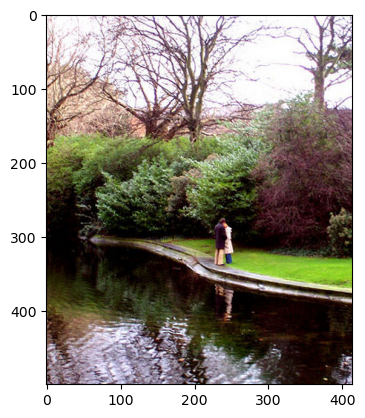

In [12]:
import numpy as np
from PIL import Image
import os
from keras.applications.xception import Xception
from pickle import load
import matplotlib.pyplot as plt

def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        print(feature)
        return feature

# Load the pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Example usage:

img_path = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Flickr8k_Dataset/3637013_c675de7705.jpg"
image = Image.open(img_path)
features = extract_features(img_path, xception_model)
if features is not None:
    print("Feature extraction successful:", features.shape)
else:
    print("Feature extraction failed")
plt.imshow(image)

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load

# Function to extract features from an image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        show_error_message("Error", "Couldn't open image! Make sure the image path and extension are correct.")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:  # Convert 4-channel images to 3 channels
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

# Function to map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Function to display error message in a separate window
def show_error_message(title, message):
    error_window = tk.Toplevel(root)
    error_window.title(title)
    error_label = tk.Label(error_window, text=message, padx=10, pady=10)
    error_label.pack()

# Load tokenizer
try:
    tokenizer = load(open("tokenizer.p", "rb"))
except Exception as e:
    show_error_message("Error", "Couldn't load tokenizer file!\nError: " + str(e))
    exit()

# Load model
try:
    model = load_model('models/model_19.keras')
except Exception as e:
    show_error_message("Error", "Couldn't load model file!\nError: " + str(e))
    exit()

# Load Xception model for feature extraction
xception_model = Xception(weights='imagenet', include_top=False, pooling="avg")

# Set maximum sequence length
max_length = 32

# Function to open an image and display its description
def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        photo = ImageTk.PhotoImage(image)
        image_label.config(image=photo)
        image_label.image = photo  # Keep reference to avoid garbage collection
        
        # Extract features for the selected image
        features = extract_features(file_path, xception_model)
        if features is not None:
            # Generate description for the selected image
            description = generate_desc(model, tokenizer, features, max_length)
            # Update the label with the generated description
            string_label.config(text="Selected Image: " + description)

# Create main application window
root = tk.Tk()
root.title("Image Caption Generator")

# Create a label to display the image
image_label = tk.Label(root)
image_label.pack(padx=10, pady=10)

# Create a label to display the string
string_label = tk.Label(root, text="Selected Image: None", wraplength=400)
string_label.pack(pady=5)

# Create a button to open the file dialog
open_button = tk.Button(root, text="Open Image", command=open_image)
open_button.pack(pady=5)

# Run the Tkinter event loop
root.mainloop()


2024-05-04 19:00:05.155972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 19:00:05.509755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 19:00:05.509831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 19:00:05.560113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 19:00:05.673398: I tensorflow/core/platform/cpu_feature_guar

1/1 [==============================] - 2s 2s/step
